# Imports & Notes to Improve Workflow

In [273]:
# Setup matplotlib to plot inline (within the notebook)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns;
import pandas as pd
import numpy as np
from datetime import datetime
# Libraries to aid in web scraping
import requests
import json
import re #regex
from bs4 import BeautifulSoup
import requests
import threading
from threading import Thread
#Notes for efficienccy:
#shift + tab when cursor is in arguments to bring up its documentation
#ex: pd.DataFrame(Shift+tab here)
#recall: Json == Dictionary
#to know functions of pandas:
#dir(pd)

# Reading The Data

In [274]:
# using pandas and read_csv()
acquis = pd.read_csv("datasets/startups/acquisitions.csv")
additions = pd.read_csv("datasets/startups/additions.csv")
companies = pd.read_csv("datasets/startups/companies.csv")
invests = pd.read_csv("datasets/startups/investments.csv")
rounds = pd.read_csv("datasets/startups/rounds.csv")
dfAll = [acquis, additions, companies, invests, rounds]

In [275]:
#shapes (rows x cols) of each dataset
for ele in dfAll:
    print(ele.shape)

(18969, 18)
(2213, 4)
(66368, 14)
(168647, 18)
(114949, 12)


# Samples of the datasets

In [276]:
acquis.sample(5).transpose()

,9733,2145,3257,16063,18229
company_permalink,/organization/lomadee,/organization/bigfoot-interactive,/organization/channelwave,/organization/sunesys,/organization/vpisystems
company_name,Lomadee,Bigfoot Interactive,ChannelWave,Sunesys,VPIsystems
company_category_list,Advertising Platforms|Publishing|Social Media,Email|Email Marketing|Services,Software,Telecommunications,Software
company_country_code,NaN,USA,USA,USA,USA
company_state_code,NaN,NY,MA,PA,NJ
company_region,NaN,New York City,Boston,Philadelphia,Newark
company_city,NaN,New York,Cambridge,Warrington,Holmdel
acquirer_permalink,/organization/buscape,/organization/alliance-data-systems-2,/organization/click-commerce,/organization/crown-castle,/organization/elanti-systems
acquirer_name,Buscape,Alliance Data Systems,Click Commerce,Crown Castle,Elanti Systems
acquirer_category_list,E-Commerce,Service Providers,Business Services|Enterprises|Software,Mobile|Telecommunications|Telephony,Software


In [277]:
additions.sample(5).transpose()

,1822,319,1792,847,764
content,Rounds: private_equity,IPOs,Rounds: private_equity,Profiles: Organizations,Profiles
month_str,2014-01,1980-03,2011-07,2007-12,2009-09
year_str,2014,1980,2011,2007,2009
value,44,1,12,233,3600


In [278]:
companies.sample(5).transpose()

,56376,58038,49310,32263,33869
permalink,/organization/tap-n-tap,/organization/three-squirrels-e-commerce,/organization/sagent,/organization/lifeio,/organization/magikflix
name,Tap 'n Tap,Three Squirrels E-commerce,Sagent,lifeIO,Magicflix
homepage_url,http://www.tapntap.com,http://www.3songshu.com,https://sagent.io/,http://www.lifeio.com,http://www.magicflix.com
category_list,Android|Digital Media|Mobile|Mobile Advertising,E-Commerce,Analytics|Big Data Analytics|Machine Learning|...,Curated Web,Android|Apps|iOS|Kids|Mobile|Video
funding_total_usd,2100000,6000000,250000,500000,1080000
status,operating,operating,operating,closed,operating
country_code,USA,CHN,NLD,USA,USA
state_code,MA,1,7,NY,WA
region,Boston,CHN - Other,Amsterdam,New York City,Seattle
city,Cambridge,Wuhu,Amsterdam,New York,Redmond


In [279]:
invests.sample(5).transpose()

,78033,98940,29242,126926,37057
company_permalink,/organization/knip,/organization/nexx-systems,/organization/chipx,/organization/scriptrock,/organization/crowdentials
company_name,Knip,Nexx Systems,ChipX,ScriptRock,Crowdentials
company_category_list,Finance|FinTech|Insurance,Semiconductors,Semiconductors,Enterprises|Enterprise Software|Intelligent Sy...,Crowdfunding|Finance
company_country_code,CHE,USA,USA,USA,USA
company_state_code,25,MA,CA,CA,OH
company_region,Zurich,Boston,SF Bay Area,SF Bay Area,Cleveland
company_city,Zürich,Billerica,San Jose,San Francisco,Cleveland
investor_permalink,/organization/route-66-ventures,/organization/enterprise-partners,/organization/wasserstein-ventures,/organization/square-peg-capital,/organization/flashstarts
investor_name,Route 66 Ventures,Enterprise Partners,Wasserstein Ventures,Square Peg Capital,Flashstarts
investor_country_code,NaN,USA,USA,AUS,USA


In [280]:
rounds.sample(5).transpose()

,87739,104431,104588,63974,111283
company_permalink,/organization/sensipass,/organization/ultimate-software,/organization/ungalli,/organization/morganna-s-alchemy,/organization/wonderpoint-software
company_name,SensiPass Ltd.,Ultimate Software,Ungalli,Morganna's Alchemy,WonderPoint Software
company_category_list,Biometrics|Security|Software|Technology,Software,Fashion,Cosmetics,Enterprise Software|Logistics|SaaS
company_country_code,IRL,USA,CAN,USA,IND
company_state_code,4,FL,NaN,FL,16
company_region,Cork,Ft. Lauderdale,NaN,Tampa,Mumbai
company_city,Cork,Weston,NaN,New Port Richey,Mumbai
funding_round_permalink,/funding-round/9403a05b9bed63033d82367349b71238,/funding-round/7eaa404142037bb67998cb184a2396b9,/funding-round/2f34c6f1064e10b62ac5719d4f28458b,/funding-round/8adbee8c4386e4e2da7093e814fa54e5,/funding-round/b48140993f00f342558146fd3b2d3f6b
funding_round_type,seed,venture,seed,equity_crowdfunding,seed
funding_round_code,NaN,NaN,NaN,NaN,NaN


# Seeing the columns in the datasets

In [281]:
def datasetsCols(dfList, datasetNames, pad=""):
    """
    Takes dataframes and returns a dataframe (df) with each column having a df's
    column names. The "pad" is to make sure all lists of columns have 
    the same length padded out with "pad"
    Example
    pad = "XX", datasetNames = ["cars", "planes"]
    dfList = [carsDF, planesDF]
    returned data frame:
            cars            planes
    0       numOfWheels     numOfWings
    1       manufacturer    manufacturer
    2       make            XX
    """
    cols = []
    maxArrayLen = 0
    for i, df in enumerate(dfList):
        cols.append(df.columns.tolist())
        maxArrayLen = max(maxArrayLen, len(cols[i]))
    
    dictCsvs = {}
    for i, df in enumerate(dfList):
        cols[i] += [pad] * (maxArrayLen - len(cols[i])) #padding the lists to make them have equal lengths 
        dictCsvs.update({datasetNames[i] : cols[i]})

    return pd.DataFrame(dictCsvs)

In [282]:
lstCsvNames = ["acquisitions", "additions", "companies", "investments", "rounds"]

dfAllCols = datasetsCols(dfAll, lstCsvNames)
dfAllCols

,acquisitions,additions,companies,investments,rounds
0,company_permalink,content,permalink,company_permalink,company_permalink
1,company_name,month_str,name,company_name,company_name
2,company_category_list,year_str,homepage_url,company_category_list,company_category_list
3,company_country_code,value,category_list,company_country_code,company_country_code
4,company_state_code,,funding_total_usd,company_state_code,company_state_code
5,company_region,,status,company_region,company_region
6,company_city,,country_code,company_city,company_city
7,acquirer_permalink,,state_code,investor_permalink,funding_round_permalink
8,acquirer_name,,region,investor_name,funding_round_type
9,acquirer_category_list,,city,investor_country_code,funding_round_code


# Data Cleaning

First, lets change the columns in the `companies` dataset <br>
to be the similar to all other datasets: <br>
(we're doing this in case we merge the datasets together, we want them to have the same column names)

In [283]:
companies.rename(columns = {'permalink' : 'company_permalink', 
                            'name' : 'company_name',
                            'category_list' : 'company_category_list',
                            'country_code' : 'company_country_code',
                            'state_code' : 'company_state_code',
                            'region' : 'company_region',
                            'city' : 'company_city'}, inplace = True)

In [284]:
dfAll[2] = companies
dfAllCols = datasetsCols(dfAll, lstCsvNames)
dfAllCols

,acquisitions,additions,companies,investments,rounds
0,company_permalink,content,company_permalink,company_permalink,company_permalink
1,company_name,month_str,company_name,company_name,company_name
2,company_category_list,year_str,homepage_url,company_category_list,company_category_list
3,company_country_code,value,company_category_list,company_country_code,company_country_code
4,company_state_code,,funding_total_usd,company_state_code,company_state_code
5,company_region,,status,company_region,company_region
6,company_city,,company_country_code,company_city,company_city
7,acquirer_permalink,,company_state_code,investor_permalink,funding_round_permalink
8,acquirer_name,,company_region,investor_name,funding_round_type
9,acquirer_category_list,,company_city,investor_country_code,funding_round_code


Let's start by analyzing `additions` dataset, as it has unusual format of columns

## Removing "additions" Dataset

In [285]:
additions.sample(5)

,content,month_str,year_str,value
666,IPOs,2010-03,2010,18
1622,Rounds: grant,2014-03,2014,49
1340,Rounds: angel,2014-05,2014,121
1184,Rounds,2010-01,2010,802
644,IPOs,2008-05,2008,19


In [286]:
additions["content"].unique()

array(['Acquisitions', 'IPOs', 'Profiles', 'Profiles: Organizations',
       'Profiles: People', 'Profiles: Products', 'Rounds',
       'Rounds: angel', 'Rounds: convertible_note',
       'Rounds: debt_financing', 'Rounds: equity_crowdfunding',
       'Rounds: grant', 'Rounds: non_equity_assistance',
       'Rounds: post_ipo_debt', 'Rounds: post_ipo_equity',
       'Rounds: private_equity', 'Rounds: product_crowdfunding',
       'Rounds: secondary_market', 'Rounds: seed', 'Rounds: undisclosed',
       'Rounds: venture'], dtype=object)

In [287]:
dfAllCols

,acquisitions,additions,companies,investments,rounds
0,company_permalink,content,company_permalink,company_permalink,company_permalink
1,company_name,month_str,company_name,company_name,company_name
2,company_category_list,year_str,homepage_url,company_category_list,company_category_list
3,company_country_code,value,company_category_list,company_country_code,company_country_code
4,company_state_code,,funding_total_usd,company_state_code,company_state_code
5,company_region,,status,company_region,company_region
6,company_city,,company_country_code,company_city,company_city
7,acquirer_permalink,,company_state_code,investor_permalink,funding_round_permalink
8,acquirer_name,,company_region,investor_name,funding_round_type
9,acquirer_category_list,,company_city,investor_country_code,funding_round_code


In [288]:
additions.shape

(2213, 4)

In [289]:
companies.shape, rounds.shape

((66368, 14), (114949, 12))

So apparently there are no columns that could be used to join with the other datasets. <br>
Furthermore, the "value" column is too vague to be useful. <br>
Therefore, the "additions" dataset will be discarded.

In [290]:
dfAll.pop(1)
lstCsvNames.pop(1)
len(dfAll), lstCsvNames

(4, ['acquisitions', 'companies', 'investments', 'rounds'])

## `rounds` Dataset

In [291]:
dfAllCols.iloc[:, -2:]

,investments,rounds
0,company_permalink,company_permalink
1,company_name,company_name
2,company_category_list,company_category_list
3,company_country_code,company_country_code
4,company_state_code,company_state_code
5,company_region,company_region
6,company_city,company_city
7,investor_permalink,funding_round_permalink
8,investor_name,funding_round_type
9,investor_country_code,funding_round_code


In [292]:
invests.shape, rounds.shape

((168647, 18), (114949, 12))

In [293]:
invests.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/organization/dt-capital-partners,DT Capital Partners,CHN,23,Shanghai,Shanghai,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,3/19/2008,2000000.0
1,/organization/004-technologies,004 Technologies,Software,USA,IL,"Springfield, Illinois",Champaign,/organization/venturecapital-de,VCDE Venture Partners,DEU,5,Frankfurt,Frankfurt,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,7/24/2014,NaN
2,/organization/01games-technology,01Games Technology,Games,HKG,NaN,Hong Kong,Hong Kong,/organization/cyberport-hong-kong,Cyberport Hong Kong,HKG,NaN,Hong Kong,Hong Kong,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,undisclosed,NaN,7/1/2014,41250.0
3,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/organization/capital-one,Capital One,USA,VA,"Washington, D.C.",Mclean,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,11/9/2015,20000000.0
4,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/organization/nexus-venture-partners,Nexus Venture Partners,USA,CA,SF Bay Area,Menlo Park,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,NaN,5/22/2013,3000000.0


In [294]:
rounds.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,#fame,Media,IND,16,Mumbai,Mumbai,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,1/5/2015,10000000.0
1,/organization/-qounter,:Qounter,Application Platforms|Real Time|Social Network...,USA,DE,DE - Other,Delaware City,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,10/14/2014,NaN
2,/organization/-qounter,:Qounter,Application Platforms|Real Time|Social Network...,USA,DE,DE - Other,Delaware City,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,3/1/2014,700000.0
3,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",Apps|Games|Mobile,NaN,NaN,NaN,NaN,/funding-round/650b8f704416801069bb178a1418776b,venture,B,1/30/2014,3406878.0
4,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,3/19/2008,2000000.0


In [295]:
len(invests["company_name"].unique()), len(rounds["company_name"].unique())

(44579, 66103)

Since there are companies in `rounds` dataset that are not in `investments` dataset, <br>
therefore we should keep `rounds` dataset for further analysis.

# Data Cleaning (Cont.)

## Checking All Missing Values

In [296]:
def datasetsNulls(dfList, datasetNames, nullCol="nulls_", pad=""):
    """
    Use this when you want to display a column of column names,
    then a column of the null values, and repeat that for each dataset.
    Returns a dataframe
    """
    cols = []
    nulls = []
    maxArrayLen = 0
    for i, df in enumerate(dfList):
        cols.append(df.columns.tolist())
        nulls.append(df.isnull().sum().tolist())
        maxArrayLen = max(maxArrayLen, len(cols[i]))
    
    dictCsvs = {}
    for i, df in enumerate(dfList):
        cols[i] += [pad] * (maxArrayLen - len(cols[i])) #padding the lists to make them have equal lengths 
        nulls[i] += [None] *  (maxArrayLen - len(nulls[i]))
        dictCsvs[datasetNames[i]] = cols[i]
        dictCsvs[nullCol + str(i+1)] = nulls[i]
    
    return pd.DataFrame(dictCsvs)

In [297]:
dfAllNulls = datasetsNulls(dfAll, lstCsvNames)
dfAllNulls

,acquisitions,nulls_1,companies,nulls_2,investments,nulls_3,rounds,nulls_4
0,company_permalink,0,company_permalink,0.0,company_permalink,0,company_permalink,0.0
1,company_name,1,company_name,1.0,company_name,1,company_name,1.0
2,company_category_list,4984,homepage_url,5058.0,company_category_list,3632,company_category_list,3410.0
3,company_country_code,4669,company_category_list,3148.0,company_country_code,10521,company_country_code,8678.0
4,company_state_code,4949,funding_total_usd,0.0,company_state_code,13431,company_state_code,10946.0
5,company_region,4911,status,0.0,company_region,12485,company_region,10167.0
6,company_city,4911,company_country_code,6958.0,company_city,12483,company_city,10164.0
7,acquirer_permalink,1,company_state_code,8547.0,investor_permalink,12,funding_round_permalink,0.0
8,acquirer_name,1,company_region,8030.0,investor_name,12,funding_round_type,0.0
9,acquirer_category_list,2389,company_city,8028.0,investor_country_code,30939,funding_round_code,83809.0


### `dropna()` for columns with few missing values

Notice that there is one row that doesn't contain a company name, <br>
so let's validate that it is the same company across all datasets, <br>
so we can remove it:

In [298]:
datasetsCols(dfAll, lstCsvNames)

,acquisitions,companies,investments,rounds
0,company_permalink,company_permalink,company_permalink,company_permalink
1,company_name,company_name,company_name,company_name
2,company_category_list,homepage_url,company_category_list,company_category_list
3,company_country_code,company_category_list,company_country_code,company_country_code
4,company_state_code,funding_total_usd,company_state_code,company_state_code
5,company_region,status,company_region,company_region
6,company_city,company_country_code,company_city,company_city
7,acquirer_permalink,company_state_code,investor_permalink,funding_round_permalink
8,acquirer_name,company_region,investor_name,funding_round_type
9,acquirer_category_list,company_city,investor_country_code,funding_round_code


In [299]:
#company_permalink of each row that doesn't have a company name:
for df in dfAll:
    print(df[df['company_name'].isnull()]['company_permalink'].values)

['mendatio"']
['/organization/tell-it-in']
['/organization/tell-it-in']
['/organization/tell-it-in']


So apparently, the `acquisitions` dataset has a different permalink that has no company name, <br>
So we could remove these two companies, as the total number of companies are big enough to get the insight that we want.

`dfAllNulls` dataframe also shows that there are missing values for `acquirer_name` and `investor_name` <br>
which can't be imputed, so we'll also remove them.

Finally, we'll remove the missing values for columns that have less than 100 `NaN`, <br>
as they're small in comparison to their respective datasets:

In [300]:
# This syntax won't work, as it turns out, df[0] is a copy of a dataframe (eg: a copy of acquisitions, so they don't share the same reference)
#for df in dfAll:
#    nulls = df.isnull().sum()
#    cols = nulls[(nulls <= 100) & (nulls != 0)].index.tolist()
#    df.dropna(subset=cols, inplace=True)
#dfAllNulls = datasetsNulls(dfAll, lstCsvNames)
#dfAllNulls

In [301]:
nulls = acquis.isnull().sum()
cols = nulls[(nulls <= 100) & (nulls != 0)].index.tolist()
acquis.dropna(subset=cols, inplace=True)

nulls = companies.isnull().sum()
cols = nulls[(nulls <= 100) & (nulls != 0)].index.tolist()
companies.dropna(subset=cols, inplace=True)

nulls = invests.isnull().sum()
cols = nulls[(nulls <= 100) & (nulls != 0)].index.tolist()
invests.dropna(subset=cols, inplace=True)

nulls = rounds.isnull().sum()
cols = nulls[(nulls <= 100) & (nulls != 0)].index.tolist()
rounds.dropna(subset=cols, inplace=True)

In [302]:
dfAll = [acquis, companies, invests, rounds]
lstCsvNames = ["acquisitions", "companies", "investments", "rounds"]
dfAllNulls = datasetsNulls(dfAll, lstCsvNames)
dfAllNulls

,acquisitions,nulls_1,companies,nulls_2,investments,nulls_3,rounds,nulls_4
0,company_permalink,0,company_permalink,0.0,company_permalink,0,company_permalink,0.0
1,company_name,0,company_name,0.0,company_name,0,company_name,0.0
2,company_category_list,4977,homepage_url,5058.0,company_category_list,3632,company_category_list,3410.0
3,company_country_code,4661,company_category_list,3147.0,company_country_code,10521,company_country_code,8678.0
4,company_state_code,4940,funding_total_usd,0.0,company_state_code,13431,company_state_code,10946.0
5,company_region,4902,status,0.0,company_region,12485,company_region,10167.0
6,company_city,4902,company_country_code,6956.0,company_city,12483,company_city,10164.0
7,acquirer_permalink,0,company_state_code,8545.0,investor_permalink,0,funding_round_permalink,0.0
8,acquirer_name,0,company_region,8028.0,investor_name,0,funding_round_type,0.0
9,acquirer_category_list,2387,company_city,8026.0,investor_country_code,30927,funding_round_code,83808.0


## Converting & Imputing Dates

We are currently interested in 'founded_at', 'first_funding_at' and 'last_funding_at' columns. <br>
Before doing operations on dates, they need to be converted first from 'Object' to 'DateTime'.

In [303]:
companies['founded_at'] =pd.to_datetime(companies['founded_at'], errors = 'coerce')
companies['first_funding_at'] =pd.to_datetime(companies['first_funding_at'], errors = 'coerce') 
#^^ 3 rows will not be converted succesfully and will become "NaN" (shown later)
companies['last_funding_at'] =pd.to_datetime(companies['last_funding_at'], errors = 'coerce')
companies.dtypes

company_permalink                object
company_name                     object
homepage_url                     object
company_category_list            object
funding_total_usd                object
status                           object
company_country_code             object
company_state_code               object
company_region                   object
company_city                     object
funding_rounds                    int64
founded_at               datetime64[ns]
first_funding_at         datetime64[ns]
last_funding_at          datetime64[ns]
dtype: object

After converting, we need to impute the missing values on the dates of when those companies where founded at. <br>
So, this will be done by first creating a new column that calculates how long it took to get the first funding. <br>
This will be done by subtracting the date of the founding from the date of the first funding. <br> Note that we will find some values in negative which indicate that some companies took funding before establishing it.


In [304]:
companies['time_before_first_fund'] = companies['first_funding_at'] - companies['founded_at']
companies['time_before_first_fund']

0             NaT
1       -187 days
2             NaT
3        443 days
4       1665 days
           ...   
66363         NaT
66364   -194 days
66365   1308 days
66366    365 days
66367         NaT
Name: time_before_first_fund, Length: 66343, dtype: timedelta64[ns]

Now we need to calculate the mean of the time before the first funding and impute the missing values with this average. Notice that the average is 1370 days which is around 3.7 years which means there must be some outliers that messed up the average.

In [305]:
companies['time_before_first_fund'].mean()

Timedelta('1370 days 03:49:18.015610624')

Therefore, we will need to visualize those outliers and maybe if they are causing inaccuracy in the data, we can drop them.

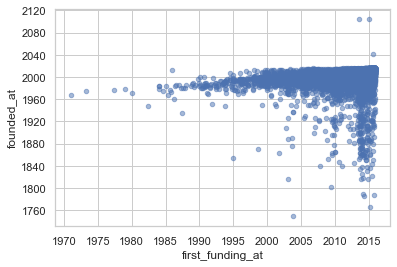

In [306]:
plt.scatter(companies['first_funding_at'], companies['founded_at'], s = 20, alpha = 0.5)
plt.xlabel('first_funding_at')
plt.ylabel('founded_at');

We Noticed that there are some outliers than can be removed from the dataset <br> 
so we will create a temporary dataframe that will contain the outliers so we can drop them later on. <br>The first outliers that we want to deduct are the ones at the left of the center.

In [307]:
from datetime import datetime
tempdf = companies.copy()
tempdf = tempdf[
    (tempdf.first_funding_at <= datetime.strptime("01/01/1983", "%d/%m/%Y")) 
    & 
    (tempdf.founded_at <= datetime.strptime("01/01/2000", "%d/%m/%Y"))
]
dropseries = tempdf.copy()
dropseries

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_state_code,company_region,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund
744,/organization/abo-data,ABO Data,http://PLATONE.IO,Enterprise Software,1000000,operating,USA,TX,TX - Other,Italy,1,1979-01-01,1979-01-01,1979-01-01,0 days
3728,/organization/apple,Apple,http://www.apple.com,Computers|Consumer Electronics|Electronics|Har...,250000,ipo,USA,CA,SF Bay Area,Cupertino,1,1976-04-01,1977-05-15,1977-05-15,409 days
8786,/organization/buena-park-locksmith,Buena Park Locksmith,http://www.BuenaParkLocksmithCA.com,Local Businesses,-,operating,USA,CA,Anaheim,Buena Park,1,1974-11-20,1973-04-15,1973-04-15,-584 days
26908,/organization/ikro,Ikro,http://www.ikro.com.br/,Automotive|Heavy Industry|Manufacturing,724000,closed,BRA,23,BRA - Other,Canoas,1,1947-01-01,1982-06-01,1982-06-01,12935 days
28378,/organization/intercomp,Intercomp,NaN,NaN,549000,closed,NaN,NaN,NaN,NaN,1,1968-01-01,1971-01-01,1971-01-01,1096 days
36251,/organization/mitrol-2,Mitrol,NaN,NaN,9000000,closed,NaN,NaN,NaN,NaN,1,1971-01-01,1980-01-01,1980-01-01,3287 days


Plotting the outliers on a separate graph:

Text(0, 0.5, 'founded_at')

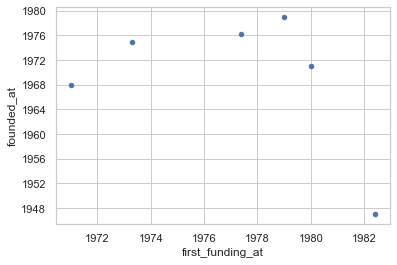

In [308]:
plt.scatter(tempdf['first_funding_at'], tempdf['founded_at'], s = 20)
plt.xlabel('first_funding_at')
plt.ylabel('founded_at')

Now we will determine the outliers that are the bottom of the center from the original graph.

In [309]:
tempdf = companies.copy()
tempdf = tempdf[(tempdf.first_funding_at < datetime.strptime("01/01/2005", "%d/%m/%Y"))& (tempdf.founded_at <= datetime.strptime("01/01/1900", "%d/%m/%Y"))]
tempdf

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_state_code,company_region,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund
4563,/organization/asia-pacific-marine-container-lines,Asia Pacific Marine Container Lines,http://AsiaPacificMarine.com,Logistics Company|Shipping|Shipping Broker Ind...,-,closed,CAN,BC,Vancouver,Vancouver,1,1870-01-05,1998-09-01,1998-09-01,46990 days
4748,/organization/athenix,Athenix,http://www.athenixcorp.com,Biotechnology,43500000,acquired,USA,NC,Raleigh,Raleigh,4,1863-01-01,2001-09-10,2008-07-23,50656 days
8240,/organization/boylan-bottling,Boylan Bottling,https://www.boylanbottling.com/,NaN,-,closed,USA,NY,New York City,New York,1,1891-01-01,2003-09-10,2003-09-10,41159 days
12370,/organization/coleman-natural-foods,Coleman Natural Foods,http://www.colemannatural.com/,Hospitality,9000000,operating,USA,NC,Asheville,Mountain Home,1,1875-01-01,2003-08-20,2003-08-20,46982 days
13513,/organization/counterpane-internet-security-in...,Counterpane Internet Security,http://www.counterpane.com,Risk Management|Sales and Marketing|Security,20000000,acquired,USA,CA,SF Bay Area,Cupertino,1,1888-01-01,2003-01-14,2003-01-14,42016 days
20690,/organization/fkk-corporation,FKK Corporation,http://www.fkk-corporation.com,Hardware + Software,-,operating,JPN,22,Kyoto,Kyoto-shi,1,1854-02-01,1995-01-01,1995-01-01,51468 days
47744,/organization/remington-arms-company,Remington Arms Company,http://www.remington.com/,Manufacturing|Outdoors|Sporting Goods,30000000,operating,USA,NC,Greensboro,Madison,1,1816-01-01,2003-01-10,2003-01-10,68310 days
49957,/organization/scottish-newcastle-plc,Scottish & Newcastle PLC,NaN,Brewing,4200000,operating,GBR,U8,Edinburgh,Edinburgh,1,1749-01-01,2003-10-10,2003-10-10,93053 days


Plotting the outliers on a separate graph:

Text(0, 0.5, 'founded_at')

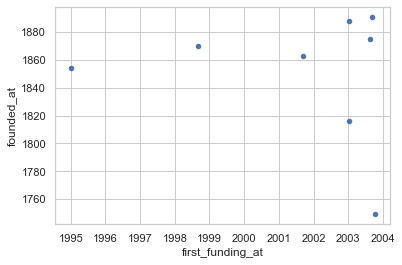

In [310]:
plt.scatter(tempdf['first_funding_at'], tempdf['founded_at'], s = 20)
plt.xlabel('first_funding_at')
plt.ylabel('founded_at')

Now we will concatenate the newly discovered outliers to the ones from before

In [311]:
dropseries = pd.concat([dropseries, tempdf])
dropseries

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_state_code,company_region,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund
744,/organization/abo-data,ABO Data,http://PLATONE.IO,Enterprise Software,1000000,operating,USA,TX,TX - Other,Italy,1,1979-01-01,1979-01-01,1979-01-01,0 days
3728,/organization/apple,Apple,http://www.apple.com,Computers|Consumer Electronics|Electronics|Har...,250000,ipo,USA,CA,SF Bay Area,Cupertino,1,1976-04-01,1977-05-15,1977-05-15,409 days
8786,/organization/buena-park-locksmith,Buena Park Locksmith,http://www.BuenaParkLocksmithCA.com,Local Businesses,-,operating,USA,CA,Anaheim,Buena Park,1,1974-11-20,1973-04-15,1973-04-15,-584 days
26908,/organization/ikro,Ikro,http://www.ikro.com.br/,Automotive|Heavy Industry|Manufacturing,724000,closed,BRA,23,BRA - Other,Canoas,1,1947-01-01,1982-06-01,1982-06-01,12935 days
28378,/organization/intercomp,Intercomp,NaN,NaN,549000,closed,NaN,NaN,NaN,NaN,1,1968-01-01,1971-01-01,1971-01-01,1096 days
36251,/organization/mitrol-2,Mitrol,NaN,NaN,9000000,closed,NaN,NaN,NaN,NaN,1,1971-01-01,1980-01-01,1980-01-01,3287 days
4563,/organization/asia-pacific-marine-container-lines,Asia Pacific Marine Container Lines,http://AsiaPacificMarine.com,Logistics Company|Shipping|Shipping Broker Ind...,-,closed,CAN,BC,Vancouver,Vancouver,1,1870-01-05,1998-09-01,1998-09-01,46990 days
4748,/organization/athenix,Athenix,http://www.athenixcorp.com,Biotechnology,43500000,acquired,USA,NC,Raleigh,Raleigh,4,1863-01-01,2001-09-10,2008-07-23,50656 days
8240,/organization/boylan-bottling,Boylan Bottling,https://www.boylanbottling.com/,NaN,-,closed,USA,NY,New York City,New York,1,1891-01-01,2003-09-10,2003-09-10,41159 days
12370,/organization/coleman-natural-foods,Coleman Natural Foods,http://www.colemannatural.com/,Hospitality,9000000,operating,USA,NC,Asheville,Mountain Home,1,1875-01-01,2003-08-20,2003-08-20,46982 days


Finally, we will deduct the outliers that are the top right corner

In [312]:
tempdf = companies.copy()
tempdf = tempdf[(tempdf.first_funding_at > datetime.strptime("01/01/2010", "%d/%m/%Y"))& (tempdf.founded_at >= datetime.strptime("01/01/2030", "%d/%m/%Y"))]
tempdf

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_state_code,company_region,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund
16681,/organization/dugoutfc-ltd,DugoutFC Ltd,http://www.dugoutfc.com,Fantasy Sports,100000,operating,NaN,NaN,NaN,NaN,1,2105-02-17,2015-01-01,2015-01-01,-32919 days
32736,/organization/livamp-2,LIVAMP,http://www.livamp.com,Entertainment|Music|Video,300000,closed,NaN,NaN,NaN,NaN,1,2041-09-21,2015-08-31,2015-08-31,-9518 days
53396,/organization/soply,Soply,https://soply.com/,Creative Industries|Digital Media|Marketplaces,150000,operating,GBR,H9,London,London,1,2104-01-01,2013-07-01,2013-07-01,-33055 days


Visualizing the outliers:

Text(0.92, 0.21, 'current date')

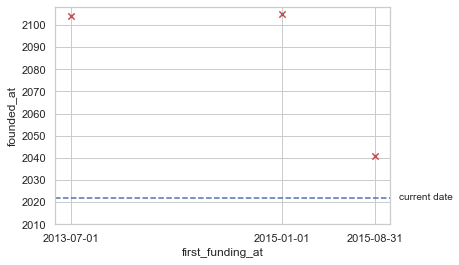

In [313]:
from datetime import date
plt.scatter(tempdf['first_funding_at'], tempdf['founded_at'].dt.year, s = 40, marker='x', color='r') # 's' == marker size
plt.xlabel('first_funding_at')
plt.ylabel('founded_at')
plt.xticks(['2013-07-01', '2015-01-01', '2015-08-31'])
plt.yticks(range(2010, 2110, 10));
plt.axhline(date.today().year, color='b', linestyle='--')
plt.figtext(x=.92, y=.21, s='current date')

Concatinating the outliers on the rest:

In [314]:
dropseries = pd.concat([dropseries, tempdf])
dropseries

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_state_code,company_region,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund
744,/organization/abo-data,ABO Data,http://PLATONE.IO,Enterprise Software,1000000,operating,USA,TX,TX - Other,Italy,1,1979-01-01,1979-01-01,1979-01-01,0 days
3728,/organization/apple,Apple,http://www.apple.com,Computers|Consumer Electronics|Electronics|Har...,250000,ipo,USA,CA,SF Bay Area,Cupertino,1,1976-04-01,1977-05-15,1977-05-15,409 days
8786,/organization/buena-park-locksmith,Buena Park Locksmith,http://www.BuenaParkLocksmithCA.com,Local Businesses,-,operating,USA,CA,Anaheim,Buena Park,1,1974-11-20,1973-04-15,1973-04-15,-584 days
26908,/organization/ikro,Ikro,http://www.ikro.com.br/,Automotive|Heavy Industry|Manufacturing,724000,closed,BRA,23,BRA - Other,Canoas,1,1947-01-01,1982-06-01,1982-06-01,12935 days
28378,/organization/intercomp,Intercomp,NaN,NaN,549000,closed,NaN,NaN,NaN,NaN,1,1968-01-01,1971-01-01,1971-01-01,1096 days
36251,/organization/mitrol-2,Mitrol,NaN,NaN,9000000,closed,NaN,NaN,NaN,NaN,1,1971-01-01,1980-01-01,1980-01-01,3287 days
4563,/organization/asia-pacific-marine-container-lines,Asia Pacific Marine Container Lines,http://AsiaPacificMarine.com,Logistics Company|Shipping|Shipping Broker Ind...,-,closed,CAN,BC,Vancouver,Vancouver,1,1870-01-05,1998-09-01,1998-09-01,46990 days
4748,/organization/athenix,Athenix,http://www.athenixcorp.com,Biotechnology,43500000,acquired,USA,NC,Raleigh,Raleigh,4,1863-01-01,2001-09-10,2008-07-23,50656 days
8240,/organization/boylan-bottling,Boylan Bottling,https://www.boylanbottling.com/,NaN,-,closed,USA,NY,New York City,New York,1,1891-01-01,2003-09-10,2003-09-10,41159 days
12370,/organization/coleman-natural-foods,Coleman Natural Foods,http://www.colemannatural.com/,Hospitality,9000000,operating,USA,NC,Asheville,Mountain Home,1,1875-01-01,2003-08-20,2003-08-20,46982 days


Now, we can drop all of the outliers that have been detected.


In [315]:
list = dropseries.index
companies = companies.drop(list)
#companies['time_before_first_fund'].sort_values(ascending=False)

Plotting the graph once more after cleaning:

Text(0, 0.5, 'founded_at')

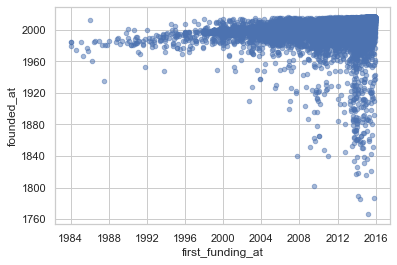

In [316]:
plt.scatter(companies['first_funding_at'], companies['founded_at'], s = 20, alpha=0.5)
plt.xlabel('first_funding_at')
plt.ylabel('founded_at')

Now, we can calculate the mean. Notice that there were not much of a difference but deducting the outliers helped keeping the data realistic because some dates were 2090, 2100, etc. which is unrealistic.

In [317]:
companies['time_before_first_fund'].mean()

Timedelta('1363 days 03:13:16.759422320')

Filling the missing values with the new mean:

In [318]:
companies['time_before_first_fund'].fillna(companies['time_before_first_fund'].mean(), inplace = True)
companies['time_before_first_fund']

0       1363 days 03:13:16.759422320
1                -187 days +00:00:00
2       1363 days 03:13:16.759422320
3                  443 days 00:00:00
4                 1665 days 00:00:00
                    ...             
66363   1363 days 03:13:16.759422320
66364            -194 days +00:00:00
66365             1308 days 00:00:00
66366              365 days 00:00:00
66367   1363 days 03:13:16.759422320
Name: time_before_first_fund, Length: 66326, dtype: timedelta64[ns]

After calculating the mean and filling the nulls with it, now we can impute the missing dates in the 'founded_at' column by subtracting the time before first funding from the first funding date.

In [319]:
companies['founded_at'].fillna(companies['first_funding_at'] - companies['time_before_first_fund'], inplace = True)
companies['founded_at']

0       2011-04-12 20:46:43.240577680
1       2014-09-04 00:00:00.000000000
2       2010-05-07 20:46:43.240577680
3       2007-01-01 00:00:00.000000000
4       2010-01-01 00:00:00.000000000
                     ...             
66363   2008-07-07 20:46:43.240577680
66364   2012-05-13 00:00:00.000000000
66365   2011-01-01 00:00:00.000000000
66366   2014-01-01 00:00:00.000000000
66367   2010-01-06 20:46:43.240577680
Name: founded_at, Length: 66326, dtype: datetime64[ns]

Converting 'aquired_at' of the acquisitons dataset from Object to date:

In [320]:
acquis['acquired_at'] =pd.to_datetime(acquis['acquired_at'], errors = 'coerce')
acquis.dtypes

company_permalink                 object
company_name                      object
company_category_list             object
company_country_code              object
company_state_code                object
company_region                    object
company_city                      object
acquirer_permalink                object
acquirer_name                     object
acquirer_category_list            object
acquirer_country_code             object
acquirer_state_code               object
acquirer_region                   object
acquirer_city                     object
acquired_at               datetime64[ns]
acquired_month                    object
price_amount                     float64
price_currency_code               object
dtype: object

Converting 'funded_at' of the investments dataset from Object to date:

In [321]:
invests['funded_at'] =pd.to_datetime(invests['funded_at'], errors = 'coerce')
invests.dtypes

company_permalink                  object
company_name                       object
company_category_list              object
company_country_code               object
company_state_code                 object
company_region                     object
company_city                       object
investor_permalink                 object
investor_name                      object
investor_country_code              object
investor_state_code                object
investor_region                    object
investor_city                      object
funding_round_permalink            object
funding_round_type                 object
funding_round_code                 object
funded_at                  datetime64[ns]
raised_amount_usd                 float64
dtype: object

Converting 'funded_at' of the rounds dataset from Object to date:

In [322]:
rounds['funded_at'] =pd.to_datetime(rounds['funded_at'], errors = 'coerce')
rounds.dtypes

company_permalink                  object
company_name                       object
company_category_list              object
company_country_code               object
company_state_code                 object
company_region                     object
company_city                       object
funding_round_permalink            object
funding_round_type                 object
funding_round_code                 object
funded_at                  datetime64[ns]
raised_amount_usd                 float64
dtype: object

## Imputing Categories

Regarding the category list in the five datasets, since we don't have any indicator on deducing the null values in this column, we will fill the nulls with "missing". With samples, it's provided that the same rows (companies) that their category is missing in one dataset, are the same rows in the others so even merging the datasets will not be helpful.


In [323]:
companies['company_category_list'].fillna('missing', inplace=True)
acquis['company_category_list'].fillna('missing', inplace=True)
acquis['acquirer_category_list'].fillna('missing', inplace=True)
invests['company_category_list'].fillna('missing', inplace=True)
rounds['company_category_list'].fillna('missing', inplace=True)

## Imputing Raised Amount

There are alot of missing data in the raised amount column in the data set. One strategy that could be taken is to calculate the mean of all the funds of a certain company and impute its nulls with the average of total fund it has recieved before. First we calculate the mean of the total funding of each company then add it in a new row, then compare each row if the raised amount column is null, then fill it with the average of the company otherwise leave it as it is.

In [324]:
total = invests.groupby(['company_name'])['raised_amount_usd'].transform(np.mean) #side note below
total = pd.DataFrame(total) #could be omitted, as we can assign the column 'total_raised' to a series, not just a dataframe
invests['total_raised'] = total
invests['raised_amount_usd'] = np.where((invests['raised_amount_usd'].isnull()), invests['total_raised'], invests['raised_amount_usd'])
#                                                      if this ^ is true        then impute with this ^    else impute with this ^
invests['raised_amount_usd'].fillna(invests['raised_amount_usd'].mean(), inplace = True)
invests

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,total_raised
0,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/organization/dt-capital-partners,DT Capital Partners,CHN,23,Shanghai,Shanghai,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,2.000000e+06,2.000000e+06
1,/organization/004-technologies,004 Technologies,Software,USA,IL,"Springfield, Illinois",Champaign,/organization/venturecapital-de,VCDE Venture Partners,DEU,5,Frankfurt,Frankfurt,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,2014-07-24,1.493930e+07,NaN
2,/organization/01games-technology,01Games Technology,Games,HKG,NaN,Hong Kong,Hong Kong,/organization/cyberport-hong-kong,Cyberport Hong Kong,HKG,NaN,Hong Kong,Hong Kong,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,undisclosed,NaN,2014-07-01,4.125000e+04,4.125000e+04
3,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/organization/capital-one,Capital One,USA,VA,"Washington, D.C.",Mclean,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,2015-11-09,2.000000e+07,1.010714e+07
4,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/organization/nexus-venture-partners,Nexus Venture Partners,USA,CA,SF Bay Area,Menlo Park,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,NaN,2013-05-22,3.000000e+06,1.010714e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168642,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,Advertising|Mobile|Web Development|Wireless,HRV,15,Split,Split,/organization/eleven,Eleven,BGR,42,Sofia,Sofia,/funding-round/ff1aa06ed5da186c84f101549035d4ae,seed,NaN,2013-05-01,3.284200e+04,3.576800e+04
168643,/organization/Áeron,ÁERON,missing,NaN,NaN,NaN,NaN,/organization/day-one-capital,Day One Capital Fund Management,HUN,5,Budapest,Budapest,/funding-round/59f4dce44723b794f21ded3daed6e4fe,venture,A,2014-08-01,1.493930e+07,NaN
168644,/organization/Áeron,ÁERON,missing,NaN,NaN,NaN,NaN,/organization/sz-chenyi-capital-fund-management,Széchenyi Capital Fund Management,NaN,NaN,NaN,NaN,/funding-round/59f4dce44723b794f21ded3daed6e4fe,venture,A,2014-08-01,1.493930e+07,NaN
168645,/organization/Ôasys-2,Ôasys,Consumer Electronics|Internet of Things|Teleco...,USA,CA,SF Bay Area,San Francisco,/organization/startupbootcamp,Startupbootcamp,GBR,H9,London,London,/funding-round/35f09d0794651719b02bbfd859ba9ff5,seed,NaN,2015-01-01,1.819200e+04,1.819200e+04


### Side note: difference between `.mean()` and `.transform(np.mean)`
([source](https://stackoverflow.com/questions/40957932/transform-vs-aggregate-in-pandas))

<img src='Phase 1/meanVsTransform1.png' width=500>

<img src='Phase 1/meanVsTransform2.png' width=300>

<img src='Phase 1/meanVsTransform33.png' width=600>

And we want to broadcast values and have it with original index (0 to len(invests)), <br>
as this will assign `invests['total_raised'] = total` based on the index values <br>
Example:

<img src='Phase 1/colEqualSeries1.png' width=400>

<img src='Phase 1/colEqualSeries2.png' width=400>

<img src='Phase 1/colEqualSeries3.png' width=200>

## Cleaning & Imputing Geographical Locations

### Removing `company_state_code` and `company_region`

We don't need `company_state_code` in our analysis, <br>
As country code and city are sufficient to know <br>
an approximation of the geographical location of the company. <br>
Therefore, let's remove it:

In [325]:
companies[['company_country_code', 'company_state_code', 'company_city']].head(10)

,company_country_code,company_state_code,company_city
0,IND,16,Mumbai
1,USA,DE,Delaware City
2,NaN,NaN,NaN
3,CHN,22,Beijing
4,USA,IL,Champaign
5,HKG,NaN,Hong Kong
6,CAN,BC,Vancouver
7,USA,CA,Mountain View
8,USA,CA,San Francisco
9,CHL,12,Las Condes


In [326]:
companies.drop('company_state_code', axis=1, inplace=True)

`company_region` is also redundent, as it is usually the same as `company_city`.<br>
Let's validate this:

In [327]:
# Note: same logic applies for the permalinks
acquis.dropna(subset=['acquirer_permalink', 'acquirer_name'], inplace=True)
invests.dropna(subset=['investor_permalink', 'investor_name'], inplace=True)

Also, we'll remove the missing values for columns that have less than 100 `NaN`, <br>
as they're small in comparison to their respective datasets:

In [328]:
companies[companies.company_region == companies.company_city][['company_region', 'company_city']]

,company_region,company_city
0,Mumbai,Mumbai
3,Beijing,Beijing
5,Hong Kong,Hong Kong
6,Vancouver,Vancouver
11,Orlando,Orlando
...,...,...
66354,Bath,Bath
66360,Milwaukee,Milwaukee
66362,London,London
66363,Beijing,Beijing


Let's see the mean of similarity between the strings using builtin library `difflib.SequenceMatcher`:

In [329]:
from difflib import SequenceMatcher
similarities = []
rgs = companies.company_region.values.tolist()
cts = companies.company_city.values.tolist()
for i in range(min(len(rgs), len(cts))):
    if not (rgs[i] != rgs[i] or cts[i] != cts[i]): # If either of the elements is NaN, then don't find the similarity
        similarities.append(SequenceMatcher(None, rgs[i], cts[i]).ratio()) # Gets the similarity between each two strings
avgSim = sum(similarities) / len(similarities)
avgSim

0.6175397944380312

However, `SequenceMatcher` only finds the longest contiguous matching subsequence, <br>
and all other characters will drastically decrease the similarity, which isn't very accurate, <br>
Therefore, let's try to see how many times a string is a substring of another:

In [330]:
subsCount = 0
for i in range(min(len(rgs), len(cts))):
    if not (rgs[i] != rgs[i] or cts[i] != cts[i]):
        subsCount += (rgs[i] in cts[i] or cts[i] in rgs[i])
subsCount

29878

So to summarize: almost half of the companies have the same data for `region` and `city` (25360) <br>
There are around 5000 companies that have the same semantic meaning between the data <br>
(e.g: 'New York City' is the same as 'NYC, New York City') <br>
Therefore, `company_region` can be removed without losing any possible future insights:

In [331]:
companies.drop('company_region', axis=1, inplace=True)

acquis.drop('company_region', axis=1, inplace=True)
acquis.drop('acquirer_region', axis=1, inplace=True)

invests.drop('company_region', axis=1, inplace=True)
invests.drop('investor_region', axis=1, inplace=True)

rounds.drop('company_region', axis=1, inplace=True)

### Imputing `company_country_code` and `company_city`

#### Failed attempt using [Crunchbase](https://www.crunchbase.com):
1. check the company's permalink
2. find HTML that contains the headquarters location (country and city)
3. scrape country and convert it to country code using `pycountry.countries`
4. scrape city and impute it in `company_city`

Step 1: appending "https://www.crunchbase.com" to each permalink <br>
to be able to access the company's webpage on crunchbase. <br>
However, since the new permalink will be much longer (thus slower for accessing as a dataset's primary index) <br>
we'll create a function that appends the string as a prefix and that will be accessed throughout the notebook

Step 2: Finding location of country and city on the webpage:
let's check company [004](https://www.crunchbase.com/organization/004)'s webpage for example: <Br>
<img src="Phase 1/countryAndCityInCrunchbase.png" width=400 height=300 />

By inspecting the HTML, we notice 4 instances of the class <br>
`component--field-formatter field-type-identifier-multi` (in a `span` element),<br>and the data that we want
is always the first instance: <br>
<img src="Phase 1/countryAndCityLocationInHTML.png" width=700 height=500 />

Step 3: scrape that info using `requests` and `bs4` libraries: <br>
(Note, we're using `threading.Thread` here to increase performance by scraping in multithreads)

However, this is a deadend, as crunchbase is powered by [distill network](https://www.google.com/search?q=distil+network&sxsrf=APq-WBt2mubTHz1xGfmKgpzlWtHah5qAaA%3A1648578960023&ei=kFFDYsx646qVB_nKh7gK&ved=0ahUKEwjMgq-a--v2AhVjVeUKHXnlAacQ4dUDCA4&uact=5&oq=distil+network&gs_lcp=Cgdnd3Mtd2l6EAMyBggAEAcQHjIGCAAQBxAeMgYIABAHEB4yBggAEAcQHjIGCAAQBxAeMgYIABAHEB4yBggAEAcQHjIGCAAQBxAeMgYIABAHEB4yBggAEAcQHjoHCCMQsAMQJzoHCAAQRxCwA0oECEEYAEoECEYYAFCyCliyCmCLD2gBcAF4AIABowGIAaMBkgEDMC4xmAEAoAEByAEKwAEB&sclient=gws-wiz#:~:text=distil%20networks%20uses%20machine%20learning%20to%20identify%20and%20mitigate%20potential%20bad%20bots%2C%20fingerprinting%20them%20so%20that%20they%20can%20still%20be%20tracked%20if%20they%20reconnect%20from%20a%20different%20ip%20address) <br>
So when we tried to scrap from it, the following html was always displayed: <br><br>
<img src="Phase 1/crunchbaseAccessDenied.png">

### Failed attempt using [linkedin](https://www.linkedin.com/in/ashrafharess/)

It failed because after a while, linkedin detects that you are a bot: <br><br>
<img src='Phase 1/linkedinSecurityCheck.png' width=500 height=300>

However, the steps are displayed below to show how this was initially done using multithreads:

Step 1: Login into linkedin using `selenium.webdriver`:

In [332]:
from selenium import webdriver
import time
import warnings
import chromedriver_autoinstaller as chr
chr.install() #automatically install chromedriver compatible with the chorme broswer currently on your O.S.
warnings.filterwarnings('ignore') # to suppress warnings about internal code deprecations
options=webdriver.ChromeOptions()
options.add_argument('--incognito')
options.add_argument('--headless')
driver=webdriver.Chrome(options=options)
driver.get('https://www.linkedin.com/uas/login')

username = driver.find_element_by_id('username')
username.send_keys('xxfarah600xx@gmail.com')
password = driver.find_element_by_id('password')
password.send_keys('#0LinkedIn0#')
log_in_button = driver.find_element_by_class_name('from__button--floating')
log_in_button.click()

Step 2: Visualize the html of the data you need to scrape: <br><br>
<img src='Phase 1/linkedinAboutLocations.png' width=800 height=500>

In [333]:
driver.get('https://www.linkedin.com/company/absolvent/about/')
time.sleep(3) # sleeping to render javascript code before parsing to BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [334]:
locCard = soup.find('div', 'org-location-card pv2')
locCard.text

'\n\n      Primary\n    \n \n     Warsaw,   PL\n  \n\n\n        Get directions\n      \n\n        Get directions to  Warsaw,   PL\n      \n\n\n\n\n'

In [335]:
import re
re.findall(r'Primary[\n\s]+(\w+)', locCard.text)

['Warsaw']

Step 3: Visualize another part of the html in case step 3 doesn't work: <br><br>
<img src='Phase 1/linkedinAboutHeadquarters.png' width=700 height=500>

In [336]:
driver.get('https://www.linkedin.com/company/association-for-computing-machinery/about/')
time.sleep(3) # sleeping to render javascript code before parsing to BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [337]:
dl = soup.find('div', 'mb6').find('dl')
dl

<dl class="overflow-hidden">
<dt class="mb1 text-heading-small">
          Website
        </dt>
<dd class="mb4 text-body-small t-black--light">
<a class="link-without-visited-state ember-view" href="https://www.acm.org/" id="ember61" rel="noopener noreferrer" tabindex="0" target="_blank">
<span class="link-without-visited-state" dir="ltr">
              https://www.acm.org/
            </span>
</a>
</dd>
<dt class="mb1 text-heading-small">
          Phone
        </dt>
<dd class="mb4 text-body-small t-black--light">
<a class="link-without-visited-state ember-view" href="tel:+1 (212) 626-0500" id="ember62" rel="noopener noreferrer" tabindex="0" target="_blank">
<span aria-hidden="true" class="link-without-visited-state" dir="ltr">
              +1 (212) 626-0500
            </span>
<span class="visually-hidden">
              Phone number is +1 (212) 626-0500
            </span>
</a>
</dd>
<dt class="mb1 text-heading-small">
            Industry
          </dt>
<dd class="mb4 text-body

In [338]:
dl = soup.find('div', 'mb6').find('dl')
nms = []
for tag in dl:
    txt = tag.text
    nms.append(txt)
nms

['\n',
 '\n          Website\n        ',
 '\n',
 '\n\n\n              https://www.acm.org/\n            \n\n',
 '\n',
 '\n          Phone\n        ',
 '\n',
 '\n\n\n              +1 (212) 626-0500\n            \n\n              Phone number is +1 (212) 626-0500\n            \n\n',
 '\n',
 '\n            Industry\n          ',
 '\n',
 '\n            Book and Periodical Publishing\n          ',
 '\n',
 '\n          Company size\n        ',
 '\n',
 '\n            51-200 employees\n        ',
 '\n',
 '\n            1,178 on LinkedIn\n            \n \n\n\n\n    Includes members with current employer listed as ACM, Association for Computing Machinery, including part-time roles.\n\n\n\n',
 '\n',
 '\n            Headquarters\n          ',
 '\n',
 '\n            New York, NY\n          ',
 '\n',
 '',
 '\n',
 '\n          Founded\n        ',
 '\n',
 '\n          1947\n        ',
 '\n',
 '\n          Specialties\n        ',
 '\n',
 '\n          Computing\n        ',
 '\n']

In [339]:
# getting the values in key-value pairs, then we will extract the country from key "Headquarters"
dl = soup.find('div', 'mb6').find('dl')
keys = []
values = []
for tag in dl.find_all('dt'):
    txt = tag.text.strip()
    if (txt != ''):
        keys.append(txt)
for tag in dl.find_all('dd'):
    txt = tag.text.strip()
    if (txt != ''):
        values.append(txt)


In [340]:
keys, values

(['Website',
  'Phone',
  'Industry',
  'Company size',
  'Headquarters',
  'Founded',
  'Specialties'],
 ['https://www.acm.org/',
  '+1 (212) 626-0500\n            \n\n              Phone number is +1 (212) 626-0500',
  'Book and Periodical Publishing',
  '51-200 employees',
  '1,178 on LinkedIn\n            \n \n\n\n\n    Includes members with current employer listed as ACM, Association for Computing Machinery, including part-time roles.',
  'New York, NY',
  '1947',
  'Computing'])

In [341]:
values = [txt for txt in values if "Includes" not in txt] # a message which contains the word "Includes" sometime appears and is not needed, thus we don't include it
values

['https://www.acm.org/',
 '+1 (212) 626-0500\n            \n\n              Phone number is +1 (212) 626-0500',
 'Book and Periodical Publishing',
 '51-200 employees',
 'New York, NY',
 '1947',
 'Computing']

In [342]:
# putting the key-value pairs in a dictionary
linkedinDict = dict(zip(keys, values))
linkedinDict

{'Website': 'https://www.acm.org/',
 'Phone': '+1 (212) 626-0500\n            \n\n              Phone number is +1 (212) 626-0500',
 'Industry': 'Book and Periodical Publishing',
 'Company size': '51-200 employees',
 'Headquarters': 'New York, NY',
 'Founded': '1947',
 'Specialties': 'Computing'}

In [343]:
linkedinDict["Headquarters"]

'New York, NY'

Step 4: getting the country code of the companies and their corresponding indices and putting them in a list of tuples:

In [344]:
import threading # using multithreads to speed things up a little
lock = threading.Lock()
import pycountry
from geopy.geocoders import Nominatim # using this library to convert cities to countries
import time
import re

geolocator = Nominatim(user_agent="ashraf196280@bue.edu.eg")

idxToNan = []
def fetchCountry(idx, link):
    try:
        lock.acquire()
        driver.get(link) # same driver used from step 1
        time.sleep(2)
        soup = BeautifulSoup(driver.page_source, "html.parser")
        lock.release()
        dl = soup.find('div', 'mb6').find('dl')
        keys = []
        values = []
        for tag in dl.find_all('dt'):
            txt = tag.text.strip()
            if (txt != ''):
                keys.append(txt)
        for tag in dl.find_all('dd'):
            txt = tag.text.strip()
            if (txt != ''):
                values.append(txt)
        values = [txt for txt in values if "Includes" not in txt]
        linkedinDict = dict(zip(keys, values))
        if ('Headquarters' in linkedinDict):
            city = linkedinDict["Headquarters"]
            city = city.split(',')[0] # eg: "Cupertino, California" will be ["Cupertino", "California"], so "Cupertino" will be returned
        else:
            locCard = soup.find('div', 'org-location-card pv2')
            city = re.findall(r'Primary[\n\s]+(\w+)', locCard.text)[0]
        lock.acquire()
        location = geolocator.geocode(city, language="en")
        lock.release()
        if location is None:
            raise
    except:
        lock.acquire()
        idxToNan.append((idx, "missing")) # means that this website is not found on linkedin, so declare it as missing
        lock.release()
        return
    
    country = location.address.split(', ')[-1]
    try:
        alpha3Code = pycountry.countries.get(name=country).alpha_3
    except:
        alpha3Code = country[0:3].upper() #if not found in pycountry, assume that it is the first 3 letters of the country name
    lock.acquire()
    idxToNan.append((idx, alpha3Code))
    lock.release()


In [345]:
from threading import Thread
def imputeFromLinks(df, colToSuffixIntoURL, colToImpute, start, end, linkPrefix = ""):
    links = df[df[colToImpute].isnull()][[colToSuffixIntoURL]].squeeze()[start:end] # "squeeze()" converts df to series
    threads = []
    for tup in links.iteritems(): # tup[0] --> index, tup[1] --> url (i.e. link)
        th = Thread(target=fetchCountry, args=(tup[0], linkPrefix + tup[1].replace(" ", "") + '/about')) #making sure company name doesn't have spaces when suffixed into the url
        threads.append(th)
        th.start()
    for th in threads:
        th.join() # to wait until all multithreads finish to properly display the dataframe

In [346]:
# single threaded version (just in case multithreads gets blocked by linkedin)
from threading import Thread
def imputeFromLinksSingleThreads(df, colToSuffixIntoURL, colToImpute, linkPrefix = ""):
    links = df[df[colToImpute].isnull()][[colToSuffixIntoURL]].squeeze() # "squeeze()" converts df to series
    for tup in links.iteritems(): # tup[0] --> index, tup[1] --> url (i.e. link)
        fetchCountry(tup[0], linkPrefix + tup[1].replace(" ", "") + '/about') #making sure company name doesn't have spaces when suffixed into the url
        

In [347]:
links = companies[companies['company_country_code'].isnull()][['company_name']].squeeze()
len(links)

6952

In [348]:
#imputeFromLinks(companies, "company_name", "company_country_code", "https://www.linkedin.com/company/", 0, 10)

In [349]:
#idxToNan

In [350]:
# this was to save the output to a csv file in case the pc shut off after the above cell executed
#dfLinkedin = pd.DataFrame(idxToNan, columns=['index', 'company_country_code'])
#dfLinkedin.set_index('index')
#dfLinkedin.to_csv('Phase 1/countryCodesLinkedIn.csv', index=False)

#### Successful attempt using TLDs of `homepage_url`

Let's check the top level domain (TLD) of each link using regex and see if we can use that <br>
to impute the country code:

In [351]:
# As you can see, there are only approximately 1500 rows that don't contain neither country_code nor homepage_url
hUrls = companies[companies['company_country_code'].isnull()][['homepage_url']].squeeze()
hUrls.dropna(inplace=True)
len(hUrls), len(companies[companies['company_country_code'].isnull()])

(5548, 6952)

In [352]:
hUrls.head(3)

2         http://oneofthem.jp
21    http://www.1000chi.com/
35    http://beansaround.com/
Name: homepage_url, dtype: object

In [353]:
hUrls.str.findall(r'(\.[^.]*)$').head(3) # use '\.([^.]*)$' if you don't want the '.', but we do, so leave it

2       [.jp]
21    [.com/]
35    [.com/]
Name: homepage_url, dtype: object

In [354]:
hUrls = hUrls.str.findall(r'(\.[^.]*)$').apply(lambda x : ''.join(x).split('/')[0]) # apply() will convert the list of strings to a string and remove '/' at the end of the string
hUrls

2         .jp
21       .com
35       .com
39       .com
45       .com
         ... 
66317    .com
66325     .co
66333    .com
66365     .hu
66367    .com
Name: homepage_url, Length: 5548, dtype: object

In [355]:

unwantedVals = hUrls.str.contains(pat='^$|com') # "^$" means empty string, "|" means "or"
hUrls = hUrls[~unwantedVals] # "~" is equivalent to "unwantedVals == False"
hUrls

2           .jp
54          .br
79       .media
126         .hk
159         .me
          ...  
66220       .cz
66230       .my
66270      .php
66325       .co
66365       .hu
Name: homepage_url, Length: 1541, dtype: object

Create a dictionary where key = TLD, value = country <br>
e.g --> '.jp' : 'Japan'

In [356]:
#csv obtained from https://gist.github.com/derlin/421d2bb55018a1538271227ff6b1299d#file-country-codes-tlds-csv
tldsToCountries = pd.read_csv('Phase 1/country-codes-tlds.csv')
tldsToCountries.drop_duplicates(subset='tld', keep='first', inplace=True)
tldsToCountries['tld'] = tldsToCountries['tld'].apply(lambda x: x.replace(' ', ''))
tldsToCountries.to_csv(r'Phase 1/newCountryCodesTlds.csv', index = None, header=True)
tldsToCountries = tldsToCountries.set_index('tld').squeeze()
tldsToCountries = tldsToCountries.to_dict()
tldsToCountries['.jp']

'Japan'

Use that dictionary to convert TLDs to their respective countries:

In [357]:
hCompanyLocs = hUrls.copy()
hCompanyLocs = hCompanyLocs.apply(lambda x : tldsToCountries[x] if (x in tldsToCountries) else 'none')
hCompanyLocs = hCompanyLocs[hCompanyLocs != 'none']
hCompanyLocs

2                           Japan
54                         Brazil
126                     Hong Kong
159                    Montenegro
281                   Switzerland
                   ...           
66184              Réunion Island
66220    Czechia (Czech Republic)
66230                    Malaysia
66325                    Colombia
66365                     Hungary
Name: homepage_url, Length: 1213, dtype: object

In [358]:
# 1213 countries could be imputed
len(hCompanyLocs)

1213

Convert those countries to country codes:

In [359]:
import pycountry
def toAlphaCode3(country):
    countryInfo = pycountry.countries.get(name=country)
    if (countryInfo is None):
        return "none"
    return countryInfo.alpha_3

hCompanyLocs = hCompanyLocs.apply(lambda x : toAlphaCode3(x))
hCompanyLocs = hCompanyLocs[hCompanyLocs != 'none']
hCompanyLocs

2        JPN
54       BRA
126      HKG
159      MNE
281      CHE
        ... 
65745    SVK
66120    POL
66230    MYS
66325    COL
66365    HUN
Name: homepage_url, Length: 900, dtype: object

In [360]:
# only 900 countries have country codes present, so impute those only
# the following is just to illustrate the for loop in the next cell:
hCompanyLocs.index[0], hCompanyLocs.iloc[0]

(2, 'JPN')

impute into `country_codes` of `companies` dataset

In [361]:
for i in range(len(hCompanyLocs)):
    idx = hCompanyLocs.index[i]
    code = hCompanyLocs.iloc[i]
    companies.at[idx, 'company_country_code'] = code

#### Imputing rest of cities and country codes

After the failed attempt to scrape the country and then get the country code of each company we will impute the values with "missing" for now.

In [362]:
companies['company_country_code'].fillna("missing", inplace=True)
companies['company_city'].fillna("missing", inplace=True)

acquis['company_country_code'].fillna("missing", inplace=True)
acquis['company_state_code'].fillna("missing", inplace=True)
acquis['company_city'].fillna("missing")
acquis['acquirer_country_code'].fillna("missing", inplace=True)
acquis['acquirer_state_code'].fillna("missing", inplace=True)
acquis['acquirer_city'].fillna("missing", inplace=True)

invests['company_country_code'].fillna("missing", inplace=True)
invests['company_state_code'].fillna("missing", inplace=True)
invests['company_city'].fillna("missing", inplace=True)
invests['investor_city'].fillna("missing", inplace=True)
invests['investor_country_code'].fillna("missing", inplace=True)
invests['investor_state_code'].fillna("missing", inplace=True)

rounds['company_country_code'].fillna("missing", inplace=True)


## Removing duplicates in `acquistions` dataset

In [363]:
# To show that there really are duplicates in acquisitions dataset
acquis[acquis.duplicated(keep = False) == True]

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_city,acquirer_permalink,acquirer_name,acquirer_category_list,acquirer_country_code,acquirer_state_code,acquirer_city,acquired_at,acquired_month,price_amount,price_currency_code
1856,/organization/backcountry-com,Backcountry.com,E-Commerce,USA,UT,Park City,/organization/tsg-consumer-partners,TSG Consumer Partners,missing,USA,CA,San Francisco,2015-07-01,2015-07,NaN,USD
1857,/organization/backcountry-com,Backcountry.com,E-Commerce,USA,UT,Park City,/organization/tsg-consumer-partners,TSG Consumer Partners,missing,USA,CA,San Francisco,2015-07-01,2015-07,NaN,USD
1932,/organization/bartlett-holdings,Bartlett Holdings,missing,USA,MA,Plymouth Meeting,/organization/harvest-partners,Harvest Partners,missing,USA,NY,New York,2010-12-01,2010-12,NaN,USD
1933,/organization/bartlett-holdings,Bartlett Holdings,missing,USA,MA,Plymouth Meeting,/organization/harvest-partners,Harvest Partners,missing,USA,NY,New York,2010-12-01,2010-12,NaN,USD
1934,/organization/bartlett-holdings,Bartlett Holdings,missing,USA,MA,Plymouth Meeting,/organization/harvest-partners,Harvest Partners,missing,USA,NY,New York,2010-12-01,2010-12,NaN,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17643,/organization/unveillance,Unveillance,Technology,USA,DE,Wilmington,/organization/mandiant,Mandiant,Security,USA,VA,Alexandria,2012-09-10,2012-09,NaN,USD
17644,/organization/unveillance,Unveillance,Technology,USA,DE,Wilmington,/organization/mandiant,Mandiant,Security,USA,VA,Alexandria,2012-09-10,2012-09,NaN,USD
17645,/organization/unveillance,Unveillance,Technology,USA,DE,Wilmington,/organization/mandiant,Mandiant,Security,USA,VA,Alexandria,2012-09-10,2012-09,NaN,USD
18387,/organization/webmethods,webMethods,B2B|Enterprise Software|Web Development,missing,missing,NaN,/organization/software-ag,Software AG,Big Data|Enterprises|Enterprise Software|Software,DEU,5,Darmstadt,2007-04-01,2007-04,500000000.0,USD


In [364]:
acquis.drop_duplicates()
acquis

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_city,acquirer_permalink,acquirer_name,acquirer_category_list,acquirer_country_code,acquirer_state_code,acquirer_city,acquired_at,acquired_month,price_amount,price_currency_code
0,/organization/003-ru,003.RU,Consumer Electronics|Electronics|Internet,RUS,48,Moscow,/organization/media-saturn,Media Saturn,Enterprise Software|Media|Sales and Marketing,ESP,56,Barcelona,2012-07-23,2012-07,NaN,USD
1,/organization/0958572-b-c-ltd,0958572 B.C. Ltd.,missing,missing,missing,NaN,/organization/atlas-intellectual-property-mana...,ATLAS Intellectual Property Management Co.,Finance|FinTech|Mobile|Telecommunications,USA,WA,Seattle,2012-02-02,2012-02,9000000.0,USD
2,/organization/1-800-communications,1-800 Communications,missing,USA,NY,Hicksville,/organization/carsdirect-com,CarsDirect.com,E-Commerce,USA,CA,El Segundo,2005-06-12,2005-06,NaN,USD
3,/organization/1-800-contacts,1-800 Contacts,Consumer Goods|Retail,USA,UT,Draper,/organization/thomas-h-lee-partners,Thomas H. Lee Partners,Business Development|Impact Investing|Investme...,USA,MA,Boston,2014-01-07,2014-01,NaN,USD
4,/organization/1-844-446-4460-pogo-customer-ser...,Games Support +1-800-311-5934 Pogo Games techn...,missing,missing,missing,NaN,/organization/pogo-customer-service-number-1-8...,Games Support +1-800-311-5934 Pogo Games techn...,missing,USA,NY,Mamaroneck,2001-02-02,2001-02,NaN,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18963,/organization/zynk-mobile,Zynk Mobile,missing,missing,missing,NaN,/organization/zenvia,Zenvia,Mobile,BRA,23,Porto Alegre,2013-03-01,2013-03,NaN,USD
18964,/organization/zyrion,Zyrion Inc,Networking|Software,USA,CA,Sunnyvale,/organization/kaseya,Kaseya,Data Centers|Data Security|Flash Storage|Homel...,missing,missing,missing,2013-06-25,2013-06,NaN,USD
18965,/organization/zystor,Zystor,Biotechnology,USA,WI,Milwaukee,/organization/biomarin-pharmaceutical,BioMarin Pharmaceutical,Pharmaceuticals,USA,CA,San Rafael,2010-08-18,2010-08,115000000.0,USD
18966,/organization/zytex-group,Zytex group,Manufacturing,IND,16,Mumbai,/organization/brenntag-ag,Brenntag AG,Chemicals|Manufacturing|Services,DEU,7,Mülheim An Der Ruhr,2013-09-25,2013-09,14000000.0,USD


## Checking and Converting `dtypes`

In [365]:
def datasetsDtypes(dfList, datasetNames, dtypesCol="dtypes_", pad=""):
    cols = []
    nulls = []
    maxArrayLen = 0
    for i, df in enumerate(dfList):
        cols.append(df.columns.tolist())
        nulls.append(df.dtypes.tolist())
        maxArrayLen = max(maxArrayLen, len(cols[i]))
    
    dictCsvs = {}
    for i, df in enumerate(dfList):
        cols[i] += [pad] * (maxArrayLen - len(cols[i])) #padding the lists to make them have equal lengths 
        nulls[i] += [None] *  (maxArrayLen - len(nulls[i]))
        dictCsvs[datasetNames[i]] = cols[i]
        dictCsvs[dtypesCol + str(i+1)] = nulls[i]
    
    return pd.DataFrame(dictCsvs)

In [366]:
datasetsDtypes(dfAll, lstCsvNames)

,acquisitions,dtypes_1,companies,dtypes_2,investments,dtypes_3,rounds,dtypes_4
0,company_permalink,object,company_permalink,object,company_permalink,object,company_permalink,object
1,company_name,object,company_name,object,company_name,object,company_name,object
2,company_category_list,object,homepage_url,object,company_category_list,object,company_category_list,object
3,company_country_code,object,company_category_list,object,company_country_code,object,company_country_code,object
4,company_state_code,object,funding_total_usd,object,company_state_code,object,company_state_code,object
5,company_city,object,status,object,company_city,object,company_city,object
6,acquirer_permalink,object,company_country_code,object,investor_permalink,object,funding_round_permalink,object
7,acquirer_name,object,company_state_code,object,investor_name,object,funding_round_type,object
8,acquirer_category_list,object,company_region,object,investor_country_code,object,funding_round_code,object
9,acquirer_country_code,object,company_city,object,investor_state_code,object,funded_at,datetime64[ns]


From the above dataframe, convert `funding_total_usd` <br>
in `companies` datset into float and then fill it and <br>
`raised_amount_usd` in `rounds` dataset to  nulls with zeros

In [367]:
companies['funding_total_usd'] = pd.to_numeric(companies['funding_total_usd'],errors = 'coerce')
companies['funding_total_usd'].fillna(0, inplace = True)
companies['funding_total_usd'] = companies['funding_total_usd'].astype(float, errors = 'raise')

In [368]:
rounds['raised_amount_usd'].fillna(0, inplace = True)

In [369]:
dfAll = [acquis, companies, invests, rounds] # Reassigning dfAll as sometimes the updates done in a dataframe don't reflect in the list
lstCsvNames = ["acquisitions", "companies", "investments", "rounds"]
datasetsDtypes(dfAll, lstCsvNames)

,acquisitions,dtypes_1,companies,dtypes_2,investments,dtypes_3,rounds,dtypes_4
0,company_permalink,object,company_permalink,object,company_permalink,object,company_permalink,object
1,company_name,object,company_name,object,company_name,object,company_name,object
2,company_category_list,object,homepage_url,object,company_category_list,object,company_category_list,object
3,company_country_code,object,company_category_list,object,company_country_code,object,company_country_code,object
4,company_state_code,object,funding_total_usd,float64,company_state_code,object,company_state_code,object
5,company_city,object,status,object,company_city,object,company_city,object
6,acquirer_permalink,object,company_country_code,object,investor_permalink,object,funding_round_permalink,object
7,acquirer_name,object,company_city,object,investor_name,object,funding_round_type,object
8,acquirer_category_list,object,funding_rounds,int64,investor_country_code,object,funding_round_code,object
9,acquirer_country_code,object,founded_at,datetime64[ns],investor_state_code,object,funded_at,datetime64[ns]


## Checking Nulls

Now that we imputed all missing data, we will check and see that there are no more null values in any data set. Notice that the other nulls are in columns that are dropped already in the dataframes.

In [370]:
dfAll = [acquis, companies, invests, rounds] # Reassigning dfAll as sometimes the updates done in a dataframe don't reflect in the list
lstCsvNames = ["acquisitions", "companies", "investments", "rounds"]
dfAllNulls = datasetsNulls(dfAll, lstCsvNames)
dfAllNulls

,acquisitions,nulls_1,companies,nulls_2,investments,nulls_3,rounds,nulls_4
0,company_permalink,0.0,company_permalink,0.0,company_permalink,0,company_permalink,0.0
1,company_name,0.0,company_name,0.0,company_name,0,company_name,0.0
2,company_category_list,0.0,homepage_url,5055.0,company_category_list,0,company_category_list,0.0
3,company_country_code,0.0,company_category_list,0.0,company_country_code,0,company_country_code,0.0
4,company_state_code,0.0,funding_total_usd,0.0,company_state_code,0,company_state_code,10946.0
5,company_city,4902.0,status,0.0,company_city,0,company_city,10164.0
6,acquirer_permalink,0.0,company_country_code,0.0,investor_permalink,0,funding_round_permalink,0.0
7,acquirer_name,0.0,company_city,0.0,investor_name,0,funding_round_type,0.0
8,acquirer_category_list,0.0,funding_rounds,0.0,investor_country_code,0,funding_round_code,83808.0
9,acquirer_country_code,0.0,founded_at,1.0,investor_state_code,0,funded_at,0.0


In [371]:
# Note that "founded_at" and "first_funding_at" has new NaNs, as the conversion to datetime wasn't successful in 3 rows
# so let's remove them
companies.dropna(subset=['founded_at'], inplace=True)
companies.dropna(subset=['first_funding_at'], inplace=True)

In [372]:
companies.reset_index(inplace = True)
companies.drop(['index'], axis = 1, inplace = True)

In [373]:
companies.dropna(subset = ['homepage_url'], inplace = True)
companies.isnull().sum()

company_permalink         0
company_name              0
homepage_url              0
company_category_list     0
funding_total_usd         0
status                    0
company_country_code      0
company_city              0
funding_rounds            0
founded_at                0
first_funding_at          0
last_funding_at           0
time_before_first_fund    0
dtype: int64

In [374]:
dfAll = [acquis, companies, invests, rounds] # Reassigning dfAll as sometimes the updates done in a dataframe don't reflect in the list
lstCsvNames = ["acquisitions", "companies", "investments", "rounds"]
dfAllNulls = datasetsNulls(dfAll, lstCsvNames)
dfAllNulls

,acquisitions,nulls_1,companies,nulls_2,investments,nulls_3,rounds,nulls_4
0,company_permalink,0.0,company_permalink,0.0,company_permalink,0,company_permalink,0.0
1,company_name,0.0,company_name,0.0,company_name,0,company_name,0.0
2,company_category_list,0.0,homepage_url,0.0,company_category_list,0,company_category_list,0.0
3,company_country_code,0.0,company_category_list,0.0,company_country_code,0,company_country_code,0.0
4,company_state_code,0.0,funding_total_usd,0.0,company_state_code,0,company_state_code,10946.0
5,company_city,4902.0,status,0.0,company_city,0,company_city,10164.0
6,acquirer_permalink,0.0,company_country_code,0.0,investor_permalink,0,funding_round_permalink,0.0
7,acquirer_name,0.0,company_city,0.0,investor_name,0,funding_round_type,0.0
8,acquirer_category_list,0.0,funding_rounds,0.0,investor_country_code,0,funding_round_code,83808.0
9,acquirer_country_code,0.0,founded_at,0.0,investor_state_code,0,funded_at,0.0


# Saving Cleaned Datasets

In [375]:
#prefix = 'datasets/startupsCleaned/'
#suffix = 'Cleaned.csv'
#acquis.to_csv(prefix+'acquisitions'+suffix, index=False)
#companies.to_csv(prefix+'companies'+suffix, index=False)
#invests.to_csv(prefix+'investments'+suffix, index=False)
#rounds.to_csv(prefix+'rounds'+suffix, index=False)

# Answering Questions From The Given Datasets

## Question 1 (Ashraf & Farah)

-	Can the factors that affect a start-up’s growth be determined?
    -	For this: We are initially interested in <br> `raised_amount_usd`, `status`, `time_before_first_fund`, and `funding_rounds`


This question can be measured with two approches:
- Divide the companies into categories based on their status (either closed, operating or acquired) then look at the average of funding each category receives, then determine the correlation between the closed companies and their failure due to the low funds.
- the second approch is finding the time it took for a company to receive its first funding regardless of how big or small this funding is. Funding after the company's establishment is assumed to be important on its success, so we'll try to verify this assumption.

First, we will join the two datasets to answer our question which are companies and rounds


In [376]:
companies.sort_values(by=['company_name'], inplace=True)
rounds.sort_values(by=['company_name'],inplace=True)
comp_rounds = companies.join(rounds.set_index('company_name'), on='company_name', lsuffix='_left', rsuffix='_right')
comp_rounds.columns

Index(['company_permalink_left', 'company_name', 'homepage_url',
       'company_category_list_left', 'funding_total_usd', 'status',
       'company_country_code_left', 'company_city_left', 'funding_rounds',
       'founded_at', 'first_funding_at', 'last_funding_at',
       'time_before_first_fund', 'company_permalink_right',
       'company_category_list_right', 'company_country_code_right',
       'company_state_code', 'company_city_right', 'funding_round_permalink',
       'funding_round_type', 'funding_round_code', 'funded_at',
       'raised_amount_usd'],
      dtype='object')

We will slice our new joined dataset into three categories based on the company's status:

In [377]:
operatingcomp_rounds = comp_rounds[comp_rounds['status'] == 'operating']
operatingcomp_rounds = operatingcomp_rounds[['company_name', 'funding_rounds', 'raised_amount_usd', 'funded_at']]
operatingcomp_rounds

,company_name,funding_rounds,raised_amount_usd,funded_at
24834,#HASHOFF,2,455000.0,2014-12-08
24834,#HASHOFF,2,500000.0,2015-08-11
0,#fame,1,10000000.0,2015-01-05
59865,&TV Communications,2,1000000.0,2010-06-04
59865,&TV Communications,2,3000000.0,2010-09-23
...,...,...,...,...
31273,İş kutusu video ajansı,1,100000.0,2014-03-13
18338,Еnso.fm,1,27838.0,2015-07-01
51421,​Shwrüm,1,50000.0,2013-01-01
63581,​WestEd,1,3000000.0,2014-07-22


In [378]:
acquiredcomp_rounds = comp_rounds[comp_rounds['status'] == 'acquired']
acquiredcomp_rounds = acquiredcomp_rounds[['company_name', 'funding_rounds', 'raised_amount_usd', 'funded_at']]
acquiredcomp_rounds

,company_name,funding_rounds,raised_amount_usd,funded_at
63168,#waywire,1,1750000.0,2012-06-30
47298,(RED),1,2323.0,2000-03-05
54410,//Staq.io,1,0.0,2012-10-01
15,1 Mainstream,1,5000000.0,2015-03-17
20,1000 Markets,1,500000.0,2009-05-15
...,...,...,...,...
66232,zulily,4,6000000.0,2010-08-04
66232,zulily,4,85000000.0,2012-11-15
66264,zurvu,1,1200000.0,2014-03-20
66271,zuuka!,2,0.0,2011-01-24


In [379]:
closedcomp_rounds = comp_rounds[comp_rounds['status'] == 'closed']
closedcomp_rounds = closedcomp_rounds[['company_name', 'funding_rounds', 'raised_amount_usd', 'funded_at']]
closedcomp_rounds

,company_name,funding_rounds,raised_amount_usd,funded_at
8378,"#BratPackStyle, LLC.",1,0.0,2015-06-01
11986,.Club Domains,1,7000000.0,2013-05-31
21439,.FOX Networks,1,4912393.0,2007-01-16
12508,.comDominio,1,0.0,2004-02-12
34,10BestThings,1,50000.0,2009-04-01
...,...,...,...,...
65107,yes.no,1,1000000.0,2015-05-01
65246,yoone,1,197597.0,2010-11-03
65248,yoonew,2,2000000.0,2005-08-01
65248,yoonew,2,2000000.0,2007-01-01


Now we group the operating, acquired, and closed companies by their name and see how much total of fundings across the rounds each company earned. We will see that some of the closed companies did not receive any fundings and this has to be one of the highlighted reasons to their failure.

In [380]:
operatingtotal = pd.DataFrame(operatingcomp_rounds.groupby(['company_name'])['raised_amount_usd'].sum())
operatingtotal

,raised_amount_usd
company_name,
#HASHOFF,955000.0
#fame,10000000.0
&TV Communications,4000000.0
'Rock' Your Paper,60385.0
( caravelo (,1089811.0
...,...
İş kutusu video ajansı,100000.0
Еnso.fm,27838.0
​Shwrüm,50000.0


In [381]:
acquiredtotal = pd.DataFrame(acquiredcomp_rounds.groupby(['company_name'])['raised_amount_usd'].sum())
acquiredtotal

,raised_amount_usd
company_name,
#waywire,1750000.0
(RED),2323.0
//Staq.io,0.0
1 Mainstream,5000000.0
1000 Markets,500000.0
...,...
youcalc,3840000.0
zoidu,48600.0
zulily,138600000.0


In [382]:
closedtotal = pd.DataFrame(closedcomp_rounds.groupby(['company_name'])['raised_amount_usd'].sum())
closedtotal

,raised_amount_usd
company_name,
"#BratPackStyle, LLC.",0.0
.Club Domains,7000000.0
.FOX Networks,4912393.0
.comDominio,0.0
10BestThings,50000.0
...,...
xkoto,11035000.0
yes.no,1000000.0
yoone,197597.0


 Comparing the raised amount to the operating companies to the closed companies seem to be higher on average. Now let's calculate the average of the whole raised amount to see how much on average does a company need for operation.

In [383]:
d = {'status': ['operating', 'acquired', 'closed'], 'mean': [operatingtotal['raised_amount_usd'].mean(), acquiredtotal['raised_amount_usd'].mean(), closedtotal['raised_amount_usd'].mean()]}
statuses = pd.DataFrame(d)
statuses

,status,mean
0,operating,1.131934e+07
1,acquired,2.432912e+07
2,closed,8.301936e+06


We see now on the bar chart that the closed companies received the lowest amount of funding which can prove our intial hypothesis. The operating companies received more amount of funding compared to the closed companies while the acquired companies received much more which makes sense since the acquired companies mostly received those fundings either with debt until they got acquired so they recieved much more than either the closed or the operating.

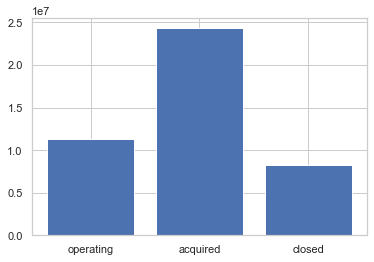

In [384]:
plt.bar(statuses['status'], statuses['mean']);

In Conclusion, not getting enough funding can critically affect the company's chance of success. This indicates that the companies must focus more on finding fundings and investments into their startups.

Regarding the second approach, we will look now at the closed companies that recieved more than one funding round:

Now we will look at the time before the first funding were the fundings for the closed companies. We will ignore the negative signs and consider its absolute values as it might have one date came before the other or it might have been subtracted by 0 in case it received more than one funding on the same day. To solve the negatives problem we will perform the absolute function.

In [114]:
comp_rounds = companies.set_index('company_name')
comp_rounds['time_before_first_fund'] = comp_rounds['time_before_first_fund'].abs()
comp_rounds = comp_rounds.sort_values('time_before_first_fund', ascending=False)


In [115]:
operatingcomp_rounds = comp_rounds[comp_rounds['status'] == 'operating']['time_before_first_fund'][0:5]
operatingcomp_rounds

company_name
Rutgers University            91028 days
University of New Brunswick   83774 days
University of Pittsburgh      83569 days
Georgetown University         82220 days
University of Michigan        71912 days
Name: time_before_first_fund, dtype: timedelta64[ns]

In [116]:
# getting the days as int instead of timedelta64[ns]
operatingDaysGap = []
for i in range(5):
    operatingDaysGap.append(operatingcomp_rounds[i].days)  
operatingDaysGap

[91028, 83774, 83569, 82220, 71912]

In [117]:
closedcomp_rounds = comp_rounds[comp_rounds['status'] == 'closed']['time_before_first_fund'][0:5]
closedcomp_rounds

company_name
The National Urban League   38653 days
Selectron                   19540 days
Signicast                   18060 days
Impact Products             17409 days
Il Bisonte                  16603 days
Name: time_before_first_fund, dtype: timedelta64[ns]

In [118]:
# getting the days as int instead of timedelta64[ns]
closedDaysGap = []
for i in range(5):
    closedDaysGap.append(closedcomp_rounds[i].days)  
closedDaysGap

[38653, 19540, 18060, 17409, 16603]

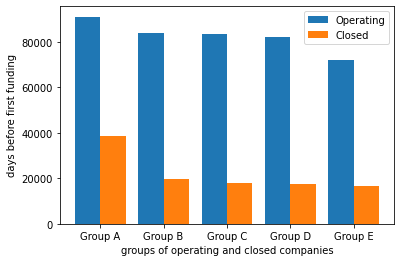

In [119]:
compLabels = ['Group A','Group B','Group C','Group D', 'Group E']
X_axis = np.arange(len(compLabels)) # equivalent to array([0, 1, 2, 3, 4])
plt.bar(X_axis - 0.2, operatingDaysGap, 0.4, label = 'Operating') # width of each bar is 0.4
plt.bar(X_axis + 0.2, closedDaysGap, 0.4, label = 'Closed')
plt.xlabel('groups of operating and closed companies')
plt.ylabel('days before first funding')
plt.legend()
plt.xticks(X_axis, compLabels);

From the plot shown above, it seems the operating companies had bigger gaps between funding and establishment. <br>
so one can safely assume that the time between the company's foundtion and the first funding isn't an effective factor.

In conclusion, time taken to get the first funding can be considered a **non-critical factor in affecting the success of the company**. <br>
It means that the company doesn't heavily rely on that first funding to remain operating.

## Question 2 (Ashraf & Farah)

Regarding the Second Question:  <br>
- 	Which regions (countries) are most probable to have the most failed startups?
    -	For this: We are initially interested in <br> `country_code`, `status`, and `investor_name`


First we need to join the companies dataset with the investments dataset

In [120]:
companies.sort_values(by=['company_name'], inplace=True)
invests.sort_values(by=['company_name'],inplace=True)
comp_invests = companies.join(invests.set_index('company_name'), on='company_name',lsuffix='_left', rsuffix='_right')
comp_invests

,company_permalink_left,company_name,homepage_url,company_category_list_left,funding_total_usd,status,company_country_code_left,company_city_left,funding_rounds,founded_at,...,investor_name,investor_country_code,investor_state_code,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,total_raised
8378,/organization/bratpackstyle-llc,"#BratPackStyle, LLC.",http://www.bratpackstyle.com,Content Discovery|E-Commerce|Fashion|Lifestyle...,0.000000e+00,closed,USA,New York,1,2015-04-19 00:00:00.000000000,...,Nine Inc. LLC.,missing,missing,missing,/funding-round/7f52613bbda1edcaed3844d806d62757,seed,NaN,2015-06-01,1.493930e+07,NaN
24834,/organization/hashoff,#HASHOFF,http://www.hashoff.com,Digital Media|Internet|Social Media,9.550000e+05,operating,USA,Denver,2,2014-04-01 00:00:00.000000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
0,/organization/-fame,#fame,http://livfame.com,Media,1.000000e+07,operating,IND,Mumbai,1,2011-04-12 20:46:43.240577680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
63168,/organization/waywire,#waywire,http://www.waywire.com,Entertainment|News|Politics|Social Media,1.750000e+06,acquired,USA,New York,1,2012-06-01 00:00:00.000000000,...,Oprah Winfrey,missing,missing,missing,/funding-round/cc409188fa2b63482bd9008f682c2efa,seed,NaN,2012-06-30,1.750000e+06,1.750000e+06
63168,/organization/waywire,#waywire,http://www.waywire.com,Entertainment|News|Politics|Social Media,1.750000e+06,acquired,USA,New York,1,2012-06-01 00:00:00.000000000,...,Innovation Endeavors,USA,CA,Palo Alto,/funding-round/cc409188fa2b63482bd9008f682c2efa,seed,NaN,2012-06-30,1.750000e+06,1.750000e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18338,/organization/enso,Еnso.fm,http://enso.fm,Algorithms|Casual Games|Content Discovery|Edis...,2.783840e+04,operating,BGR,Sofia,1,2015-06-29 00:00:00.000000000,...,Axel Springer Plug and Play Accelerator,DEU,16,Berlin,/funding-round/53becfd9582cda62dcb2a6c9970810b3,seed,NaN,2015-07-01,2.783840e+04,2.783840e+04
51421,/organization/shwrm,​Shwrüm,http://www.shwrum.com,Design|Fashion|Internet|Mobile|Shopping|Software,5.000000e+04,operating,USA,Gainesville,1,2013-01-01 00:00:00.000000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
63581,/organization/wested,​WestEd,http://www.wested.org/,Nonprofits,3.000000e+06,operating,USA,San Francisco,1,2010-10-27 20:46:43.240577680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
10952,/organization/chishenma,吃神马 ChiShenMa,http://chishen.ma,Mobile|Restaurants|Specialty Foods,0.000000e+00,operating,CHN,Shanghai,1,2014-01-01 00:00:00.000000000,...,Chinaccelerator,CHN,23,Shanghai,/funding-round/aa4cde05f64453c60ca85a06a962f381,seed,NaN,2014-02-28,1.493930e+07,NaN


In [121]:
comp_invests.T

,8378,24834,0,63168,63168,63168,63168,63168,63168,59865,...,66321,6448,66322,31273,18338,18338,51421,63581,10952,10952
company_permalink_left,/organization/bratpackstyle-llc,/organization/hashoff,/organization/-fame,/organization/waywire,/organization/waywire,/organization/waywire,/organization/waywire,/organization/waywire,/organization/waywire,/organization/tv-communications,...,/organization/Ôasys-2,/organization/berresearch,/organization/İnovatiff-reklam-ve-tanıtım-hizm...,/organization/kutusu-video-ajans,/organization/enso,/organization/enso,/organization/shwrm,/organization/wested,/organization/chishenma,/organization/chishenma
company_name,"#BratPackStyle, LLC.",#HASHOFF,#fame,#waywire,#waywire,#waywire,#waywire,#waywire,#waywire,&TV Communications,...,Ôasys,ÜberResearch,İnovatiff Reklam ve Tanıtım Hizmetleri Tic,İş kutusu video ajansı,Еnso.fm,Еnso.fm,​Shwrüm,​WestEd,吃神马 ChiShenMa,吃神马 ChiShenMa
homepage_url,http://www.bratpackstyle.com,http://www.hashoff.com,http://livfame.com,http://www.waywire.com,http://www.waywire.com,http://www.waywire.com,http://www.waywire.com,http://www.waywire.com,http://www.waywire.com,http://enjoyandtv.com,...,http://www.oasys.io/,http://uberresearch.com,http://inovatiff.com,http://www.iskutusu.com,http://enso.fm,http://enso.fm,http://www.shwrum.com,http://www.wested.org/,http://chishen.ma,http://chishen.ma
company_category_list_left,Content Discovery|E-Commerce|Fashion|Lifestyle...,Digital Media|Internet|Social Media,Media,Entertainment|News|Politics|Social Media,Entertainment|News|Politics|Social Media,Entertainment|News|Politics|Social Media,Entertainment|News|Politics|Social Media,Entertainment|News|Politics|Social Media,Entertainment|News|Politics|Social Media,Games,...,Consumer Electronics|Internet of Things|Teleco...,Curated Web,Consumer Goods|E-Commerce|Internet,3D|Advertising|Online Video Advertising|Video,Algorithms|Casual Games|Content Discovery|Edis...,Algorithms|Casual Games|Content Discovery|Edis...,Design|Fashion|Internet|Mobile|Shopping|Software,Nonprofits,Mobile|Restaurants|Specialty Foods,Mobile|Restaurants|Specialty Foods
funding_total_usd,0.0,955000.0,10000000.0,1750000.0,1750000.0,1750000.0,1750000.0,1750000.0,1750000.0,4000000.0,...,18192.0,0.0,14851.0,100000.0,27838.40363,27838.40363,50000.0,3000000.0,0.0,0.0
status,closed,operating,operating,acquired,acquired,acquired,acquired,acquired,acquired,operating,...,operating,operating,operating,operating,operating,operating,operating,operating,operating,operating
company_country_code_left,USA,USA,IND,USA,USA,USA,USA,USA,USA,USA,...,USA,DEU,missing,TUR,BGR,BGR,USA,USA,CHN,CHN
company_city_left,New York,Denver,Mumbai,New York,New York,New York,New York,New York,New York,Los Angeles,...,San Francisco,Cologne,missing,Istanbul,Sofia,Sofia,Gainesville,San Francisco,Shanghai,Shanghai
funding_rounds,1,2,1,1,1,1,1,1,1,2,...,1,1,1,1,1,1,1,1,1,1
founded_at,2015-04-19 00:00:00,2014-04-01 00:00:00,2011-04-12 20:46:43.240577680,2012-06-01 00:00:00,2012-06-01 00:00:00,2012-06-01 00:00:00,2012-06-01 00:00:00,2012-06-01 00:00:00,2012-06-01 00:00:00,2006-09-09 20:46:43.240577680,...,2014-01-01 00:00:00,2013-01-01 00:00:00,2010-01-06 20:46:43.240577680,2013-01-01 00:00:00,2015-06-29 00:00:00,2015-06-29 00:00:00,2013-01-01 00:00:00,2010-10-27 20:46:43.240577680,2014-01-01 00:00:00,2014-01-01 00:00:00


Now, we will categorize the companies according to their status (oprating, closed, aquired)

In [122]:
closedcomp_invests = comp_invests[comp_invests['status'] == 'closed']
closedcomp_invests

,company_permalink_left,company_name,homepage_url,company_category_list_left,funding_total_usd,status,company_country_code_left,company_city_left,funding_rounds,founded_at,...,investor_name,investor_country_code,investor_state_code,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,total_raised
8378,/organization/bratpackstyle-llc,"#BratPackStyle, LLC.",http://www.bratpackstyle.com,Content Discovery|E-Commerce|Fashion|Lifestyle...,0.0,closed,USA,New York,1,2015-04-19 00:00:00.000000000,...,Nine Inc. LLC.,missing,missing,missing,/funding-round/7f52613bbda1edcaed3844d806d62757,seed,NaN,2015-06-01,1.493930e+07,NaN
11986,/organization/club-domains,.Club Domains,http://nic.club/,Software,7000000.0,closed,USA,Oakland Park,1,2011-10-10 00:00:00.000000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
21439,/organization/fox-networks,.FOX Networks,http://www.dotfox.com,Advertising,4912393.0,closed,missing,missing,1,2003-04-23 20:46:43.240577680,...,Foresight Group,GBR,H9,London,/funding-round/69a1536a6f4506538afd7aa7241ddbe1,undisclosed,NaN,2007-01-16,4.912393e+06,4912393.0
12508,/organization/comdominio,.comDominio,http://www.comdominio.com.br,Internet,0.0,closed,BRA,Brazilia,1,2000-05-19 20:46:43.240577680,...,Stratus Investimentos,missing,missing,missing,/funding-round/f39abc561eeeb14307837363e54d7e16,venture,NaN,2004-02-12,1.493930e+07,NaN
34,/organization/10bestthings,10BestThings,http://10bestthings.com,Curated Web,50000.0,closed,USA,Cleveland,1,2009-04-01 00:00:00.000000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64786,/organization/xkoto,xkoto,http://www.xkoto.com,Software,11035000.0,closed,USA,Waltham,3,2005-01-01 00:00:00.000000000,...,GrandBanks Capital,USA,MA,Wellesley,/funding-round/b91008080714512f7c78656ed27238ab,venture,C,2009-01-26,3.000000e+06,4307000.0
65107,/organization/yes-no,yes.no,http://yes.no,Q&A|Social Network Media,1000000.0,closed,ISR,Tel Aviv,1,2015-01-01 00:00:00.000000000,...,Assaf Levy,ISR,missing,Tel Aviv,/funding-round/e51932c2afebd10c5e8c08b94b57bcb7,seed,NaN,2015-05-01,1.000000e+06,1000000.0
65246,/organization/yoone,yoone,http://yoone.de,Games,197597.0,closed,DEU,Bielefeld,1,2010-11-03 00:00:00.000000000,...,HackFwd,DEU,4,Hamburg,/funding-round/9ee9e539e722753d4fb6b03e7800fb8a,seed,NaN,2010-11-03,1.975970e+05,197597.0
65248,/organization/yoonew,yoonew,http://www.yoonew.com,Curated Web,4000000.0,closed,USA,New York,2,2004-01-01 00:00:00.000000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN


We will group by the country to see the number of companies (of each status) in each country to gain insight if there's a massive difference between the number of operating companies and closed ones in a single country.

In [123]:
closedcomptotal = pd.DataFrame(closedcomp_invests.groupby(['company_country_code_left'])['company_name'].count())
closedcomptotal.drop('missing',inplace=True)
closedcomptotal = closedcomptotal.sort_values('company_name', ascending=False)
closedcomptotal

,company_name
company_country_code_left,
USA,7479
GBR,527
CAN,342
RUS,250
FRA,197
...,...
DOM,1
PRI,1
GHA,1


Here's a heatmap that illustrates the previous dataframe. It shows us clearly that the US has the most closed companies while others have less. We will take a sample of the first 10 and consider the rest outliers (as their values are 1) because it will be hard to visualize them and their valus won't affect the analysis much.

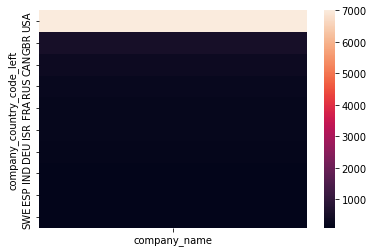

In [124]:
closedcomptotalsample = closedcomptotal.head(10)
sns.heatmap(closedcomptotalsample, vmin=100, vmax=7000);

Now we categorize the operating companies

In [125]:
operatingcomp_invests = comp_invests[comp_invests['status'] == 'operating']
operatingcomp_invests

,company_permalink_left,company_name,homepage_url,company_category_list_left,funding_total_usd,status,company_country_code_left,company_city_left,funding_rounds,founded_at,...,investor_name,investor_country_code,investor_state_code,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,total_raised
24834,/organization/hashoff,#HASHOFF,http://www.hashoff.com,Digital Media|Internet|Social Media,9.550000e+05,operating,USA,Denver,2,2014-04-01 00:00:00.000000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
0,/organization/-fame,#fame,http://livfame.com,Media,1.000000e+07,operating,IND,Mumbai,1,2011-04-12 20:46:43.240577680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
59865,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,Games,4.000000e+06,operating,USA,Los Angeles,2,2006-09-09 20:46:43.240577680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
48652,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,Education|Publishing,6.038500e+04,operating,EST,Tallinn,2,2012-10-26 00:00:00.000000000,...,Startup Wise Guys,EST,1,Tallinn,/funding-round/f28a7e530f9e4b29783d2c0aa4c68c62,seed,NaN,2013-12-01,2.038500e+04,30192.50000
48652,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,Education|Publishing,6.038500e+04,operating,EST,Tallinn,2,2012-10-26 00:00:00.000000000,...,Start-Up Chile,CHL,12,Santiago,/funding-round/f06b420775f7cb6c1541a9db526534bb,seed,NaN,2012-08-09,4.000000e+04,30192.50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18338,/organization/enso,Еnso.fm,http://enso.fm,Algorithms|Casual Games|Content Discovery|Edis...,2.783840e+04,operating,BGR,Sofia,1,2015-06-29 00:00:00.000000000,...,Axel Springer Plug and Play Accelerator,DEU,16,Berlin,/funding-round/53becfd9582cda62dcb2a6c9970810b3,seed,NaN,2015-07-01,2.783840e+04,27838.40363
51421,/organization/shwrm,​Shwrüm,http://www.shwrum.com,Design|Fashion|Internet|Mobile|Shopping|Software,5.000000e+04,operating,USA,Gainesville,1,2013-01-01 00:00:00.000000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
63581,/organization/wested,​WestEd,http://www.wested.org/,Nonprofits,3.000000e+06,operating,USA,San Francisco,1,2010-10-27 20:46:43.240577680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
10952,/organization/chishenma,吃神马 ChiShenMa,http://chishen.ma,Mobile|Restaurants|Specialty Foods,0.000000e+00,operating,CHN,Shanghai,1,2014-01-01 00:00:00.000000000,...,Chinaccelerator,CHN,23,Shanghai,/funding-round/aa4cde05f64453c60ca85a06a962f381,seed,NaN,2014-02-28,1.493930e+07,NaN


We will group by the country and see how many operating companies in each country.

In [126]:
operatingtotal = pd.DataFrame(operatingcomp_invests.groupby(['company_country_code_left'])['company_name'].count())
operatingtotal.drop('missing',inplace=True)
operatingtotal = operatingtotal.sort_values('company_name', ascending=False)
operatingtotal

,company_name
company_country_code_left,
USA,88697
GBR,7645
CAN,3496
IND,3364
CHN,3179
...,...
SEN,1
ROU,1
QAT,1


The heatmap yet again shows that the US has the most operating companies which seems noticable because it also had the most closed companies.We will take a sample of the first 10 and consider the rest outliers (as their values are 1) because it will be hard to visualize them and their valus won't affect the analysis much.

<AxesSubplot:ylabel='company_country_code_left'>

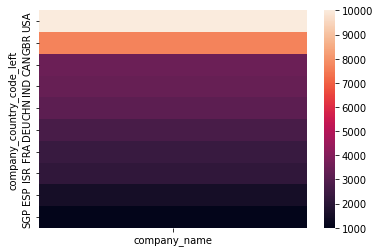

In [127]:
operatingtotalsample = operatingtotal.head(10)
operatingtotalsample
sns.heatmap(operatingtotalsample, vmin=1000, vmax=10000)

After looking in the closed and operating companies we see that we still can't determine if the country has more operting companies than the closed or not, so let's take one country and compare. For example, let's look at the USA since it has the highest number of operating companies and closed companies.

In [128]:
df = comp_invests.loc[comp_invests['company_country_code_left'] == 'USA']
df = pd.DataFrame(df.groupby(['status'])['status'].count())
df

,status
status,
acquired,21176
closed,7479
ipo,5249
operating,88697


The dataframe above shows us how although the US has strong economics and massive amount of investor as seen earlier, it has a bulk of closed companies but compared to operting it's only 0.08 (7956/92228) of it. So, this reflects that The US must have facilities and enough fundings for startups.

If we quickly look at another example and that is the country after the US which is The United Kingdom (GBR) it had 7846 oeprating company with 567 closed companies. Ofcourse, since the US is much bigger the number are biggr but we will look at the ratio between the closed to operating companies to find it 0.07. SIgnificantly it is closed to the US and we can consider that both countries have the same facilities and both show that the lack of investors can affect the companies.

In conclusion, as the ratio the ratio between the closed to operating companies increases, the more dificult it is for a company to start up. This will lead us to look closed into factors that makes those countries a difficult place to start a company.

## Question 3 (Farah)

### Does the number of investors in a country affect the number of successful companies in this country?

First, let's narrow down to the investors that invested in the companies in the same country because there's a posibility that an investor invested in a company in a different country.

In [129]:
comp_investors = invests[invests['company_country_code'] == invests['investor_country_code']]
comp_investors

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_city,investor_permalink,investor_name,investor_country_code,investor_state_code,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,total_raised
160690,/organization/waywire,#waywire,Entertainment|News|Politics|Social Media,USA,NY,New York,/organization/innovation-endeavors,Innovation Endeavors,USA,CA,Palo Alto,/funding-round/cc409188fa2b63482bd9008f682c2efa,seed,NaN,2012-06-30,1.750000e+06,1.750000e+06
160689,/organization/waywire,#waywire,Entertainment|News|Politics|Social Media,USA,NY,New York,/organization/first-round-capital,First Round,USA,CA,San Francisco,/funding-round/cc409188fa2b63482bd9008f682c2efa,seed,NaN,2012-06-30,1.750000e+06,1.750000e+06
160688,/organization/waywire,#waywire,Entertainment|News|Politics|Social Media,USA,NY,New York,/organization/afsquare,AFSquare,USA,CA,Culver City,/funding-round/cc409188fa2b63482bd9008f682c2efa,seed,NaN,2012-06-30,1.750000e+06,1.750000e+06
160693,/organization/waywire,#waywire,Entertainment|News|Politics|Social Media,USA,NY,New York,/person/troy-carter,Troy Carter,USA,missing,Culver City,/funding-round/cc409188fa2b63482bd9008f682c2efa,seed,NaN,2012-06-30,1.750000e+06,1.750000e+06
160691,/organization/waywire,#waywire,Entertainment|News|Politics|Social Media,USA,NY,New York,/person/jeff-weiner,Jeff Weiner,USA,missing,Mountain View,/funding-round/cc409188fa2b63482bd9008f682c2efa,seed,NaN,2012-06-30,1.750000e+06,1.750000e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60815,/organization/gps-optics,µ-GPS Optics,Hardware + Software,DEU,15,Meiningen,/organization/mic-ag,Mic AG,DEU,2,Munich,/funding-round/24c3f275dd46990719a1f82a402d8b5c,venture,NaN,2006-12-01,4.000000e+04,4.000000e+04
168644,/organization/Áeron,ÁERON,missing,missing,missing,missing,/organization/sz-chenyi-capital-fund-management,Széchenyi Capital Fund Management,missing,missing,missing,/funding-round/59f4dce44723b794f21ded3daed6e4fe,venture,A,2014-08-01,1.493930e+07,NaN
168646,/organization/İnovatiff-reklam-ve-tanıtım-hizm...,İnovatiff Reklam ve Tanıtım Hizmetleri Tic,Consumer Goods|E-Commerce|Internet,missing,missing,missing,/person/serkan-erdoğan,Serkan Erdoğan,missing,missing,missing,/funding-round/af942869878d2cd788ef5189b435ebc4,grant,NaN,2013-10-01,1.485100e+04,1.485100e+04
47814,/organization/enso,Еnso.fm,Algorithms|Casual Games|Content Discovery|Edis...,BGR,42,Sofia,/organization/eleven,Eleven,BGR,42,Sofia,/funding-round/53becfd9582cda62dcb2a6c9970810b3,seed,NaN,2015-07-01,2.783840e+04,2.783840e+04


Now, let's merge the new dataset with companies so we can get the status.

In [130]:
comp_investors = comp_investors.join(companies.set_index('company_name'), on='company_name',lsuffix='_left', rsuffix='_right')
comp_investors

,company_permalink_left,company_name,company_category_list_left,company_country_code_left,company_state_code,company_city_left,investor_permalink,investor_name,investor_country_code,investor_state_code,...,company_category_list_right,funding_total_usd,status,company_country_code_right,company_city_right,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund
160690,/organization/waywire,#waywire,Entertainment|News|Politics|Social Media,USA,NY,New York,/organization/innovation-endeavors,Innovation Endeavors,USA,CA,...,Entertainment|News|Politics|Social Media,1.750000e+06,acquired,USA,New York,1.0,2012-06-01 00:00:00.000000000,2012-06-30,2012-06-30,29 days 00:00:00
160689,/organization/waywire,#waywire,Entertainment|News|Politics|Social Media,USA,NY,New York,/organization/first-round-capital,First Round,USA,CA,...,Entertainment|News|Politics|Social Media,1.750000e+06,acquired,USA,New York,1.0,2012-06-01 00:00:00.000000000,2012-06-30,2012-06-30,29 days 00:00:00
160688,/organization/waywire,#waywire,Entertainment|News|Politics|Social Media,USA,NY,New York,/organization/afsquare,AFSquare,USA,CA,...,Entertainment|News|Politics|Social Media,1.750000e+06,acquired,USA,New York,1.0,2012-06-01 00:00:00.000000000,2012-06-30,2012-06-30,29 days 00:00:00
160693,/organization/waywire,#waywire,Entertainment|News|Politics|Social Media,USA,NY,New York,/person/troy-carter,Troy Carter,USA,missing,...,Entertainment|News|Politics|Social Media,1.750000e+06,acquired,USA,New York,1.0,2012-06-01 00:00:00.000000000,2012-06-30,2012-06-30,29 days 00:00:00
160691,/organization/waywire,#waywire,Entertainment|News|Politics|Social Media,USA,NY,New York,/person/jeff-weiner,Jeff Weiner,USA,missing,...,Entertainment|News|Politics|Social Media,1.750000e+06,acquired,USA,New York,1.0,2012-06-01 00:00:00.000000000,2012-06-30,2012-06-30,29 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60815,/organization/gps-optics,µ-GPS Optics,Hardware + Software,DEU,15,Meiningen,/organization/mic-ag,Mic AG,DEU,2,...,Hardware + Software,4.000000e+04,operating,DEU,Meiningen,1.0,2006-01-01 00:00:00.000000000,2006-12-01,2006-12-01,334 days 00:00:00
168644,/organization/Áeron,ÁERON,missing,missing,missing,missing,/organization/sz-chenyi-capital-fund-management,Széchenyi Capital Fund Management,missing,missing,...,missing,0.000000e+00,operating,HUN,missing,1.0,2011-01-01 00:00:00.000000000,2014-08-01,2014-08-01,1308 days 00:00:00
168646,/organization/İnovatiff-reklam-ve-tanıtım-hizm...,İnovatiff Reklam ve Tanıtım Hizmetleri Tic,Consumer Goods|E-Commerce|Internet,missing,missing,missing,/person/serkan-erdoğan,Serkan Erdoğan,missing,missing,...,Consumer Goods|E-Commerce|Internet,1.485100e+04,operating,missing,missing,1.0,2010-01-06 20:46:43.240577680,2013-10-01,2013-10-01,1363 days 03:13:16.759422320
47814,/organization/enso,Еnso.fm,Algorithms|Casual Games|Content Discovery|Edis...,BGR,42,Sofia,/organization/eleven,Eleven,BGR,42,...,Algorithms|Casual Games|Content Discovery|Edis...,2.783840e+04,operating,BGR,Sofia,1.0,2015-06-29 00:00:00.000000000,2015-07-01,2015-07-01,2 days 00:00:00


Then we will categorize our data according to its status.

In [131]:
operatingcomp_invests = comp_investors[comp_investors['status'] == 'operating']
operatingcomp_invests

,company_permalink_left,company_name,company_category_list_left,company_country_code_left,company_state_code,company_city_left,investor_permalink,investor_name,investor_country_code,investor_state_code,...,company_category_list_right,funding_total_usd,status,company_country_code_right,company_city_right,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund
123699,/organization/rock-your-paper,'Rock' Your Paper,Education|Publishing,EST,1,Tallinn,/organization/startup-wise-guys,Startup Wise Guys,EST,1,...,Education|Publishing,6.038500e+04,operating,EST,Tallinn,2.0,2012-10-26 00:00:00.000000000,2012-08-09,2013-12-01,-78 days +00:00:00
25583,/organization/caravelo,( caravelo (,Information Technology|Online Travel,ESP,56,Barcelona,/organization/fundacin-jos-manuel-entrecanales,Fundación José Manuel Entrecanales,ESP,29,...,Information Technology|Online Travel,1.089811e+06,operating,ESP,Barcelona,2.0,2010-05-01 00:00:00.000000000,2012-01-01,2015-07-22,610 days 00:00:00
0,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,/organization/dt-capital-partners,DT Capital Partners,CHN,23,...,Curated Web,2.000000e+06,operating,CHN,Beijing,1.0,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,443 days 00:00:00
2,/organization/01games-technology,01Games Technology,Games,HKG,missing,Hong Kong,/organization/cyberport-hong-kong,Cyberport Hong Kong,HKG,missing,...,Games,4.125000e+04,operating,HKG,Hong Kong,1.0,2010-10-06 20:46:43.240577680,2014-07-01,2014-07-01,1363 days 03:13:16.759422320
30,/organization/1-2-3-listo,"1,2,3 Listo",E-Commerce,CHL,12,Las Condes,/organization/start-up-chile,Start-Up Chile,CHL,12,...,E-Commerce,4.000000e+04,operating,CHL,Las Condes,1.0,2012-01-01 00:00:00.000000000,2013-02-18,2013-02-18,414 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60815,/organization/gps-optics,µ-GPS Optics,Hardware + Software,DEU,15,Meiningen,/organization/mic-ag,Mic AG,DEU,2,...,Hardware + Software,4.000000e+04,operating,DEU,Meiningen,1.0,2006-01-01 00:00:00.000000000,2006-12-01,2006-12-01,334 days 00:00:00
168644,/organization/Áeron,ÁERON,missing,missing,missing,missing,/organization/sz-chenyi-capital-fund-management,Széchenyi Capital Fund Management,missing,missing,...,missing,0.000000e+00,operating,HUN,missing,1.0,2011-01-01 00:00:00.000000000,2014-08-01,2014-08-01,1308 days 00:00:00
168646,/organization/İnovatiff-reklam-ve-tanıtım-hizm...,İnovatiff Reklam ve Tanıtım Hizmetleri Tic,Consumer Goods|E-Commerce|Internet,missing,missing,missing,/person/serkan-erdoğan,Serkan Erdoğan,missing,missing,...,Consumer Goods|E-Commerce|Internet,1.485100e+04,operating,missing,missing,1.0,2010-01-06 20:46:43.240577680,2013-10-01,2013-10-01,1363 days 03:13:16.759422320
47814,/organization/enso,Еnso.fm,Algorithms|Casual Games|Content Discovery|Edis...,BGR,42,Sofia,/organization/eleven,Eleven,BGR,42,...,Algorithms|Casual Games|Content Discovery|Edis...,2.783840e+04,operating,BGR,Sofia,1.0,2015-06-29 00:00:00.000000000,2015-07-01,2015-07-01,2 days 00:00:00


In [132]:
closedcomp_invests = comp_investors[comp_investors['status'] == 'closed']
closedcomp_invests

,company_permalink_left,company_name,company_category_list_left,company_country_code_left,company_state_code,company_city_left,investor_permalink,investor_name,investor_country_code,investor_state_code,...,company_category_list_right,funding_total_usd,status,company_country_code_right,company_city_right,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund
128,/organization/11i-solutions,11i Solutions,Enterprise Software,USA,AL,Huntsville,/organization/steel-pier-capital-advisors,Steel Pier Capital Advisors,USA,NY,...,Enterprise Software,1800000.0,closed,USA,Huntsville,1.0,2007-06-27 20:46:43.240577680,2011-03-22,2011-03-22,1363 days 03:13:16.759422320
238,/organization/1c-company,1C Company,Games|Software|Video Games,RUS,48,Moscow,/organization/baring-vostok-capital-partners,Baring Vostok Capital Partners,RUS,48,...,Games|Software|Video Games,200000000.0,closed,RUS,Moscow,1.0,1991-01-01 00:00:00.000000000,2011-10-03,2011-10-03,7580 days 00:00:00
239,/organization/1cast,1Cast,Content|Lifestyle|News|Video,USA,WA,Kirkland,/organization/eagle-river-holdings,Eagle River Holdings,USA,WA,...,Content|Lifestyle|News|Video,0.0,closed,USA,Kirkland,1.0,2006-06-01 00:00:00.000000000,2008-08-12,2008-08-12,803 days 00:00:00
341,/organization/2100b-com-llc,2100b Sausalito LLC.,Advertising|Direct Marketing|Social Media,USA,CA,Sausalito,/organization/seikouri-inc,"SEIKOURI, Inc.",USA,NY,...,Advertising|Direct Marketing|Social Media,50000.0,closed,USA,Sausalito,2.0,2011-06-15 00:00:00.000000000,2013-01-01,2013-01-01,566 days 00:00:00
422,/organization/25eight,25eight,DIY|Electronics|Software,USA,CA,San Francisco,/organization/innovation-works,Innovation Works,USA,PA,...,DIY|Electronics|Software,25000.0,closed,USA,San Francisco,1.0,2006-05-03 20:46:43.240577680,2010-01-26,2010-01-26,1363 days 03:13:16.759422320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164453,/organization/xlander-ru,xLander.ru,Adventure Travel|Reviews and Recommendations|S...,missing,missing,missing,/organization/aurora-venture-capital-fund,Aurora Venture Capital Fund,missing,missing,...,Adventure Travel|Reviews and Recommendations|S...,1000000.0,closed,missing,missing,1.0,2008-10-09 20:46:43.240577680,2012-07-04,2012-07-04,1363 days 03:13:16.759422320
164443,/organization/xkoto,xkoto,Software,USA,MA,Waltham,/organization/grandbanks-capital,GrandBanks Capital,USA,MA,...,Software,11035000.0,closed,USA,Waltham,3.0,2005-01-01 00:00:00.000000000,2005-11-01,2009-01-26,304 days 00:00:00
164444,/organization/xkoto,xkoto,Software,USA,MA,Waltham,/organization/grandbanks-capital,GrandBanks Capital,USA,MA,...,Software,11035000.0,closed,USA,Waltham,3.0,2005-01-01 00:00:00.000000000,2005-11-01,2009-01-26,304 days 00:00:00
165195,/organization/yes-no,yes.no,Q&A|Social Network Media,ISR,5,Tel Aviv,/person/assaf-levy-3,Assaf Levy,ISR,missing,...,Q&A|Social Network Media,1000000.0,closed,ISR,Tel Aviv,1.0,2015-01-01 00:00:00.000000000,2015-05-01,2015-05-01,120 days 00:00:00


Next, we will group by the investor's country to see how many investors in each country invested in the operating companies.

In [133]:
operatingcomp_investstotal = pd.DataFrame(operatingcomp_invests.groupby(['investor_country_code'])['investor_name'].count())
operatingcomp_investstotal.drop('missing',inplace=True)
operatingcomp_investstotal = operatingcomp_investstotal.sort_values('investor_name', ascending=False)
operatingcomp_investstotal

,investor_name
investor_country_code,
USA,56263
GBR,3412
CHN,1343
CAN,1268
FRA,1227
...,...
CYP,1
LUX,1
PSE,1


Let's visualize our findinfs through a sample of the dataframe

<AxesSubplot:ylabel='investor_country_code'>

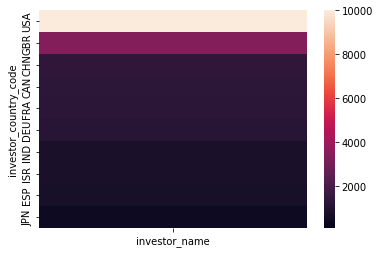

In [134]:
operatingcomp_investstotal = operatingcomp_investstotal.head(10)
sns.heatmap(operatingcomp_investstotal, vmin=100, vmax=10000)

We will do the same for the closed companies

In [135]:
closedcomp_investstotal = pd.DataFrame(closedcomp_invests.groupby(['investor_country_code'])['investor_name'].count())
closedcomp_investstotal.drop('missing',inplace=True)
closedcomp_investstotal = closedcomp_investstotal.sort_values('investor_name', ascending=False)
closedcomp_investstotal

,investor_name
investor_country_code,
USA,4784
GBR,261
CAN,130
RUS,97
FRA,88
ISR,74
DEU,70
SWE,38
ESP,34


<AxesSubplot:ylabel='investor_country_code'>

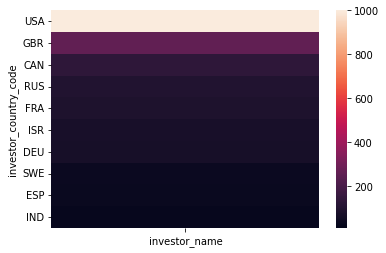

In [136]:
closedcomp_investstotal = closedcomp_investstotal.head(10)
sns.heatmap(closedcomp_investstotal, vmin=10, vmax=1000)

We can see from the data obtained how the number of investors in general in the closed companies is significantlly lower than the those who invested in the operating ones. This can be seen by establishing a ratio between the investors in closed companies to the investors in the operating companies and we will see the difference.

In [137]:
ratio_df = operatingcomp_investstotal/closedcomp_investstotal
ratio_df

,investor_name
investor_country_code,
CAN,9.753846
CHN,NaN
DEU,16.771429
ESP,21.970588
FRA,13.943182
GBR,13.072797
IND,29.769231
ISR,10.324324
JPN,NaN


Constructing a ratio between the number of investors who invested in the operating companies and the investors who invested in closed companies and it is clearly seen that all of the ratios are > than 1 which means that more investors invested in those companies that helped them in sustaining being operating. 

In conclusion, investing plays an important part in keeping the company operating. As the number of investors increases, the chance of success increases.

## Rest of Questions (Aisha)

Heads-up: 
1) Here I didn't use the cleaned dataset version, as we can infer some insights from the null values
2)Some of the data could have been better if they were represented in charts but due to their data types it wasn't really possible and some of the others with favorable data types had labelling merging with one another making it impossible to read.

### Question 4 : Analyzing Funding Rounds

We'll check the number of times funding is repeated overall irrespective of the differenece in company status and then we will see the company statuses.

#### Companies data set

In [138]:
import pandas as pd
df=pd.read_csv('datasets/startups/companies.csv')
df.head()


,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,/organization/-fame,#fame,http://livfame.com,Media,10000000,operating,IND,16,Mumbai,Mumbai,1,NaN,1/5/2015,1/5/2015
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,DE - Other,Delaware City,2,9/4/2014,3/1/2014,10/14/2014
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878,operating,NaN,NaN,NaN,NaN,1,NaN,1/30/2014,1/30/2014
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,2000000,operating,CHN,22,Beijing,Beijing,1,1/1/2007,3/19/2008,3/19/2008
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,1/1/2010,7/24/2014,7/24/2014


In [139]:
df.drop(['state_code', 'region'],axis=1,inplace=True)
df['first_funding_at']=df['first_funding_at'].fillna("not available")
df.head()

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,/organization/-fame,#fame,http://livfame.com,Media,10000000,operating,IND,Mumbai,1,NaN,1/5/2015,1/5/2015
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,Delaware City,2,9/4/2014,3/1/2014,10/14/2014
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878,operating,NaN,NaN,1,NaN,1/30/2014,1/30/2014
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,2000000,operating,CHN,Beijing,1,1/1/2007,3/19/2008,3/19/2008
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,-,operating,USA,Champaign,1,1/1/2010,7/24/2014,7/24/2014


Text(0.5, 1.0, 'status difference')

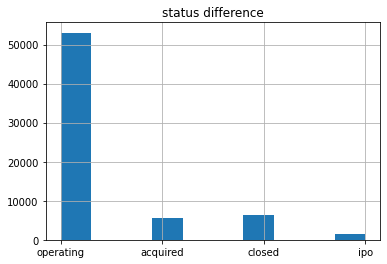

In [140]:
import matplotlib.pyplot as plt
df.status.hist()
plt.title('status difference')

As the histogram above shows, we have more companies operating as compared to acquired ones which would imply that they received far more funding and produced more than those which were acquired.

#### IPO companies?

It's a situation in which one starts a business by soliciting capital from family, friends, and investors in exchange for a portion of the company. We go to an investor bank and inform them about the idea or product to raise money for this company. They will then introduce us to institutional investors / people who are interested in this idea or product, and they will sell some of the business's shares to assist in bringing the company to the public market. This helps raise a lot of money, sell shares at a reasonable price that suits the shareholder, raise more money through additional rounds of investment, and promote the brand because IPOs deliver a good credibility boost.
The disadvantages include:
When it comes to matters like openness, the SEC (Securities and Exchange Commission is the US federal agency in charge of regulating and managing financial markets) and exchanges have stringent criteria. As a result, public firms are required to reveal a great deal of business-related information, which may result in competitors obtaining access to material that is the company's trade secret.
Less control as shareholders will now affect decision making.


We'll now separate companies in to 3 status categories; operating, acquired, and ipo. Then we'll compare the funding rounds based on these statuses.

In [141]:
operating=df.loc[df['status']=='operating']
acquired=df.loc[df['status']=='acquired']
ipo=df.loc[df['status']=='ipo']

#### 1-Operating companies

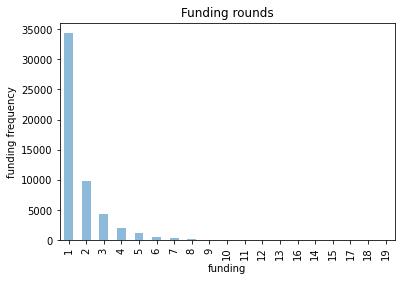

In [142]:

import matplotlib.pyplot as plt
operating.funding_rounds.value_counts().plot(kind="bar",alpha=0.5)
plt.title('Funding rounds')
plt.xlabel('funding')
plt.ylabel('funding frequency') 
plt.show()

The above curve can be matched to the values below and we can deduce that operating companies get more one time funding rounds that two.

In [143]:
operating['funding_rounds'].value_counts()

1     34367
2      9871
3      4366
4      2066
5      1119
6       554
7       312
8       150
9        91
10       55
11       31
12       24
13       11
16        5
14        4
15        3
17        2
18        2
19        1
Name: funding_rounds, dtype: int64

Now we will see how this differs from acquired companies.

#### 2-Acquired companies 

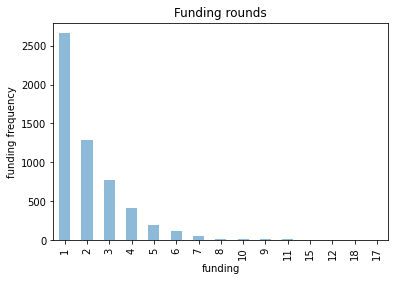

In [144]:
#acquired companies

plt.title('funding rounds for aqcuired companies')
acquired.funding_rounds.value_counts().plot(kind="bar",alpha=0.5)
plt.title('Funding rounds')
plt.xlabel('funding')
plt.ylabel('funding frequency') 
plt.show()

This can be confirmed and further understood with the values below.

In [145]:
acquired['funding_rounds'].value_counts()

1     2664
2     1287
3      772
4      411
5      194
6      115
7       54
8       15
10      13
9       11
11       9
15       1
12       1
18       1
17       1
Name: funding_rounds, dtype: int64

As we can see, both operating and acquired companies get more one time funding rounds than 2 with operating companies having by far the largest fundings. For IPO companies is illustrated below.

#### 3-IPO companies

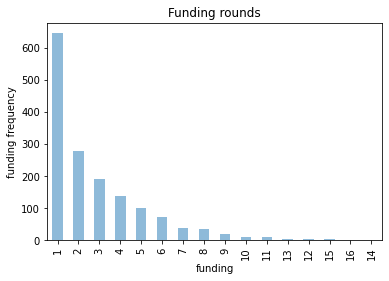

In [146]:
#ipo companies
import matplotlib.pyplot as plt

plt.title('funding rounds for IPO companies')
ipo.funding_rounds.value_counts().plot(kind="bar",alpha=0.5)
plt.title('Funding rounds')
plt.xlabel('funding')
plt.ylabel('funding frequency') 
plt.show()

In [147]:
ipo['funding_rounds'].value_counts()

1     646
2     277
3     192
4     137
5     100
6      72
7      39
8      36
9      18
10     10
11      9
13      4
12      3
15      2
16      1
14      1
Name: funding_rounds, dtype: int64

We can conclude that operating companies exceed in founding rounds but all have higher one time fundings.

#### Investments data set part

In [148]:
d=pd.read_csv('datasets/startups/investments.csv')
d.head()


,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/organization/dt-capital-partners,DT Capital Partners,CHN,23,Shanghai,Shanghai,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,3/19/2008,2000000.0
1,/organization/004-technologies,004 Technologies,Software,USA,IL,"Springfield, Illinois",Champaign,/organization/venturecapital-de,VCDE Venture Partners,DEU,5,Frankfurt,Frankfurt,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,7/24/2014,NaN
2,/organization/01games-technology,01Games Technology,Games,HKG,NaN,Hong Kong,Hong Kong,/organization/cyberport-hong-kong,Cyberport Hong Kong,HKG,NaN,Hong Kong,Hong Kong,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,undisclosed,NaN,7/1/2014,41250.0
3,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/organization/capital-one,Capital One,USA,VA,"Washington, D.C.",Mclean,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,11/9/2015,20000000.0
4,/organization/0xdata,H2O.ai,Analytics,USA,CA,SF Bay Area,Mountain View,/organization/nexus-venture-partners,Nexus Venture Partners,USA,CA,SF Bay Area,Menlo Park,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,NaN,5/22/2013,3000000.0


In [149]:
d.drop([ 'company_state_code','company_region','investor_state_code','investor_region'],axis=1,inplace=True)
d['raised_amount_usd']=d['raised_amount_usd'].fillna("not available")
d['funding_round_code']=d['funding_round_code'].fillna("not available")
d['company_country_code']=d['company_country_code'].fillna("not provided")
d['investor_country_code']=d['investor_country_code'].fillna("not provided")
d.head()

,company_permalink,company_name,company_category_list,company_country_code,company_city,investor_permalink,investor_name,investor_country_code,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/0-6-com,0-6.com,Curated Web,CHN,Beijing,/organization/dt-capital-partners,DT Capital Partners,CHN,Shanghai,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,3/19/2008,2000000.0
1,/organization/004-technologies,004 Technologies,Software,USA,Champaign,/organization/venturecapital-de,VCDE Venture Partners,DEU,Frankfurt,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,not available,7/24/2014,not available
2,/organization/01games-technology,01Games Technology,Games,HKG,Hong Kong,/organization/cyberport-hong-kong,Cyberport Hong Kong,HKG,Hong Kong,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,undisclosed,not available,7/1/2014,41250.0
3,/organization/0xdata,H2O.ai,Analytics,USA,Mountain View,/organization/capital-one,Capital One,USA,Mclean,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,11/9/2015,20000000.0
4,/organization/0xdata,H2O.ai,Analytics,USA,Mountain View,/organization/nexus-venture-partners,Nexus Venture Partners,USA,Menlo Park,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,not available,5/22/2013,3000000.0


In [150]:
d.drop_duplicates(subset=['company_country_code'])
d.drop_duplicates(subset=['investor_country_code'])
d.head()

,company_permalink,company_name,company_category_list,company_country_code,company_city,investor_permalink,investor_name,investor_country_code,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/0-6-com,0-6.com,Curated Web,CHN,Beijing,/organization/dt-capital-partners,DT Capital Partners,CHN,Shanghai,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,3/19/2008,2000000.0
1,/organization/004-technologies,004 Technologies,Software,USA,Champaign,/organization/venturecapital-de,VCDE Venture Partners,DEU,Frankfurt,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,not available,7/24/2014,not available
2,/organization/01games-technology,01Games Technology,Games,HKG,Hong Kong,/organization/cyberport-hong-kong,Cyberport Hong Kong,HKG,Hong Kong,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,undisclosed,not available,7/1/2014,41250.0
3,/organization/0xdata,H2O.ai,Analytics,USA,Mountain View,/organization/capital-one,Capital One,USA,Mclean,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,11/9/2015,20000000.0
4,/organization/0xdata,H2O.ai,Analytics,USA,Mountain View,/organization/nexus-venture-partners,Nexus Venture Partners,USA,Menlo Park,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,not available,5/22/2013,3000000.0


#### Question 5: How many investors do we have in different countries and which country dominates?

We will do this by checking the amount of times country codes repeat in the investor tables and the company country location names which could tell a little more about the country's financial and business status.

In [151]:
d.investor_country_code.value_counts()

USA             96341
not provided    30939
GBR              7616
DEU              3256
FRA              3007
                ...  
TTO                 1
MAR                 1
IRN                 1
BAH                 1
GIB                 1
Name: investor_country_code, Length: 99, dtype: int64

In [152]:
d.company_country_code.value_counts()

USA             112283
not provided     10521
GBR               8579
CAN               4009
CHN               3778
                 ...  
NPL                  1
MDA                  1
ALB                  1
GGY                  1
MCO                  1
Name: company_country_code, Length: 126, dtype: int64

The above data shows that we have more investors in the USA and companies receiving investments as compared to other countries.
We can deduce that this country has a better financial and business status as compared to the rest making it appear like pool of gain for investors.

#### Which investor dominates the market?

In [153]:
d['investor_name'].value_counts()

Sequoia Capital               1033
Wayra                          936
500 Startups                   932
New Enterprise Associates      902
Intel Capital                  861
                              ... 
Shazad Mohammed                  1
Rick Gibson                      1
Smurfit Family Investments       1
Naren Nachiappan                 1
Serkan Erdoğan                   1
Name: investor_name, Length: 30189, dtype: int64

As we can see, Sequoia Capital dominates the market. Wayra and 500 Startups seem to be quit close in count from which we could deduce that they are competitors just like the rest of the companies in the list but the fact that their count have a 4 point gap could mean that they follow up on one another.

#### Question 6: Which company is most famous amongst investors?

In [154]:
d['company_name'].value_counts()

Uber                                          64
DocuSign                                      61
Fab                                           61
Pinterest                                     60
Mattermark                                    59
                                              ..
Kirondo                                        1
Kiras Kiss                                     1
Kipu Systems                                   1
Kippt                                          1
İnovatiff Reklam ve Tanıtım Hizmetleri Tic     1
Name: company_name, Length: 44578, dtype: int64

The above data shows that the Uber company dominates the market with DocuSign and Fab having the same count which may infere that one is as trust worth as the other. The fact Uber is at the top of the list also tells us that this company has a lot of credibility in the eyes of investors. 

#### Question 7: What about these company's specialization as compared to investment?Which category (field) attracts more funding? 

 We will check the category list for both companies and investments dataframes.

In [155]:
#companies
df = df[df.category_list!= 'NaN']
df.category_list.value_counts()

Software                                                                       3995
Biotechnology                                                                  3615
E-Commerce                                                                     1332
Mobile                                                                         1177
Clean Technology                                                               1133
                                                                               ... 
Consumer Internet|Marketplaces|Mobile|Mobile Payments|Transportation|Travel       1
Apps|Mobile|Private Social Networking                                             1
Cloud Computing|Enterprise Software|Infrastructure|PaaS|Social Media              1
Content|SaaS|Social Media Marketing|Software                                      1
Consumer Goods|E-Commerce|Internet                                                1
Name: category_list, Length: 27296, dtype: int64

In [156]:
#investments
d = d[d.company_category_list!= 'NaN']
d.company_category_list.value_counts()

Biotechnology                                               10041
Software                                                     8931
Mobile                                                       3178
Enterprise Software                                          3002
E-Commerce                                                   2980
                                                            ...  
Curated Web|E-Commerce|Online Reservations|Online Travel        1
Hedge Funds|Market Research|Trading                             1
Curated Web|Home & Garden                                       1
E-Commerce|Furniture|Home & Garden|Lighting                     1
Consumer Goods|E-Commerce|Internet                              1
Name: company_category_list, Length: 19453, dtype: int64

As we can see, although biotechnology is more ofinterest to investors, companies seem to have more interest in software which could be due to expensive and delicate nature of biotechnology.

#### Question 8: Are most of the investors also acquirers?

In [157]:
p=pd.read_csv("datasets/startups/acquisitions.csv")
p.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,acquirer_permalink,acquirer_name,acquirer_category_list,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquired_at,acquired_month,price_amount,price_currency_code
0,/organization/003-ru,003.RU,Consumer Electronics|Electronics|Internet,RUS,48,Moscow,Moscow,/organization/media-saturn,Media Saturn,Enterprise Software|Media|Sales and Marketing,ESP,56,Barcelona,Barcelona,7/23/2012,2012-07,NaN,USD
1,/organization/0958572-b-c-ltd,0958572 B.C. Ltd.,NaN,NaN,NaN,NaN,NaN,/organization/atlas-intellectual-property-mana...,ATLAS Intellectual Property Management Co.,Finance|FinTech|Mobile|Telecommunications,USA,WA,Seattle,Seattle,2/2/2012,2012-02,9000000.0,USD
2,/organization/1-800-communications,1-800 Communications,NaN,USA,NY,Long Island,Hicksville,/organization/carsdirect-com,CarsDirect.com,E-Commerce,USA,CA,Los Angeles,El Segundo,6/12/2005,2005-06,NaN,USD
3,/organization/1-800-contacts,1-800 Contacts,Consumer Goods|Retail,USA,UT,Salt Lake City,Draper,/organization/thomas-h-lee-partners,Thomas H. Lee Partners,Business Development|Impact Investing|Investme...,USA,MA,Boston,Boston,1/7/2014,2014-01,NaN,USD
4,/organization/1-844-446-4460-pogo-customer-ser...,Games Support +1-800-311-5934 Pogo Games techn...,NaN,NaN,NaN,NaN,NaN,/organization/pogo-customer-service-number-1-8...,Games Support +1-800-311-5934 Pogo Games techn...,NaN,USA,NY,New York City,Mamaroneck,2/2/2001,2001-02,NaN,USD


In [158]:
p.drop(['company_state_code', 'company_region','acquirer_state_code','acquirer_region'],axis=1,inplace=True)
p['company_category_list']=p['company_category_list'].fillna("not provided")
p['company_country_code']=p['company_country_code'].fillna("not provided")


p.head()

,company_permalink,company_name,company_category_list,company_country_code,company_city,acquirer_permalink,acquirer_name,acquirer_category_list,acquirer_country_code,acquirer_city,acquired_at,acquired_month,price_amount,price_currency_code
0,/organization/003-ru,003.RU,Consumer Electronics|Electronics|Internet,RUS,Moscow,/organization/media-saturn,Media Saturn,Enterprise Software|Media|Sales and Marketing,ESP,Barcelona,7/23/2012,2012-07,NaN,USD
1,/organization/0958572-b-c-ltd,0958572 B.C. Ltd.,not provided,not provided,NaN,/organization/atlas-intellectual-property-mana...,ATLAS Intellectual Property Management Co.,Finance|FinTech|Mobile|Telecommunications,USA,Seattle,2/2/2012,2012-02,9000000.0,USD
2,/organization/1-800-communications,1-800 Communications,not provided,USA,Hicksville,/organization/carsdirect-com,CarsDirect.com,E-Commerce,USA,El Segundo,6/12/2005,2005-06,NaN,USD
3,/organization/1-800-contacts,1-800 Contacts,Consumer Goods|Retail,USA,Draper,/organization/thomas-h-lee-partners,Thomas H. Lee Partners,Business Development|Impact Investing|Investme...,USA,Boston,1/7/2014,2014-01,NaN,USD
4,/organization/1-844-446-4460-pogo-customer-ser...,Games Support +1-800-311-5934 Pogo Games techn...,not provided,not provided,NaN,/organization/pogo-customer-service-number-1-8...,Games Support +1-800-311-5934 Pogo Games techn...,NaN,USA,Mamaroneck,2/2/2001,2001-02,NaN,USD


Now we'll count the frequency of appearance of acquirer names to determine which one of them is also an investor and compare it to the company names to figure out if the same companies are famous with investors too in this data set.

In [159]:
p.acquirer_name.value_counts()

Cisco                                    193
Google                                   176
Microsoft                                161
IBM (International Business Machines)    138
Yahoo!                                   118
                                        ... 
Prime Active Capital                       1
Wilcon                                     1
Eco Green Auto Clean                       1
Iotum                                      1
2000                                       1
Name: acquirer_name, Length: 9475, dtype: int64

In [160]:
p.company_name.value_counts()

Unveil Technologies              6
Ufree                            6
California Apostille Services    5
Travel Channel                   4
Ziff Davis                       4
                                ..
Focal Labs                       1
Focus                            1
Focus Group                      1
Focus Systems                    1
USA                              1
Name: company_name, Length: 18503, dtype: int64

Shockingly, the first to top the list is Cisco unlike in the investor data set where Sequoia Capital tops the list. Also, it can be noticed that the companies which have had the most share acquisitions are Unveil Technologies and Ufree.

#### Footnote: What can some of the null or missing values infer?

To do this we'll check the total missing values in the acquisitions data set.

In [161]:
p.isna().sum()

company_permalink             0
company_name                  1
company_category_list         0
company_country_code          0
company_city               4911
acquirer_permalink            1
acquirer_name                 1
acquirer_category_list     2389
acquirer_country_code      1171
acquirer_city              1360
acquired_at                  13
acquired_month               15
price_amount              13957
price_currency_code           7
dtype: int64

* The null values in the price_amount column may mean that the acquisition process have not being completed, was cancelled, or the files containing this information are not available.

* Null in company_city may point out that either the location of the company is unexact or that the acquisition process was cancelled. The reverse may be true in case with the acquirer_city.

# Answering Questions By Web Scraping

## Scraping Steps done for the rest of the questions (Used [Apollo](https://app.apollo.io/#/) )

### Steps for obtaining cookies: <br>
Sign up on Apollo, and then open the main page, and follow these steps:

Step 0: <br>
<img src="Phase 2/apollo0.png" width=300>

Step 1: <br>
<img src="Phase 2/apollo1.png" width=400>

Step 2 & 3: <br>
<img src="Phase 2/apollo2.png" width=400>

Step 4: <br>
<img src="Phase 2/apollo3.png" width=500>

Step 5: <br>
<img src="Phase 2/apollo4.png" width=300>

### Code:

In [162]:
companiesC = pd.read_csv("datasets/startupsCleaned/companiesCleaned.csv", parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'time_before_first_fund'])

In [163]:
headers = {
        "Content-Type": "application/json",
        "Cookie": "zp__initial_utm_source=www.google.com; ZP_Pricing_Split_Test_Variant=21Q3_EC_V49; __stripe_mid=06eaafd7-76d2-4770-908b-d8f07c1cbebe36217d; drift_aid=894ff341-9c75-424b-a0b1-4b8f79432cee; driftt_aid=894ff341-9c75-424b-a0b1-4b8f79432cee; GCLB=CKvHg8ibj4-lSg; drift_campaign_refresh=d9170960-a05f-42c2-ba9a-78b2101a0d03; remember_token_leadgenie_v2=IjYyNzJiY2EzYzUyODZmMDBmNTk1OGQzYV9sZWFkZ2VuaWVjb29raWVoYXNoIg==--be0341a530e3503f6c70c148746898bb6bfff89f; app_token=50e2ead7f035b1b4bfeabd4df560628f; zp__utm_source=accounts.google.com; drift_eid=6272bca3c5286f00f5958d3a; X-CSRF-TOKEN=IoCHQJkGov78uGd85Tyvd8pU3R71X9kpmMeSZN07rLrxxFMq+rbBmtbcZWCh8aU13yi9oTw8LTrqovrJpZELJg==; _leadgenie_session=RVBYT0t3ZmpPQXJKa3h4MVFuMFR2Sy9MMllTQTYxMlZXT1hJcE5CUmFPYSt2N1BqbVdNSElvWFZFZFphRjBQQld3MTZPQjlMZ3AwTHpXZXhLZm5ob1RxWnJOSXJEcVRPa2lGUDdJeXM5VllrQmx1THhnUmlqMmg3T0xGNEVpVG55OGRTNnQvSFowUUR1dzhFdTNERXZ3PT0tLXF3dWxxZ2RsV1hSRHl6cklJOHJlY0E9PQ==--4be95298d42bde7502dbd1c813100ffaff01ca0b; __stripe_sid=7bad678d-16d3-4a39-9b09-02a62fbbd1c73e0f1d",
        "Origin": "https://app.apollo.io",
        "Referer": "https://app.apollo.io/",
    }

In [164]:
session = requests.Session()
lock = threading.Lock()
def searchByUrl(homepage_url):
    """
    Searches for the company in Apollo's API using the homepage_url, and retreives its ID 
    Note: homepage_url was used instead of the company's name as sometimes, Apollo doesn't retrieve the correct company using the name
    """
    url = "https://app.apollo.io/api/v1/omnisearch/search"
    data = {
        "query":f"{homepage_url}",
        "num_fetch_result":1,
        "cacheKey":1650463168797
    }
    try:
        lock.acquire()
        response = session.post(url, headers=headers, data=json.dumps(data), timeout=5)
        lock.release()
    except:
        lock.release()
        return "ACCOUNT BLOCKED"

    try:
        if not len(response.json()['organizations']):
            return "NOT FOUND"
        else:
            return response.json()['organizations'][0]['id']
    except:
        return "ACCOUNT BLOCKED"
    

In [165]:
lock = threading.Lock()
def getCompany(id):
    """
    Returns Company Info by using the ID (of Apollo website) retrieved from searchByURL()
    """
    if id in ["NOT FOUND", "ACCOUNT BLOCKED"]:
        return "NOT FOUND"
    else:
        url = 'https://app.apollo.io/api/v1/organizations/'+id
        try:
            lock.acquire()
            response = session.get(url, headers=headers, timeout=5)
            lock.release()
        except:
            lock.release()
            return "NOT FOUND"
        return response.text

In [166]:
import threading
from threading import Thread
import time
lock = threading.Lock()

def getCompanyInfo(idx, searchTerm):
    """
    Converts `res` to dictionary, and appends the following values as a tuple in 
    global variable `compInfoTups` (note that these data are for the company in the companiesC dataframe where the index = `idx`):
    * idx (stored again, so that when we create a dataframe from this list of tuples, we can use the `index` column to join the scraped info with companiesC)
    * estimated_num_employees in a company
    * country where company is stationed
    * number of technologies used by the company
    * company's annual_revenue
    """
    res = getCompany(searchByUrl(searchTerm))
    try:
        res = json.loads(res) #converts json string to dictionary called `res`
    except:
        print('NO', idx)
        return None #usually returns None if getCompany() returns "NOT FOUND"
    print('YES', idx)
    try:
        employee_count = res['organization']['estimated_num_employees']
    except:
        employee_count = np.NaN
    try:
        country = res['organization']['country']
    except:
        country = np.NaN #This should have been: "", but we discovered that after we were unable to scrape again (due to getting blocked)
    try:
        number_of_technologies = len(res['organization']['technology_names'])
    except:
        number_of_technologies = np.NaN
    try:
        annual_rev = res['organization']['annual_revenue']
    except:
        annual_rev = np.NaN
    lock.acquire()
    compInfoTups.append((idx, employee_count, country, number_of_technologies, annual_rev))
    lock.release()


In [167]:
df1 = companiesC.loc[0:10000]
df2 = companiesC.loc[30001:30010]
#df2 = companiesC.loc[30001:40000]
#df2 = companiesC.loc[30001:61267]

In [168]:
def startThreads():
    """
    two loops:
    inner loop scraps ten companies parallely (using threads)
    outer loop fetches the next 10 rows to be scraped (using j += i*10),
    you can adjust the range() in the outer loop to suit the companies that you want to get scraped info for in companiesC
    """
    for i in range(1): 
        threads = []
        global compInfoTups #global in order to be visible to getCompanyInfo()
        compInfoTups = []
        try:
            for j in range(10):
                j += i*10
                searchTerm = df2['homepage_url'][j+30001]
                th = Thread(target=getCompanyInfo, args=(j+30001, searchTerm))
                threads.append(th)
                th.start()
            for th in threads: # means that all of the threads have to finish to enter the next iteration in the outer for loop
                th.join()
        finally:
            dfTups = pd.DataFrame(compInfoTups, columns=['index', 'employee_count', 'country', 'number_of_technologies', 'annual_rev'])
            dfTups.to_csv('Scrapped Companies/scrapped_companies_test.csv', mode='a', index=False, header=False)

Note that startThreads() has been adjusted to retrieve only 10 rows (from 30001 to 30010) to display the output when running all cells <br>
But before, it was used to retrieve 10k rows at a time and store them in csv files. <br>
For example, `scrapped_companies_1.csv` contains approximately all rows from index 0 to 10000, <br>
`scrapped_companies_2.csv` should have contained  rows from index 10001 to 20000, and so on.

In [169]:
startThreads()

NO 30001
YES 30002
YES 30003
YES 30004
YES 30005
YES 30006
YES 30007
YES 30008
YES 30009
YES 30010


In [170]:
compInfoTups

[(30002, 0, 'United States', 0, nan),
 (30003, 5, 'United States', 1, 195000.0),
 (30004, 14, 'United States', 7, 5000000.0),
 (30005, 0, None, 1, nan),
 (30006, 10, 'United States', 3, 25000000.0),
 (30007, 11, 'United States', 9, 3328000.0),
 (30008, 2, 'Ecuador', 6, nan),
 (30009, 0, 'Germany', 4, nan),
 (30010, 30, 'United States', 12, 11232000.0)]

### Side notes: failed attempts


Note 1: Notice that in the folder `Scrapped Companies`, you will only find `scrapped_companies_1.csv`, 4, and 5 (not complete) <br>
This was because initially, we were going to split first 3 10k rows on Farah's PC, and the last 3 10k rows on my PC (as Aisha had poor internet connection) <br>
However, all the accounts that we used (to get cookies) got blocked (by Apollo's server) after we retrieved rows from 0 to 10k, and 30k to 40k, <br>
and very few rows from 40k to 50k

Note 2: The `getCompanyInfo()` and `startThreads()` was initially this for loop:

In [171]:
testTups = []

for i in range(5): #len(df2)
    res = getCompany(searchByUrl(df1['homepage_url'][i]))
    emp = re.search(r"\"estimated_num_employees\" :([0-9]+)" , res)
    if emp is not None:
        employee_count = emp.group(1)
    elif emp is None:
        employee_count = np.NaN

    country = re.search(r"(\"country\"\:)\"(\w+.*)\"\,\"o" , res)
    if country is not None:
        country_extracted = country.group(2)
    elif country is None:
        country_extracted = ""

    tech = re.findall(r"\"current_technologies\"\:.*\]" , res)
    tech = re.findall(r"\"name\"\:", str(tech))
    tech_count = sum('name' in t for t in tech)

    revenue = re.search(r"\"annual_revenue\"\:([0-9]+)" , res)
    if revenue is not None:
        revenue_extracted = revenue.group(1)
    elif revenue is None:
        revenue_extracted = np.NaN
    testTups.append((employee_count, country_extracted, tech_count, revenue_extracted))

We changed it because of 2 things:
1. It took a very long time to scrape very few amount of rows
    - So we introduced multi-threading
2. The regex was hard to read
    - So we changed it to accessing keys of a dictionary <br> when we discovered that `json.loads(res)` converts a string (response.text) to dictionary

However, the regex still works:

In [172]:
testTups

[(nan, 'India', 1, '1500000'),
 (nan, 'United States', 3, nan),
 (nan, 'Japan', 10, nan),
 (nan, 'Morocco', 5, nan),
 (nan, 'Germany', 10, '5000000')]

### Concatenating the scraped csv files and joining them with `CompaniesC`

In [173]:
companiesS1 = pd.read_csv("Scrapped Companies/scrapped_companies_1.csv")
companiesS4 = pd.read_csv("Scrapped Companies/scrapped_companies_4.csv")
companiesS5 = pd.read_csv("Scrapped Companies/scrapped_companies_5.csv")
companiesS = pd.concat([companiesS1, companiesS4, companiesS5])
companiesS

,index,employee_count,country,number_of_technologies,annual_rev
0,0,57,India,1,1.500000e+06
1,1,4,United States,3,NaN
2,2,18,Japan,10,NaN
3,3,0,Morocco,5,NaN
4,4,67,Germany,10,5.000000e+06
...,...,...,...,...,...
295,40326,0,United States,1,2.000000e+06
296,40327,6000,United States,26,2.436989e+09
297,40328,0,United States,0,NaN
298,40329,0,United States,1,NaN


In [174]:
companiesC['index'] = companiesC.index
companiesCS = pd.merge(companiesC, companiesS, how='inner', on='index')
companiesCS.drop(['index'], axis=1, inplace=True)

In [175]:
companiesCS.head(3)

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund,employee_count,country,number_of_technologies,annual_rev
0,/organization/-fame,#fame,http://livfame.com,Media,10000000.0,operating,IND,Mumbai,1,2011-04-12 20:46:43.240577680,2015-01-05,2015-01-05,1363 days 03:13:16.759422320,57,India,1,1500000.0
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000.0,operating,USA,Delaware City,2,2014-09-04 00:00:00.000000000,2014-03-01,2014-10-14,-187 days +00:00:00,4,United States,3,NaN
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878.0,operating,JPN,missing,1,2010-05-07 20:46:43.240577680,2014-01-30,2014-01-30,1363 days 03:13:16.759422320,18,Japan,10,NaN


### Imputing `missing` country values from `country` column

We have 1167 missing country codes in `companiesCS`

In [176]:
companiesCS[companiesCS['company_country_code'] == 'missing'].shape

(1167, 17)

And we have 15843 countries in `companiesCS`

In [177]:
len(companiesCS) - companiesCS['country'].isnull().sum()

15843

Let's see the rows where there are country names but no country codes

In [178]:
companiesCS[(companiesCS['company_country_code'] == 'missing') & (companiesCS['country'].notna())].shape

(1062, 17)

Thankfully, we were able to retrieve most of the missing countries (1062 out of 1167):

In [179]:
import pycountry
def toAlphaCode3(row):
    if row['company_country_code'] != 'missing' or type(row['country']) == type(np.nan): #means that country is NaN so it will be read as float not str
        return row
    countryInfo = pycountry.countries.get(name=row['country'])
    if (countryInfo is None):
        row['company_country_code'] = row['country'][0:3].upper()
    else:
        row['company_country_code'] = countryInfo.alpha_3
    print(row['company_country_code'])
    return row

In [180]:
companiesCS = companiesCS.apply(lambda x : toAlphaCode3(x), axis=1)

CHN
RUS
CHN
USA
USA
DEU
RUS
DEU
ITA
DEU
USA
ARG
NLD
THA
CHN
CZE
CHN
IND
RUS
ESP
USA
USA
USA
AUS
POL
USA
USA
CHN
CHN
CHN
CHN
CHN
TUR
ARE
CHN
CHN
DEU
USA
SGP
CHN
USA
HKG
ISR
KWT
SWE
CHN
DEU
FRA
IND
USA
IND
GBR
USA
USA
HKG
CZE
USA
USA
USA
USA
USA
AUS
TAI
GBR
USA
SGP
USA
SWE
AUS
USA
USA
USA
USA
DNK
SOU
USA
USA
BRA
GBR
EST
GBR
DEU
USA
MEX
USA
ITA
USA
USA
USA
USA
USA
USA
DEU
BRA
USA
DEU
BGR
RUS
GBR
IRL
LVA
DEU
USA
AUS
USA
USA
GBR
USA
USA
USA
USA
GBR
USA
USA
USA
AUT
ZAF
USA
DNK
POL
SWE
USA
USA
USA
USA
DEU
CHN
ITA
CHE
CAN
GBR
CHN
JOR
NLD
USA
USA
USA
FRA
USA
USA
USA
USA
USA
USA
GRC
SWE
FRA
CAN
USA
USA
JPN
ITA
IRL
DEU
SWE
GBR
BGD
DEU
DEU
USA
LVA
USA
GBR
CHN
DEU
AUT
SOU
USA
BEL
USA
USA
CHN
USA
CHN
CHN
SOU
ISR
USA
USA
POL
GBR
GBR
USA
USA
CHN
CHN
USA
USA
USA
BGR
USA
USA
USA
CHN
ESP
CHN
MEX
EST
USA
USA
GBR
ITA
DEU
USA
USA
NZL
ISR
USA
USA
BRA
GRC
USA
TUR
USA
GBR
CYP
USA
JOR
CHN
USA
USA
USA
USA
USA
RUS
USA
USA
AUS
DEU
USA
CHN
USA
GBR
IND
GBR
USA
USA
USA
GBR
GBR
CHE
USA
GBR
IND
CAN
USA
HKG
USA
ESP
CAN


In [181]:
companiesCS[companiesCS['company_country_code'] == 'missing'].shape

(105, 17)

As you can see, only 105 rows had both `company_country_code` and `country` columns as missing <br>
Now, we don't need the `country` column anymore:

In [182]:
companiesCS.drop(columns=['country'], inplace=True)

### Saving the new dataframe in the cleaned datasets folder

In [183]:
#prefix = 'datasets/startupsCleaned/'
#suffix = 'CleanedAndScraped.csv'
#companiesCS.to_csv(prefix+'companies'+suffix, index=False)

## The Web-Scraping Based Questions

## Question 1 (Ashraf)

* Do country taxes play an important factor in deciding a start-up’s success?
    - This can be determined by gathering information about a country’s tax rates <br> and correlating the results with the status of a start-up.
    - An average of the total fundings raised could also be correlated with the country's tax rates 

In [184]:
# Getting the Cleaned Datasets
companiesC = pd.read_csv("datasets/startupsCleaned/companiesCleaned.csv", parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'time_before_first_fund'])
companiesCS = pd.read_csv("datasets/startupsCleaned/companiesCleanedAndScraped.csv", parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'time_before_first_fund'])


### Working on USA taxes (failed attempt)

#### Scraping Taxes

Using the website [kpmg](https://home.kpmg/eg/en/home/services/tax/tax-tools-and-resources/tax-rates-online/corporate-tax-rates-table.html) to get the taxes, we will choose the country to perform the analysis on based on two criteria:
1. there are relatively a lot of companies in `companies` dataset that are based in this country
2. the change to tax rate throughout the years for this country is noticable

Using `()` to chain methods and getting the **number** of countries present in `companies` dataset

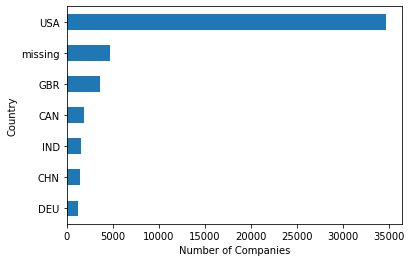

In [185]:
(
    companiesC
    .groupby('company_country_code')['company_name']
    .count()
    .sort_values(ascending=False)[0:7] #Sorting to generate a series with USA as first country, then missing, and so on
    .plot(kind="barh")
    .invert_yaxis() #using invert_yaxis() to make sure USA appears at the top, not at the bottom 
)
plt.xlabel("Number of Companies")
plt.ylabel("Country");

Getting the **ratio** of countries present in `companies` dataset

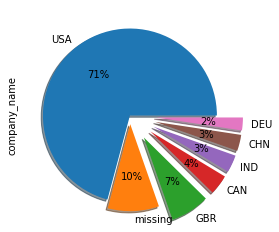

In [186]:
# note that "autopct" displays percentage of slices, 
# while "explode" gives a little space between each corresponding slice in the pie chart
(
    companiesC
    .groupby('company_country_code')['company_name']
    .count()
    .sort_values(ascending=False)[0:7]
    .plot(kind="pie", autopct='%1.0f%%', explode=[0.00,0.1,0.3,0.3,0.3,0.3,0.3], shadow=True)
);

Since `USA` represents 70% of the top 7 countries that have companies based in them. <br>
Therefore, `USA` satisfies condition `1.`

In [385]:
req = requests.get('https://home.kpmg/eg/en/home/services/tax/tax-tools-and-resources/tax-rates-online/corporate-tax-rates-table.html')
soup = BeautifulSoup(req.text, 'html.parser')
with open('kpmg.html', 'w', encoding="utf-8") as f:
    f.write(str(soup))


Displaying the retrieved page on chrome, we find the following: <br>
<img src='Phase 2/kpmgNotWorking.png' width=800 height=500>

Since the website uses javascript, `selenium` will be used instead of `requests`

In [188]:
from selenium import webdriver
import time
import warnings
warnings.filterwarnings('ignore') # to suppress warnings about internal code deprecations
options=webdriver.ChromeOptions()
options.add_argument('--incognito')
options.add_argument('--headless')
userAgent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
options.add_argument(f'user-agent={userAgent}')
driver=webdriver.Chrome(options=options)
driver.get('https://home.kpmg/eg/en/home/services/tax/tax-tools-and-resources/tax-rates-online/corporate-tax-rates-table.html')

In [189]:
time.sleep(3) # sleeping to render javascript code before parsing to BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [190]:
print(soup.prettify())

<html class="chrome" lang="en-US">
 <head class="chrome at-element-marker">
  <meta class="chrome" content="text/html; charset=utf-8" http-equiv="content-type"/>
  <meta class="chrome" content="Tue, 02 Aug 2016 11:22:32 GMT" http-equiv="date"/>
  <meta class="chrome" content="en-US" http-equiv="content-language"/>
  <meta class="chrome" content="text/html" http-equiv="content-encoding"/>
  <meta class="chrome" content="KPMG’s corporate tax table provides a view of corporate tax rates around the world." name="description"/>
  <meta charset="utf-8" class="chrome"/>
  <meta class="chrome" content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
  <link class="chrome" crossorigin="" href="https://assets.kpmg" rel="preconnect"/>
  <link class="chrome" crossorigin="" href="https://scripts.demandbase.com" rel="preconnect"/>
  <link class="chrome" crossorigin="" href="https://cdns.gigya.com" rel="preconnect"/>
  <link class="chrome" crossorigin="" href="https://fonts.gstatic.com" rel="preconn

Iframe problem:<br>
The obtained html doesn't show the content inside `iframe` tag, as `iframe` basically calls a new web page: <br>
<img src='Phase 2/emptyIframeUsingSelenium.png'>
<br><br>
actual content inside the iframe:<br>
<img src='Phase 2/notEmptyIframeGoogleInspector.png'>

Solution: retrieve page inside `src` key

In [191]:
iframe = soup.find('iframe', {'title':'taxrates'})
iframe

<iframe class="chrome" frameborder="0" height="6500px" scrolling="no" src="//s3.amazonaws.com/kpmg-global/tax-rates-tool/index_Corporate.html" title="taxrates" width="100%"></iframe>

In [192]:
tableLink = iframe.get('src')
tableLink

'//s3.amazonaws.com/kpmg-global/tax-rates-tool/index_Corporate.html'

In [193]:
tableLink = 'https:' + tableLink
driver.get(tableLink)
time.sleep(10) # sleeping a little longer, as the page loads in relatively longer time

In [194]:
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [195]:
print(soup.prettify())

<html>
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <title>
   KPMG
  </title>
  <script language="JavaScript">
   var selectedTax = "Corporate"
  </script>
  <script language="JavaScript" src="js/jquery-1.6.2.min.js">
  </script>
  <script language="JavaScript" src="js/js-GM-PRGM-009.js">
  </script>
  <link href="css/style-GM-PRGM-009.css" rel="stylesheet" type="text/css"/>
 </head>
 <body>
  <div class="GMPRGM009ResponsiveTable">
   <table width="100%">
    <tbody>
     <tr>
      <th class="GMPRGM009xslTHLocation">
       Location
      </th>
      <th class="GMPRGM009xslTHFootnotes">
       2012
      </th>
      <th class="GMPRGM009xslTHFootnotes">
       2013
      </th>
      <th class="GMPRGM009xslTHFootnotes">
       2014
      </th>
      <th class="GMPRGM009xslTHFootnotes">
       2015
      </th>
      <th class="GMPRGM009xslTHFootnotes">
       2016
      </th>
      <th class="GMPRGM009xslTHFootnotes">
       2017
      </th>
      <th

part of the page's output: <br>
<img src='Phase 2/iframePage.png'>

`pd.read_html` takes a link or html as argument and converts all tables that it finds into dataframes <br>
But since the webpage only has one table, we will directly access it using `[0]`

In [196]:
taxesTable = pd.read_html(driver.page_source)
dfTaxes = taxesTable[0]
dfTaxes

,Location,2012,2013,2014,2015,2016,2017,2018,2019,2020,Footnotes
0,Afghanistan,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,+ Show
1,Albania,10.00,10.00,15.00,15.00,15.00,15.00,15.00,15.00,15.00,+ Show
2,Algeria,NaN,25.00,19.00,26.00,26.00,26.00,26.00,26.00,26.00,+ Show
3,Andorra,NaN,NaN,NaN,NaN,NaN,10.00,10.00,10.00,10.00,+ Show
4,Angola,35.00,35.00,35.00,30.00,30.00,30.00,30.00,30.00,30.00,+ Show
...,...,...,...,...,...,...,...,...,...,...,...
178,Latin America average,28.30,27.96,27.31,27.16,27.29,27.98,28.20,27.39,27.36,NaN
179,North America average,33.00,33.00,33.25,33.25,33.25,33.25,26.75,26.75,26.75,NaN
180,Oceania average,28.60,27.00,27.00,27.00,27.00,28.43,28.43,28.43,28.43,NaN
181,OECD average,25.18,25.32,24.98,24.77,24.69,23.95,23.53,23.23,23.05,NaN


### Cleaning

In [197]:
# "footnotes" is useless, so we will remove it:
dfTaxes.drop(columns='Footnotes', inplace=True)

using `apply()` and user-defined function on each row:

In [198]:
#converting country names to country codes:
import pycountry
def toCountryCode(row):
    country = row[0]
    try:
        row[0] = pycountry.countries.get(name=country).alpha_3
    except:
        row[0] = country[0:3].upper() #if not found in pycountry, assume that it is the first 3 letters of the country name
    return row

Recall:
* **Axis 0** will act on all the rows in **each column**
* **Axis 1** will act on all the columns in **each row**
<br>
[source](https://stackoverflow.com/questions/22149584/what-does-axis-in-pandas-mean#:~:text=it%20this%20way%3A-,Axis%200%20will%20act,COLUMNS%20in%20each%20ROW,-So%20a%20mean)

In [199]:
dfTaxesCountryCodes = dfTaxes.apply(toCountryCode, axis=1)
dfTaxesCountryCodes

,Location,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,AFG,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00
1,ALB,10.00,10.00,15.00,15.00,15.00,15.00,15.00,15.00,15.00
2,DZA,NaN,25.00,19.00,26.00,26.00,26.00,26.00,26.00,26.00
3,AND,NaN,NaN,NaN,NaN,NaN,10.00,10.00,10.00,10.00
4,AGO,35.00,35.00,35.00,30.00,30.00,30.00,30.00,30.00,30.00
...,...,...,...,...,...,...,...,...,...,...
178,LAT,28.30,27.96,27.31,27.16,27.29,27.98,28.20,27.39,27.36
179,NOR,33.00,33.00,33.25,33.25,33.25,33.25,26.75,26.75,26.75
180,OCE,28.60,27.00,27.00,27.00,27.00,28.43,28.43,28.43,28.43
181,OEC,25.18,25.32,24.98,24.77,24.69,23.95,23.53,23.23,23.05


using `melt()` to change years in the header to values under the new column name `Year`

In [200]:
dfTaxesMelted = dfTaxesCountryCodes.melt(id_vars='Location', var_name='Year', value_name='TaxRate')
dfTaxesMelted

,Location,Year,TaxRate
0,AFG,2012,20.00
1,ALB,2012,10.00
2,DZA,2012,NaN
3,AND,2012,NaN
4,AGO,2012,35.00
...,...,...,...
1642,LAT,2020,27.36
1643,NOR,2020,26.75
1644,OCE,2020,28.43
1645,OEC,2020,23.05


In [201]:
dfTaxesMelted.dtypes

Location     object
Year         object
TaxRate     float64
dtype: object

converting to `int` to be able to merge with `founded_at_year` (obtained later)

In [202]:
dfTaxesMelted.Year = dfTaxesMelted.Year.astype(int)
dfTaxesMelted.dtypes

Location     object
Year          int32
TaxRate     float64
dtype: object

Checking that `USA` has a nice gap between tax rates

In [203]:
dfTaxesMelted[dfTaxesMelted['Location'] == 'USA']

,Location,Year,TaxRate
163,USA,2012,40.0
346,USA,2013,40.0
529,USA,2014,40.0
712,USA,2015,40.0
895,USA,2016,40.0
1078,USA,2017,40.0
1261,USA,2018,27.0
1444,USA,2019,27.0
1627,USA,2020,27.0


Thus, `USA` satisfies condition `2.` and thus will be used for this question

In [204]:
companiesC.founded_at.head(3)

0   2011-04-12 20:46:43.240577680
1   2014-09-04 00:00:00.000000000
2   2010-05-07 20:46:43.240577680
Name: founded_at, dtype: datetime64[ns]

Using `dt.year` to extract the year only from `datetime` datatype

In [205]:
companiesC.founded_at.dt.year.head(3)

0    2011
1    2014
2    2010
Name: founded_at, dtype: int64

In [206]:
companiesC.founded_at.isnull().sum()

0

dropping `NaNs` so that we can create `founded_at_year` as `int`

In [207]:
companiesC.dropna(subset='founded_at', inplace=True)
companiesC.founded_at.isnull().sum()

0

In [208]:
companiesC['founded_at_year'] = companiesC.founded_at.dt.year.astype(int)
companiesC.founded_at_year

0        2011
1        2014
2        2010
3        2007
4        2010
         ... 
61263    2008
61264    2012
61265    2011
61266    2014
61267    2010
Name: founded_at_year, Length: 61268, dtype: int32

### Integrating (Merging)

First, let's impute some of the missing countries from the scraping done on Apollo

In [209]:
permalinks = companiesCS[companiesCS['company_country_code'] != 'missing'][['company_permalink', 'company_country_code']]
permalinks

,company_permalink,company_country_code
0,/organization/-fame,IND
1,/organization/-qounter,USA
2,/organization/-the-one-of-them-inc-,JPN
3,/organization/0-6-com,CHN
4,/organization/004-technologies,USA
...,...,...
16511,/organization/pintail-technologies,USA
16512,/organization/pinterest,USA
16513,/organization/pintex-pharmaceuticals,USA
16514,/organization/pintics,USA


In [210]:
links = [link[0] for link in permalinks.values] #the '[0]' is because otherwise, the output is an array. e.g. "array(['/organization/10-minutes-with'], dtype=object)"
codes = [link[1] for link in permalinks.values]
linkToCode = dict(zip(links, codes))
linkToCode

{'/organization/-fame': 'IND',
 '/organization/-qounter': 'USA',
 '/organization/-the-one-of-them-inc-': 'JPN',
 '/organization/0-6-com': 'CHN',
 '/organization/004-technologies': 'USA',
 '/organization/01games-technology': 'HKG',
 '/organization/0ndine-biomedical-inc': 'CAN',
 '/organization/0xdata': 'USA',
 '/organization/1': 'USA',
 '/organization/1-2-3-listo': 'CHL',
 '/organization/1-800-dentist': 'USA',
 '/organization/1-800-doctors': 'USA',
 '/organization/1-800-publicrelations-inc-': 'USA',
 '/organization/1-mainstream': 'USA',
 '/organization/10-20-media': 'USA',
 '/organization/10-minutes-with': 'GBR',
 '/organization/1000-corks': 'USA',
 '/organization/1000-markets': 'USA',
 '/organization/1000chi': 'CHN',
 '/organization/1000lookz': 'IND',
 '/organization/1000memories': 'USA',
 '/organization/1000museums-com': 'USA',
 '/organization/1001-menus': 'FRA',
 '/organization/1001pharmacies-com': 'FRA',
 '/organization/1006-tv': 'CHN',
 '/organization/100du-tv': 'CHN',
 '/organizat

In [211]:
def missingToCode(row):
    try:
        row['company_country_code'] = linkToCode[row['company_permalink']]
    finally:
        return row

In [212]:
companiesC = companiesC.apply(lambda x: missingToCode(x), axis=1)

Using `pd.merge()` to merge `companiesC` and `dfTaxesMelted` based on the country and the year

In [213]:
companiesTaxes = pd.merge(companiesC, dfTaxesMelted, how='inner', left_on=['company_country_code', 'founded_at_year'], right_on=['Location', 'Year'])
companiesTaxes.shape

(16992, 17)

In [214]:
companiesTaxesOuter = pd.merge(companiesC, dfTaxesMelted, how='outer', left_on=['company_country_code', 'founded_at_year'], right_on=['Location', 'Year'])
companiesTaxesOuter.shape

(62618, 17)

Notice that when we used inner join, the number of companies decreased from 62618 to 16992; <br>
that's because the rest of the companies were founded before 2012 (first date in `dfTaxesMelted` dataframe) <br>
However, 10000+ are still a lot of companies, so we'll continue the analysis on this scraped data

In [215]:
companiesTaxes.columns

Index(['company_permalink', 'company_name', 'homepage_url',
       'company_category_list', 'funding_total_usd', 'status',
       'company_country_code', 'company_city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'time_before_first_fund',
       'founded_at_year', 'Location', 'Year', 'TaxRate'],
      dtype='object')

dropping `Location` and `Year` since they're redundent info

In [216]:
companiesTaxes.drop(columns=['Location', 'Year'], inplace=True)
companiesTaxes.columns

Index(['company_permalink', 'company_name', 'homepage_url',
       'company_category_list', 'funding_total_usd', 'status',
       'company_country_code', 'company_city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'time_before_first_fund',
       'founded_at_year', 'TaxRate'],
      dtype='object')

using `pop()` and `insert()` to shift the `founded_at_year` column to be next to `founded_at` column for aesthetic reasons :]

In [217]:
columnValues = companiesTaxes.pop("founded_at_year")
companiesTaxes.insert(10, "founded_at_year", columnValues)
companiesTaxes.columns

Index(['company_permalink', 'company_name', 'homepage_url',
       'company_category_list', 'funding_total_usd', 'status',
       'company_country_code', 'company_city', 'funding_rounds', 'founded_at',
       'founded_at_year', 'first_funding_at', 'last_funding_at',
       'time_before_first_fund', 'TaxRate'],
      dtype='object')

Using only companies in `USA`

In [218]:
usaCompaniesTaxes = companiesTaxes[companiesTaxes['company_country_code'] == 'USA']
usaCompaniesTaxes.shape

(9519, 15)

9k are still a lot of companies, so we will continue the analysis on `USA`

### Visualizing

Now, let's evaluate how taxes affect companies. 3 features will be chosen for the evaluation:
1. `funding_total_usd`
2. `status`

Correlating taxes with total fundings by getting their average in each year

In [219]:
usaCompaniesTaxes.founded_at_year.unique()

array([2014, 2013, 2012, 2015, 2016], dtype=int64)

In [220]:
taxTotalFundsUSA = (usaCompaniesTaxes[['founded_at_year', 'TaxRate', 'funding_total_usd']]
                    .groupby(['founded_at_year', 'TaxRate'])
                    .mean()
                    .round(0)
                    .style.format("{:,}"))
taxTotalFundsUSA

,,funding_total_usd
founded_at_year,TaxRate,
2012,40.000000,"7,229,034.0"
2013,40.000000,"5,651,029.0"
2014,40.000000,"2,762,574.0"
2015,40.000000,"1,787,911.0"
2016,40.000000,0.0


Problem: turns out that in our dataset, `USA` companies that are after 2016 are not present, <br>
and the tax rate for the countries before that were constant (40%)

In [221]:
#getting the number of companies that were founded after the end of 2015
len(companiesC[(companiesC.company_country_code == 'USA') & (companiesC.founded_at >= pd.Timestamp(2016, 1, 1))])

1

Therefore, let's look at other countries

### Working on GBR taxes (working attempt)

Scraping, Cleaning, and Integration are already done above <br>
the output was the dataframe called `companiesTaxes`

Using only companies in `GBR`

In [222]:
gbrCompaniesTaxes = companiesTaxes[companiesTaxes['company_country_code'] == 'GBR']
gbrCompaniesTaxes.shape

(1125, 15)

Only 1125 companies, unfortunately scraping `Apollo` is now not an option (due to getting blocked) <br>
so we can only rely on these companies

In [223]:
gbrCompaniesTaxes.founded_at_year.unique()

array([2013, 2015, 2012, 2014], dtype=int64)

all the 1k companies in GBR were founded in the range between 2012 and 2015 <br>
Let's check the taxes at that time:

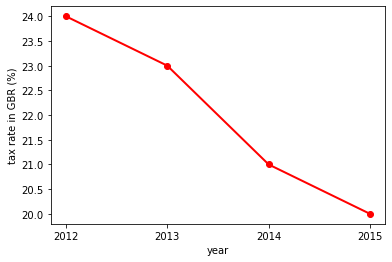

In [224]:
dfStep = dfTaxesMelted[(dfTaxesMelted['Location'] == 'GBR') & (dfTaxesMelted['Year'].between(2012,2015))][['Year', 'TaxRate']]
plt.plot(dfStep['Year'], dfStep['TaxRate'], marker='o', linestyle='-', color='r', linewidth=2)
plt.xlabel('year')
plt.ylabel('tax rate in GBR (%)')
plt.xticks([2012,2013,2014,2015]);

Since the tax rate has been gradually decreasing <br>
Thus, we expect better company performance throughout the years

### Visualizing

As before, 2 features will be chosen to evaluate how taxes affect companies:
1. `funding_total_usd`
2. `funding_rounds`

Correlating taxes with total number of operating/acquired/closed companies in each year

In [225]:
gbrCompaniesStatus = (gbrCompaniesTaxes[['founded_at_year', 'TaxRate', 'status', 'company_permalink']]
                            .groupby(['status', 'founded_at_year', 'TaxRate'])
                            .count())
gbrCompaniesStatus

company_permalink
status    founded_at_year TaxRate                   
acquired  2012            24.0                     8
          2013            23.0                     2
          2014            21.0                     1
closed    2012            24.0                    19
          2013            23.0                     5
          2014            21.0                    17
          2015            20.0                    12
ipo       2012            24.0                     1
          2015            20.0                     1
operating 2012            24.0                   372
          2013            23.0                   379
          2014            21.0                   239
          2015            20.0                    69

Text(-0.2, 1.0, 'status, founded year, tax rate')

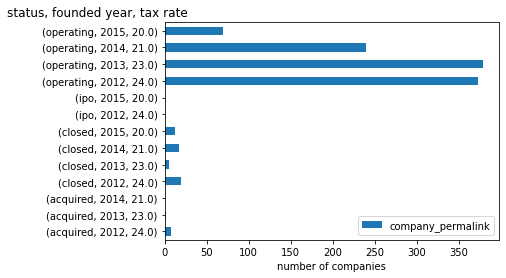

In [226]:
gbrCompaniesStatus.plot(kind='barh')
plt.xlabel('number of companies')
plt.ylabel('')
plt.title('status, founded year, tax rate', x=-0.2)

Since most companies were operating, and there are negligible number of companies are IPO, <br>
Therefore we will focus on closed companies:

In [227]:
gbrClosedCompaniesTaxes = gbrCompaniesTaxes[gbrCompaniesTaxes['status'] == 'closed']
gbrCompaniesClosed = (gbrClosedCompaniesTaxes[['founded_at_year', 'TaxRate', 'company_permalink']]
                            .groupby(['founded_at_year', 'TaxRate'])
                            .count())
gbrCompaniesClosed = gbrCompaniesClosed.reset_index()
gbrCompaniesClosed

,founded_at_year,TaxRate,company_permalink
0,2012,24.0,19
1,2013,23.0,5
2,2014,21.0,17
3,2015,20.0,12


In [228]:
gbrCompaniesClosedPivoted = gbrCompaniesClosed.pivot(index='founded_at_year', columns='TaxRate', values='company_permalink')
gbrCompaniesClosedPivoted

TaxRate,20.0,21.0,23.0,24.0
founded_at_year,,,,
2012,NaN,NaN,NaN,19.0
2013,NaN,NaN,5.0,NaN
2014,NaN,17.0,NaN,NaN
2015,12.0,NaN,NaN,NaN


<AxesSubplot:xlabel='TaxRate', ylabel='founded_at_year'>

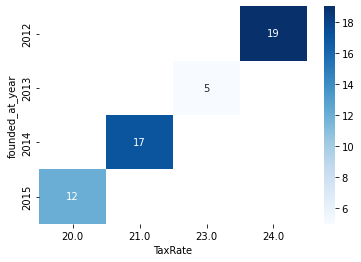

In [229]:
sns.color_palette("Blues", as_cmap=True)
sns.heatmap(gbrCompaniesClosedPivoted, annot=True, cmap="Blues")

Notice that even though the tax rate decreases each year, "a lot" of companies closed in 2014 and 2015 <br>
when compared to 2012 which had the highest tax rate

However, we have to bear in mind that the 1k companies aren't equally distributed throghout the years:

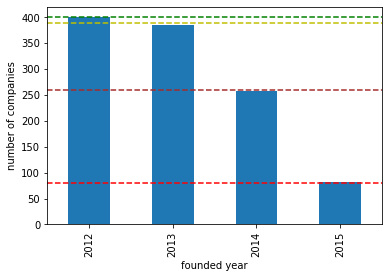

In [230]:
(
    gbrCompaniesTaxes
    .groupby('founded_at_year')['company_name']
    .count()
    .plot(kind='bar')
)
plt.xlabel('founded year')
plt.ylabel('number of companies')
plt.yticks(range(0,401,50))
plt.axhline(80, color='r', linestyle='--')
plt.axhline(260, color='brown', linestyle='--')
plt.axhline(390, color='y', linestyle='--')
plt.axhline(400, color='g', linestyle='--');

Therefore let's compare by the ratio of the closed companies to all companies in each year

In [231]:
gbrCompaniesAllStatus = (gbrCompaniesTaxes[['founded_at_year', 'TaxRate', 'company_permalink']]
                            .groupby(['founded_at_year', 'TaxRate'])
                            .count())
gbrCompaniesAllStatus = gbrCompaniesAllStatus.reset_index()
gbrCompaniesAllStatus

,founded_at_year,TaxRate,company_permalink
0,2012,24.0,400
1,2013,23.0,386
2,2014,21.0,257
3,2015,20.0,82


In [232]:
gbrCompaniesClosed['CountRatio'] = 0.0
gbrCompaniesClosed

,founded_at_year,TaxRate,company_permalink,CountRatio
0,2012,24.0,19,0.0
1,2013,23.0,5,0.0
2,2014,21.0,17,0.0
3,2015,20.0,12,0.0


In [233]:
for i in range(len(gbrCompaniesClosed)):
    gbrCompaniesClosed.at[i,'CountRatio'] = gbrCompaniesClosed.at[i,'company_permalink'] / gbrCompaniesAllStatus.at[i,'company_permalink']
gbrCompaniesClosed['CountRatio'] *= 100 #converting ratio to percentage

gbrCompaniesClosed.drop(columns=['company_permalink'], inplace=True)

In [234]:
gbrCompaniesClosed = gbrCompaniesClosed.round(1) #rounding percentage ('CountRatio') to 1 decimal point
gbrCompaniesClosed

,founded_at_year,TaxRate,CountRatio
0,2012,24.0,4.8
1,2013,23.0,1.3
2,2014,21.0,6.6
3,2015,20.0,14.6


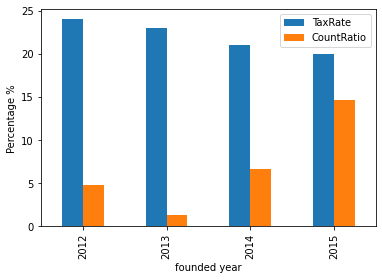

In [235]:
gbrCompaniesClosed.set_index('founded_at_year').plot(kind='bar')
plt.xlabel('founded year')
plt.ylabel('Percentage %');

When we compare by ratios, still the same insight applies: <br> 
"a lot" of companies closed in 2014 and 2015 <br>
when compared to 2012 which had the highest tax rate

Thus we can deduce that the wellfare of companies isn't determined by the country's current tax rate <br>

Let's also correlate taxes with total fundings by getting their average in each year

In [236]:
gbrCompaniesTotalFunds = (gbrCompaniesTaxes[['founded_at_year', 'TaxRate', 'funding_total_usd']]
                            .groupby(['founded_at_year', 'TaxRate'])
                            .mean()
                            .round(0)
                            #.style.format("{:,}") #formats float with commas, commented out because "gbrCompaniesTotalFunds" will become a styler object, not a DataFrame 
                            )
gbrCompaniesTotalFunds

,,funding_total_usd
founded_at_year,TaxRate,
2012,24.0,4833843.0
2013,23.0,2110957.0
2014,21.0,1670704.0
2015,20.0,1297203.0


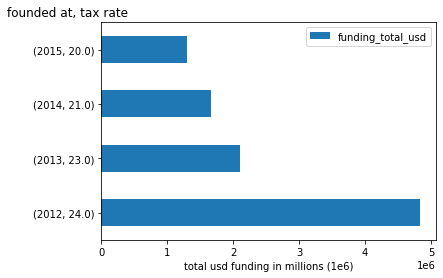

In [237]:
gbrCompaniesTotalFunds.plot(kind='barh')
plt.xlabel('total usd funding in millions (1e6)')
plt.ylabel('')
plt.title('founded at, tax rate', x=-0.1);

Again, this is not accurate because the 1k companies aren't equally distributed throghout the years <br>
However, looking back at the distribution:

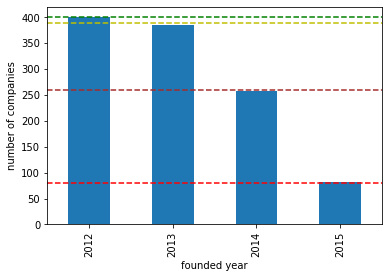

In [238]:
(
    gbrCompaniesTaxes
    .groupby('founded_at_year')['company_name']
    .count()
    .plot(kind='bar')
)
plt.xlabel('founded year')
plt.ylabel('number of companies')
plt.yticks(range(0,401,50))
plt.axhline(80, color='r', linestyle='--')
plt.axhline(260, color='brown', linestyle='--')
plt.axhline(390, color='y', linestyle='--')
plt.axhline(400, color='g', linestyle='--');

One can notice that even though 250+ companies were founded in 2014 and only 70+ were founded in 2015 <Br>
The difference in the total funding is only around 100k USD, which is not much <br>
Therefore, these few companies in 2015 got relatively a lot of fundings, and at the same time, the taxes went down by 1% <br>
Thus, there could be a *slight correlation* between decreasing the rate of taxes, and increasing the possibility that investors invest <br>
with more amount of money in a staartup company

## Question 2 (Aisha)

Can the number of technologies used by companies affect the rate of its success or failure?

In [239]:
# Getting the Cleaned Datasets
companiesC = pd.read_csv("datasets/startupsCleaned/companiesCleaned.csv", parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'time_before_first_fund'])
companiesCS = pd.read_csv("datasets/startupsCleaned/companiesCleanedAndScraped.csv", parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'time_before_first_fund'])


Explanation and visualization:





 This can be seen by checking the funding each company received based on their status and technology count.First we extract these columns from the companies table.

In [240]:
miniTable=companiesCS.loc[:, ['status','number_of_technologies','funding_total_usd']]

Secondly we'll start analysing this data based on status.


1- Operating Companies

In [241]:
operating=miniTable.loc[miniTable['status']=="operating"]
operating.iloc[0:40,:]

,status,number_of_technologies,funding_total_usd
0,operating,1,10000000.0
1,operating,3,700000.0
2,operating,10,3406878.0
3,operating,5,2000000.0
4,operating,10,0.0
5,operating,6,41250.0
6,operating,6,762851.0
7,operating,32,33600000.0
8,operating,3,1150050.0
9,operating,5,40000.0


From the table above we can notice that on the first row the funding is a large amount and the company only uses one technology.
The second row has only 3 technologies but the difference seems quite noticeable.
In the third row how ever,we have 10 technologies being used and a quite large amount of funding. Though not as large as in row one. We can deduce that with technologies there a need for funding technological maintainance too unlike the first row which will need much less of that and hence has all funds going to other busines needs. This can be confirmed with the graphs below.

Text(0.5, 1.0, 'Operating companies and their technologies')

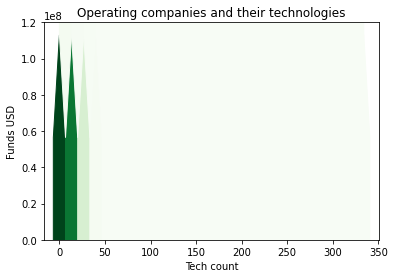

In [242]:
plt.hexbin(operating.number_of_technologies,operating.funding_total_usd,gridsize = 25, cmap ='Greens')
plt.xlabel('Tech count')
plt.ylabel('Funds USD')
plt.ylim([0,1.2e8])
plt.title("Operating companies and their technologies")

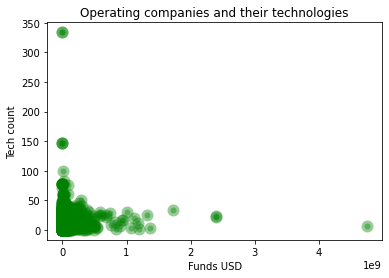

In [243]:
plt.scatter(operating.funding_total_usd,operating.number_of_technologies,c="green", alpha=0.4, linewidth=6)
plt.title("Operating companies and their technologies")
plt.ylabel('Tech count')
plt.xlabel('Funds USD') 
plt.show()

As shown above, most operating companies have funds in the range approximately [0,0.5]e9 USD with technology count ranging from 0 to approximately 90. Few have technologies above 90 and funding above 1e9 USD just like we were able to deduce from the table.

2- Acquired companies

In [244]:
acquired=miniTable.loc[miniTable['status']=="acquired"]
acquired.iloc[0:40,:]


,status,number_of_technologies,funding_total_usd
13,acquired,4,5.000000e+06
17,acquired,4,5.000000e+05
20,acquired,3,2.535000e+06
28,acquired,19,1.250000e+06
29,acquired,21,3.500000e+07
51,acquired,8,0.000000e+00
56,acquired,6,0.000000e+00
58,acquired,5,7.000000e+05
69,acquired,2,1.400000e+07
80,acquired,13,0.000000e+00


The same logic seem to hold just like the operating companies and we can conclude that companies having high technology count with not very high amounts of funding possess technologies which require high maintainance.  This can be illustrated as follows.

Text(0.5, 1.0, 'Acquired companies and their technologies')

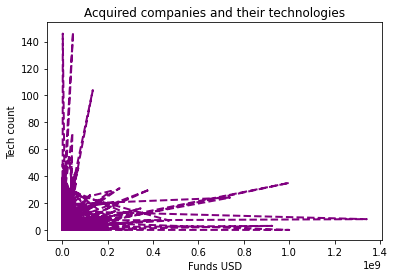

In [245]:

plt.plot( 'funding_total_usd','number_of_technologies', data=acquired,  marker='', color='purple', linewidth=2, linestyle='dashed')
plt.ylabel('Tech count')
plt.xlabel('Funds USD') 
plt.title("Acquired companies and their technologies")

The deduction of the same understanding repeating itself for acquired companies has now been confirmed with the graph above. We can view that most acquired companies have [0-40] technologies and [0-0.3]e9 USD of funding most of the time. Just to make sure that this logic is indeed the right one we will repeat the process for ipo companies.

3- IPO companies

In [246]:
ipo=miniTable.loc[miniTable['status']=="ipo"]
ipo.iloc[0:40,:]

,status,number_of_technologies,funding_total_usd
119,ipo,9,3.960000e+08
120,ipo,10,1.503475e+07
172,ipo,15,9.587500e+07
232,ipo,29,1.695000e+08
377,ipo,7,8.767800e+08
383,ipo,8,6.100000e+06
404,ipo,11,1.105250e+07
468,ipo,27,1.260000e+08
551,ipo,24,1.180000e+08
552,ipo,7,5.028600e+08


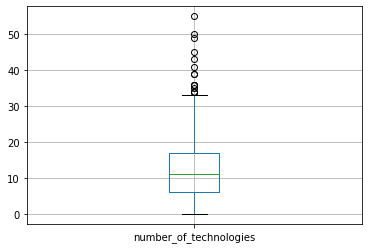

In [247]:
boxplot = ipo.boxplot(column=['number_of_technologies'])

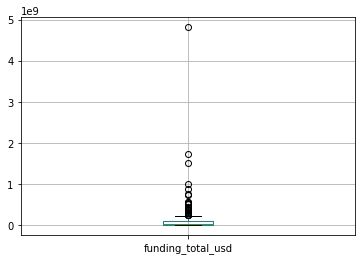

In [248]:
boxplot = ipo.boxplot(column=['funding_total_usd'])

Text(0.5, 1.0, 'IPO companies and their technologies')

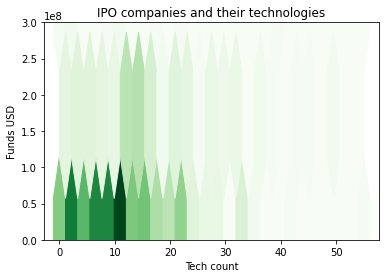

In [249]:
plt.hexbin(ipo.number_of_technologies,ipo.funding_total_usd,gridsize = 25, cmap ='Greens')
plt.xlabel('Tech count')
plt.ylabel('Funds USD') 
plt.ylim([0,3e8])
plt.title("IPO companies and their technologies")

We can now conclude that;
* Companies with high funding and little or no technology count are more focused on products and other business services.
* Companies with high funding and high technological count imply that these technologies require high maintainance which the shareholders are willing to provide.
*  Companies with low funding and high  technological count imply that these technologies don't require high maintainance.

 We can also conclude that some companies get acquired due to low funding and high technological demands whose maintainace the shareholders are not willing to pay extra money for.

## Question 3 (Farah)

#### Does the number of Employees affect the success of company?

In [250]:
# Getting the Cleaned Datasets
companiesC = pd.read_csv("datasets/startupsCleaned/companiesCleaned.csv", parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'time_before_first_fund'])
companiesCS = pd.read_csv("datasets/startupsCleaned/companiesCleanedAndScraped.csv", parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'time_before_first_fund'])


In [251]:
companiesCS

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund,employee_count,number_of_technologies,annual_rev
0,/organization/-fame,#fame,http://livfame.com,Media,1.000000e+07,operating,IND,Mumbai,1,2011-04-12 20:46:43.240577680,2015-01-05,2015-01-05,1363 days 03:13:16.759422320,57,1,1.500000e+06
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,7.000000e+05,operating,USA,Delaware City,2,2014-09-04 00:00:00.000000000,2014-03-01,2014-10-14,-187 days +00:00:00,4,3,NaN
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3.406878e+06,operating,JPN,missing,1,2010-05-07 20:46:43.240577680,2014-01-30,2014-01-30,1363 days 03:13:16.759422320,18,10,NaN
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,2.000000e+06,operating,CHN,Beijing,1,2007-01-01 00:00:00.000000000,2008-03-19,2008-03-19,443 days 00:00:00,0,5,NaN
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,0.000000e+00,operating,USA,Champaign,1,2010-01-01 00:00:00.000000000,2014-07-24,2014-07-24,1665 days 00:00:00,67,10,5.000000e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16511,/organization/pintail-technologies,Pintail Technologies,http://www.pintailtechnologies.com,Software,1.000000e+07,operating,USA,Richardson,2,2000-01-01 00:00:00.000000000,2005-03-08,2006-09-29,1893 days 00:00:00,0,1,2.000000e+06
16512,/organization/pinterest,Pinterest,https://pinterest.com,Curated Web|Social Bookmarking|Social Media,1.315500e+09,operating,USA,San Francisco,10,2009-01-01 00:00:00.000000000,2010-01-01,2015-06-01,365 days 00:00:00,6000,26,2.436989e+09
16513,/organization/pintex-pharmaceuticals,Pintex Pharmaceuticals,http://www.pintexpharm.com,Pharmaceuticals,7.250000e+06,acquired,USA,Watertown,1,2000-05-01 00:00:00.000000000,2002-12-24,2002-12-24,967 days 00:00:00,0,0,NaN
16514,/organization/pintics,Pintics,http://www.pintics.com,Curated Web,1.000000e+04,closed,USA,San Jose,1,2012-01-10 00:00:00.000000000,2012-05-18,2012-05-18,129 days 00:00:00,0,1,NaN


### Cleaning

As seen below, annual revenues has nulls in it so it will be dropped when this feature is needed.

In [252]:
companiesCS.isnull().sum()

company_permalink            0
company_name                 0
homepage_url                 0
company_category_list        0
funding_total_usd            0
status                       0
company_country_code         0
company_city                 0
funding_rounds               0
founded_at                   0
first_funding_at             0
last_funding_at              0
time_before_first_fund       0
employee_count               0
number_of_technologies       0
annual_rev                4986
dtype: int64

Let's see if the relationship between the number of employees is proportional with the suceess of the company in other words operating or not.
Unfortunately, we don't have details on employees' salaries but we have their number in each company. if it's directly proportional then the number of employees present an important asset to building a new company, while if it's directly proportional then it proves that employing many employees can be only a burden to kick off the company

In [253]:
operating_comps = companiesCS[companiesCS['status'] == 'operating']
operating_comps.sort_values(by=['employee_count'], ascending=False, inplace=True)
operating_comps

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund,employee_count,number_of_technologies,annual_rev
16328,/organization/pickatale,Pickatale,http://itunes.apple.com/en/app/100+-interactiv...,Education|iPad|Kids|Language Learning,1000000.0,operating,USA,missing,1,2013-01-01 00:00:00.000000000,2013-01-01,2013-01-01,0 days 00:00:00,428000,12,3.783230e+11
5367,/organization/beme-2,Beme,https://itunes.apple.com/us/app/beme-share-vid...,Video,2000000.0,operating,USA,New York,1,2011-11-02 20:46:43.240577680,2015-07-28,2015-07-28,1363 days 03:13:16.759422320,428000,12,3.783230e+11
4715,/organization/b-famous-media-llc,"b*famous Media, LLC",https://itunes.apple.com/us/app/b*famous/id929...,Apps|Internet|Mobile Games,0.0,operating,USA,Boston,1,2010-09-17 20:46:43.240577680,2014-06-12,2014-06-12,1363 days 03:13:16.759422320,428000,12,3.783230e+11
10902,/organization/megajosh,MEGAJOSH,http://goo.gl/7vAvYj,Bitcoin|Classifieds|E-Commerce|Marketplaces|Mo...,0.0,operating,USA,Orlando,1,2015-01-01 00:00:00.000000000,2015-06-01,2015-06-01,151 days 00:00:00,281000,147,2.580000e+08
9671,/organization/maaish-inc,Maaish Inc,https://drive.google.com/file/d/0B1Nzn7sbX92fN...,missing,50000.0,operating,USA,missing,1,2015-07-01 00:00:00.000000000,2015-07-15,2015-07-15,14 days 00:00:00,281000,147,2.580000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13557,/organization/native-4,Now Native,http://nownative.com,Advertising,0.0,operating,GBR,London,1,2011-03-10 20:46:43.240577680,2014-12-03,2014-12-03,1363 days 03:13:16.759422320,0,3,NaN
13558,/organization/native-tap,Native Tap,http://nativetap.io/,Apps,100000.0,operating,USA,San Francisco,1,2011-02-06 20:46:43.240577680,2014-11-01,2014-11-01,1363 days 03:13:16.759422320,0,33,NaN
8630,/organization/cbca,CBCA,http://www.cbca.com/,Employer Benefits Programs|Health and Insuranc...,30000000.0,operating,USA,Oakland,1,1998-08-07 20:46:43.240577680,2002-05-02,2002-05-02,1363 days 03:13:16.759422320,0,1,1.750000e+08
2282,/organization/alphacare-holdings,AlphaCare Holdings,http://alphacare.com,Biotechnology,17415364.0,operating,USA,Brooklyn,2,2012-01-01 00:00:00.000000000,2013-08-14,2014-01-14,591 days 00:00:00,0,6,7.000000e+06


In [254]:
closed_comps = companiesCS[companiesCS['status'] == 'closed']
closed_comps.sort_values(by=['employee_count'], ascending=False, inplace=True)
closed_comps

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund,employee_count,number_of_technologies,annual_rev
15276,/organization/omnino-llp,Omnino LLP,https://www.linkedin.com/company/omnino-llp,missing,0.0,closed,USA,missing,1,2008-01-01 00:00:00.000000000,2008-02-15,2008-02-15,45 days 00:00:00,25000,36,1.030000e+10
8407,/organization/carrot-rocket-ltd,Carrot Rocket Ltd,https://www.linkedin.com/company/carrot-rocket...,Apps|Entertainment|Internet,450000.0,closed,GBR,London,1,2015-03-13 00:00:00.000000000,2015-02-02,2015-02-02,-39 days +00:00:00,25000,36,1.030000e+10
9447,/organization/lululemon-athletica,lululemon athletica,http://www.lululemon.com,Fitness|Health and Wellness|Online Shopping,93000000.0,closed,CAN,Vancouver,1,1998-01-01 00:00:00.000000000,2005-12-14,2005-12-14,2904 days 00:00:00,17000,25,5.857053e+09
12059,/organization/mobintent,mobintent,http://www.businessinsider.com/mobintent-dies-...,Advertising|Finance,0.0,closed,USA,New York,1,2010-08-01 00:00:00.000000000,2011-07-01,2011-07-01,334 days 00:00:00,17000,42,1.100000e+08
15711,/organization/openreach-2,OpenReach,http://www.openreach.com/,Networking,7000000.0,closed,USA,Woburn,1,2000-05-06 20:46:43.240577680,2004-01-30,2004-01-30,1363 days 03:13:16.759422320,14000,14,6.558020e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7638,/organization/buyosphere,Buyosphere,http://buyosphere.com,E-Commerce|Fashion|Search|Shopping|Social Comm...,325000.0,closed,CAN,Montréal,1,2010-01-01 00:00:00.000000000,2012-01-05,2012-01-05,734 days 00:00:00,0,4,1.400000e+06
7640,/organization/buyplaywin,BuyPlayWin,http://buyplaywin.com,Curated Web|Finance,0.0,closed,USA,missing,1,2004-08-06 20:46:43.240577680,2008-05-01,2008-05-01,1363 days 03:13:16.759422320,0,3,NaN
7646,/organization/buysimple,BuySimple,http://www.buysimple.com,E-Commerce,700000.0,closed,USA,Palo Alto,1,2011-01-01 00:00:00.000000000,2011-05-31,2011-05-31,150 days 00:00:00,0,6,NaN
7647,/organization/buystand,BUYSTAND,http://buystand.com,Big Data|E-Commerce|Marketplaces,450000.0,closed,USA,Durham,1,2011-11-01 00:00:00.000000000,2012-12-17,2012-12-17,412 days 00:00:00,0,3,NaN


In [255]:
acquired_comps = companiesCS[companiesCS['status'] == 'acquired']
acquired_comps.sort_values(by=['employee_count'], ascending=False, inplace=True)
acquired_comps

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund,employee_count,number_of_technologies,annual_rev
7466,/organization/buildforge,BuildForge,http://ibm.com/awdtools/buildforge,Software,6000000.0,acquired,USA,Austin,1,2001-01-01 00:00:00.000000000,2005-09-12,2005-09-12,1715 days 00:00:00,528000,47,5.735000e+10
1245,/organization/admob,AdMob,http://www.google.com/admob,Advertising|Mobile,46800000.0,acquired,USA,Mountain View,4,2006-12-01 00:00:00.000000000,2006-09-01,2009-01-29,-91 days +00:00:00,281000,147,2.580000e+08
13805,/organization/neopath-networks,NeoPath Networks,http://cisco.com,Enterprise Software,29000000.0,acquired,USA,Mountain View,3,2002-01-01 00:00:00.000000000,2004-03-08,2006-05-22,797 days 00:00:00,99000,54,4.920000e+10
9706,/organization/macromedia,Macromedia,http://www.adobe.com,Software,44000000.0,acquired,USA,San Francisco,1,1992-01-01 00:00:00.000000000,1999-12-03,1999-12-03,2893 days 00:00:00,31000,72,1.578500e+10
15088,/organization/office-depot,Office Depot,http://officedepot.com,E-Commerce,0.0,acquired,USA,Boca Raton,1,1986-01-01 00:00:00.000000000,1989-06-01,1989-06-01,1247 days 00:00:00,31000,22,8.465000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8753,/organization/liquidtalk,LiquidTalk,http://www.liquidtalk.com,Enterprise Software,2430000.0,acquired,USA,Chicago,1,2006-01-01 00:00:00.000000000,2007-03-05,2007-03-05,428 days 00:00:00,0,1,2.400000e+06
8833,/organization/live-matrix,Live Matrix,http://www.livematrix.com,Curated Web|Online Scheduling|Video,0.0,acquired,USA,Los Angeles,1,2009-01-01 00:00:00.000000000,2009-01-01,2009-01-01,0 days 00:00:00,0,2,2.400000e+06
8835,/organization/live-on-the-go,Live On The Go,http://www.liveonthego.com,Curated Web|Restaurants,60000.0,acquired,USA,Anaheim,1,2005-09-03 20:46:43.240577680,2009-05-29,2009-05-29,1363 days 03:13:16.759422320,0,1,1.750000e+07
8929,/organization/livio-radio,Livio Radio,http://livioradio.com,Apps|Electronics|Hardware + Software|Music,5796518.0,acquired,USA,Ferndale,4,2008-01-01 00:00:00.000000000,2010-06-17,2013-07-18,898 days 00:00:00,0,5,2.400000e+06


In [256]:
ipo_comps = companiesCS[companiesCS['status'] == 'ipo']
ipo_comps.sort_values(by=['employee_count'], ascending=False, inplace=True)
ipo_comps

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund,employee_count,number_of_technologies,annual_rev
2438,/organization/amazon,Amazon,http://amazon.com,Consumer Goods|Crowdsourcing|Delivery|E-Commer...,8.000000e+06,ipo,USA,Seattle,1,1994-07-05 00:00:00.000000000,1995-07-01,1995-07-01,361 days 00:00:00,1057000,35,4.698220e+11
591,/organization/abbott,Abbott Labs,http://www.abbott.com,Biotechnology|Health and Wellness|Medical|Vent...,6.790000e+06,ipo,USA,Des Plaines,2,1991-01-01 00:00:00.000000000,2009-03-16,2011-03-15,6649 days 00:00:00,166000,22,4.307500e+10
587,/organization/abb,ABB,http://www.abb.com,Automotive|Clean Technology|Energy|Technology,2.700000e+06,ipo,CHE,Zürich,1,1988-01-01 00:00:00.000000000,2013-09-23,2013-09-23,9397 days 00:00:00,125000,55,2.856000e+10
9078,/organization/lockheed-martin,Lockheed Martin,http://www.lockheedmartin.com,Design|Security,2.740000e+07,ipo,USA,Bethesda,2,1995-03-01 00:00:00.000000000,2009-07-06,2010-11-22,5241 days 00:00:00,111000,16,6.704400e+10
1272,/organization/adp,ADP (Automatic Data Processing),http://www.adp.com,Business Services|Consulting|Outsourcing,2.000000e+06,ipo,USA,Roseland,1,1949-01-01 00:00:00.000000000,2005-12-30,2005-12-30,20817 days 00:00:00,91000,34,1.569670e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,/organization/alexion-pharmaceuticals,Alexion Pharmaceuticals,http://www.alexionpharma.com,Biotechnology|Health and Wellness|Medical,3.132281e+04,ipo,USA,Cheshire,1,1992-01-01 00:00:00.000000000,2015-04-02,2015-04-02,8492 days 00:00:00,0,15,NaN
8185,/organization/carbylan-biosurgery,Carbylan Therapeutics,http://www.carbylan.com,Health Care,3.500000e+07,ipo,USA,Palo Alto,4,2005-01-01 00:00:00.000000000,2007-11-26,2015-03-06,1059 days 00:00:00,0,14,NaN
5857,/organization/bioheart,Bioheart,http://www.bioheartinc.com,Biotechnology,9.465200e+05,ipo,USA,Sunrise,5,1999-01-01 00:00:00.000000000,2001-06-12,2013-06-05,893 days 00:00:00,0,10,NaN
7721,/organization/c-bridge-internet-solutions,C-Bridge Internet Solutions,http://www.c-bridge.com/about_us.htm,Consulting,3.747923e+08,ipo,USA,Cambridge,3,1996-01-01 00:00:00.000000000,1999-01-01,2000-01-01,1096 days 00:00:00,0,0,7.000000e+06


In [257]:
operating_comps['employee_count'].value_counts(ascending=False)

0       2752
2        839
3        632
1        518
4        448
        ... 
7500       1
7700       1
8000       1
9100       1
3500       1
Name: employee_count, Length: 276, dtype: int64

In [258]:
closed_comps['employee_count'].value_counts(ascending=False)

0      719
2       74
1       67
3       61
10      52
      ... 
230      1
240      1
250      1
380      1
71       1
Name: employee_count, Length: 137, dtype: int64

In [259]:
acquired_comps['employee_count'].value_counts(ascending=False)

0      381
2       78
10      52
3       45
1       43
      ... 
780      1
790      1
860      1
900      1
93       1
Name: employee_count, Length: 182, dtype: int64

In [260]:
ipo_comps['employee_count'].value_counts(ascending=False)

0          21
5          15
2          14
150         9
9           8
           ..
3300        1
3200        1
3100        1
180         1
1057000     1
Name: employee_count, Length: 188, dtype: int64

We can consider the companies with 0 employees that the founder did not employ anyone and we will see later the impact of this decision on the company.
To see how impactful the number of employees on the success of a company, we will coorelate it with the annual revenue of the company. The annual revenue will definetly show how the company is doing.

In [261]:
companiesCS_ann = companiesCS.dropna(subset=['annual_rev'])
companiesCS_ann

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund,employee_count,number_of_technologies,annual_rev
0,/organization/-fame,#fame,http://livfame.com,Media,1.000000e+07,operating,IND,Mumbai,1,2011-04-12 20:46:43.240577680,2015-01-05,2015-01-05,1363 days 03:13:16.759422320,57,1,1.500000e+06
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,0.000000e+00,operating,USA,Champaign,1,2010-01-01 00:00:00.000000000,2014-07-24,2014-07-24,1665 days 00:00:00,67,10,5.000000e+06
6,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,http://ondinebio.com,Biotechnology,7.628510e+05,operating,CAN,Vancouver,2,1997-01-01 00:00:00.000000000,2009-09-11,2009-12-21,4636 days 00:00:00,30,6,8.575000e+06
7,/organization/0xdata,H2O.ai,http://h2o.ai/,Analytics,3.360000e+07,operating,USA,Mountain View,4,2011-01-01 00:00:00.000000000,2013-01-03,2015-11-09,733 days 00:00:00,370,32,3.210000e+07
8,/organization/1,One Inc.,http://whatis1.com,Mobile,1.150050e+06,operating,USA,San Francisco,3,2011-08-01 00:00:00.000000000,2011-07-20,2014-02-05,-12 days +00:00:00,3,3,2.200000e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16508,/organization/pinstripe,Pinstripe,http://www.pinstripetalent.com,Consulting,3.000000e+06,operating,USA,Brookfield,2,2002-03-21 20:46:43.240577680,2005-12-14,2012-08-02,1363 days 03:13:16.759422320,60,17,1.676400e+07
16509,/organization/pint-please,Pint Please,http://www.pintplease.com,Android|Craft Beer|iOS|Mobile,4.546730e+05,operating,FIN,Oulu,1,2014-01-10 00:00:00.000000000,2014-08-13,2014-08-13,215 days 00:00:00,10,8,2.932000e+06
16511,/organization/pintail-technologies,Pintail Technologies,http://www.pintailtechnologies.com,Software,1.000000e+07,operating,USA,Richardson,2,2000-01-01 00:00:00.000000000,2005-03-08,2006-09-29,1893 days 00:00:00,0,1,2.000000e+06
16512,/organization/pinterest,Pinterest,https://pinterest.com,Curated Web|Social Bookmarking|Social Media,1.315500e+09,operating,USA,San Francisco,10,2009-01-01 00:00:00.000000000,2010-01-01,2015-06-01,365 days 00:00:00,6000,26,2.436989e+09


### Visualization & Analysis

Coorelating between the number of employees and the annual revenue of a company for each type of company whethere operating, closed,etc.

<AxesSubplot:xlabel='employee_count', ylabel='annual_rev'>

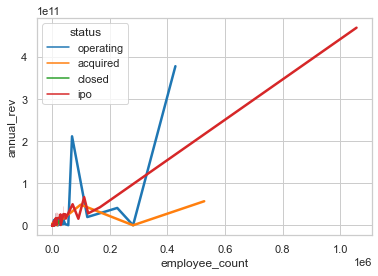

In [262]:
sns.set_theme(style="whitegrid")
sns.lineplot(data=companiesCS_ann, x="employee_count", y="annual_rev", hue="status", palette="tab10", linewidth=2.5)

As seen above, there's seemingly a direct proportional relation between the number of employees and the annual revenue. It supports the fact of hiring intels is for the sake of the company's success, yet  it is seen that each company with different status can be slightly different. Let's analyze at each status seperately.

<AxesSubplot:xlabel='employee_count', ylabel='annual_rev'>

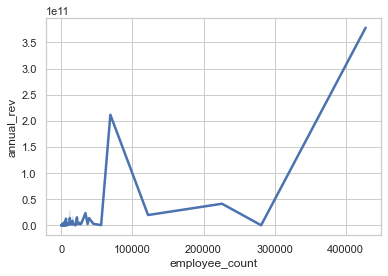

In [263]:
sns.lineplot(data=companiesCS_ann[companiesCS_ann['status'] == 'operating'], x="employee_count", y="annual_rev", palette="tab10", linewidth=2.5)

From the last grap it is seen that with the increase in the number of employees, the annual revenue increases with it. Looking at the graph there is what seems like a point where if it's reached, there is a clear direct relation between both attributes, meaning that companies may suffer in acheiving high profit until a certain point. In this sample, a few companies made profit with employees less than around 2700000 but once this number of employees is reached, it is almost garenteed of high profits.

<AxesSubplot:xlabel='employee_count', ylabel='annual_rev'>

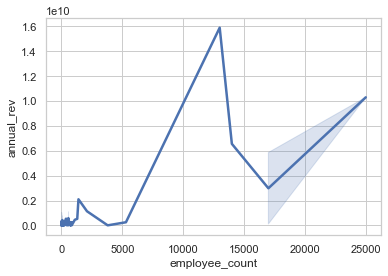

In [264]:
sns.lineplot(data=companiesCS_ann[companiesCS_ann['status'] == 'closed'], x="employee_count", y="annual_rev", palette="tab10", linewidth=2.5)

From the previous graph, a similar pattern is recognized from the previous graph. Here, the closed companies the maximum number of employees and annual revenue reached is noticebly way less than the operatiing companies which is reasonable. Having more than 5000 acheive reasonable profits.

<AxesSubplot:xlabel='employee_count', ylabel='annual_rev'>

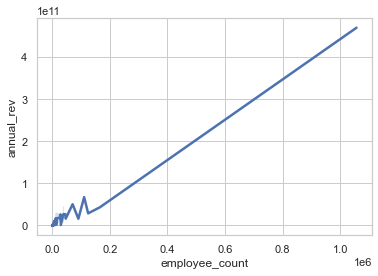

In [265]:
sns.lineplot(data=companiesCS_ann[companiesCS_ann['status'] == 'ipo'], x="employee_count", y="annual_rev", palette="tab10", linewidth=2.5)

Regarding the ipo companies, they can have a huge number of employees since they are publically offered for stock sharing, they may have the ability to hire great amount of employees, and from the pattern seen from past graphs, hiring more employees help in increasing annual revenues. By this graph, it is clearly seen that the number of employees is directly proportional with the number of employees.

<AxesSubplot:xlabel='employee_count', ylabel='annual_rev'>

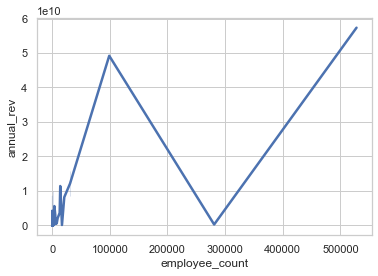

In [266]:
sns.lineplot(data=companiesCS_ann[companiesCS_ann['status'] == 'acquired'],x="employee_count", y="annual_rev", palette="tab10", linewidth=2.5)

Since those companies are aquired so having much employees should be acheivable due to the addtion of the old employees to the ones working in the aquired one. So, the increase of employees definetly helped in increasing the annual revenue of the company.

## Question 2: Which categroy acheives highest revenue? (Farah)

Let's take a look at which category attracts most funding

#### Cleaning

Now we will remove the missing valiues from the category list and employee count that is equal to zero bcause we will formulate a ratio and cannot be divided by 0.

In [267]:
rev_employee = companiesCS_ann[companiesCS_ann.employee_count != 0]
rev_employee.sort_values(by=['company_category_list', 'annual_rev'],ascending=False, inplace=True)
rev_employee = rev_employee[rev_employee.company_category_list != 'missing']
rev_employee

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund,employee_count,number_of_technologies,annual_rev
5507,/organization/betify,Betify,http://getbetify.com,iPhone|Mobile|Social Network Media|Software,250000.00,operating,GBR,London,1,2013-05-13 00:00:00.000000000,2013-12-21,2013-12-21,222 days 00:00:00,6,0,117000.0
5251,/organization/befunky,BeFunky,http://www.befunky.com,iPhone|Mobile|Photography|Photo Sharing,1650000.00,operating,USA,missing,3,2007-01-01 00:00:00.000000000,2007-01-01,2012-03-01,0 days 00:00:00,21,11,3400000.0
8055,/organization/canwenetwork,CanWeNetwork,http://www.canwenetwork.com,iPhone|Mobile|Networking,3000000.00,operating,USA,Austin,1,2011-11-01 00:00:00.000000000,2012-03-01,2012-03-01,121 days 00:00:00,50,7,1504000.0
1903,/organization/aixuedai,Aixuedai,http://www.aixuedai.com/,iPhone|Lifestyle|Online Shopping|Retail,40000000.00,operating,GBR,Rayleigh,1,2011-04-19 20:46:43.240577680,2015-01-12,2015-01-12,1363 days 03:13:16.759422320,320,0,65250000.0
4165,/organization/audanika,Audanika,http://www.audanika.com,iPad|iPhone|Mobile|Music,0.00,operating,DEU,Ilmenau,1,2010-01-01 00:00:00.000000000,2010-01-01,2010-01-01,0 days 00:00:00,4,2,672000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,/organization/astroprint,AstroPrint,https://www.astroprint.com,3D Printing,250000.00,operating,USA,San Diego,1,2013-09-01 00:00:00.000000000,2014-11-01,2014-11-01,426 days 00:00:00,5,23,5000000.0
9925,/organization/makerarm,Makerarm,http://makerarm.com,3D Printing,85000.00,operating,USA,missing,1,2015-01-01 00:00:00.000000000,2015-10-05,2015-10-05,277 days 00:00:00,5,7,637000.0
6540,/organization/blueprinter,BluePrinter,http://blueprinter.dk,3D Printing,0.00,operating,DNK,Copenhagen,2,2009-01-01 00:00:00.000000000,2013-03-01,2015-05-26,1520 days 00:00:00,8,8,555000.0
12983,/organization/my-mini-factory,My Mini Factory,http://www.myminifactory.com,3D Printing,1200000.00,operating,GBR,London,1,2013-06-18 00:00:00.000000000,2015-10-25,2015-10-25,859 days 00:00:00,44,21,409000.0


Calculating the revenue per employee is a meaningful analytical tool because it measures how efficiently a particular firm utilizes its employees. Ideally, a company wants the highest ratio of revenue per employee possible because a higher ratio indicates greater productivity. 

In [268]:
rev_employee['rev/employee'] = rev_employee['annual_rev']/rev_employee['employee_count']
rev_employee

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund,employee_count,number_of_technologies,annual_rev,rev/employee
5507,/organization/betify,Betify,http://getbetify.com,iPhone|Mobile|Social Network Media|Software,250000.00,operating,GBR,London,1,2013-05-13 00:00:00.000000000,2013-12-21,2013-12-21,222 days 00:00:00,6,0,117000.0,19500.000000
5251,/organization/befunky,BeFunky,http://www.befunky.com,iPhone|Mobile|Photography|Photo Sharing,1650000.00,operating,USA,missing,3,2007-01-01 00:00:00.000000000,2007-01-01,2012-03-01,0 days 00:00:00,21,11,3400000.0,161904.761905
8055,/organization/canwenetwork,CanWeNetwork,http://www.canwenetwork.com,iPhone|Mobile|Networking,3000000.00,operating,USA,Austin,1,2011-11-01 00:00:00.000000000,2012-03-01,2012-03-01,121 days 00:00:00,50,7,1504000.0,30080.000000
1903,/organization/aixuedai,Aixuedai,http://www.aixuedai.com/,iPhone|Lifestyle|Online Shopping|Retail,40000000.00,operating,GBR,Rayleigh,1,2011-04-19 20:46:43.240577680,2015-01-12,2015-01-12,1363 days 03:13:16.759422320,320,0,65250000.0,203906.250000
4165,/organization/audanika,Audanika,http://www.audanika.com,iPad|iPhone|Mobile|Music,0.00,operating,DEU,Ilmenau,1,2010-01-01 00:00:00.000000000,2010-01-01,2010-01-01,0 days 00:00:00,4,2,672000.0,168000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,/organization/astroprint,AstroPrint,https://www.astroprint.com,3D Printing,250000.00,operating,USA,San Diego,1,2013-09-01 00:00:00.000000000,2014-11-01,2014-11-01,426 days 00:00:00,5,23,5000000.0,1000000.000000
9925,/organization/makerarm,Makerarm,http://makerarm.com,3D Printing,85000.00,operating,USA,missing,1,2015-01-01 00:00:00.000000000,2015-10-05,2015-10-05,277 days 00:00:00,5,7,637000.0,127400.000000
6540,/organization/blueprinter,BluePrinter,http://blueprinter.dk,3D Printing,0.00,operating,DNK,Copenhagen,2,2009-01-01 00:00:00.000000000,2013-03-01,2015-05-26,1520 days 00:00:00,8,8,555000.0,69375.000000
12983,/organization/my-mini-factory,My Mini Factory,http://www.myminifactory.com,3D Printing,1200000.00,operating,GBR,London,1,2013-06-18 00:00:00.000000000,2015-10-25,2015-10-25,859 days 00:00:00,44,21,409000.0,9295.454545


It is seen that companies working in software and tech in general has the most annual revenues. This shows that the makrket of this kind of feild is profitable and has higher 

In [269]:
tmpp = rev_employee[rev_employee['company_category_list'].str.contains("Software")]
tmpp

,company_permalink,company_name,homepage_url,company_category_list,funding_total_usd,status,company_country_code,company_city,funding_rounds,founded_at,first_funding_at,last_funding_at,time_before_first_fund,employee_count,number_of_technologies,annual_rev,rev/employee
5507,/organization/betify,Betify,http://getbetify.com,iPhone|Mobile|Social Network Media|Software,250000.0,operating,GBR,London,1,2013-05-13,2013-12-21,2013-12-21,222 days 00:00:00,6,0,117000.0,1.950000e+04
5248,/organization/beetv,BeeTV,http://bee.tv,iPad|Reviews and Recommendations|Social Televi...,9500000.0,closed,ITA,Milan,2,2007-08-01,2009-06-03,2011-05-17,672 days 00:00:00,4,3,5400000.0,1.350000e+06
2234,/organization/alluring-logic,Alluring Logic,http://alluringlogic.com,iPad|Mobile|Point of Sale|Retail|SaaS|Software...,0.0,closed,USA,New York,1,2009-08-22,2013-07-25,2013-07-25,1433 days 00:00:00,540,3,37426000.0,6.930741e+04
119,/organization/21vianet,21viaNet,http://www.ch.21vianet.com,Software|Web Hosting,396000000.0,ipo,CHN,Beijing,5,2009-10-16,2008-02-13,2014-12-04,-611 days +00:00:00,630,9,797666000.0,1.266137e+06
14264,/organization/nexaweb-technologies,Nexaweb Inc.,http://www.nexaweb.com,Software|Web Development,14603757.0,operating,USA,Burlington,3,2000-01-01,2003-05-19,2012-08-21,1234 days 00:00:00,15,10,18906000.0,1.260400e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,/organization/4tiitoo,4tiitoo GmbH,http://www.4tiitoo.com,3D Technology|Augmented Reality|Computers|Comp...,0.0,operating,DEU,Munich,3,2013-12-10,2011-11-15,2014-08-18,-756 days +00:00:00,12,10,161000.0,1.341667e+04
1796,/organization/aio-robotics,AIO Robotics,http://www.aiorobotics.com,3D Printing|Hardware + Software,0.0,operating,USA,Los Angeles,1,2013-05-24,2015-07-01,2015-07-01,768 days 00:00:00,3,5,10000000.0,3.333333e+06
9003,/organization/local-motors,Local Motors,http://localmotors.com,3D Printing|Crowdfunding|Crowdsourcing|Educati...,250000.0,operating,USA,Chandler,2,2007-07-01,2012-06-06,2014-07-01,1802 days 00:00:00,380,29,32000000.0,8.421053e+04
9616,/organization/lyteshot,LyteShot,http://www.lyteshot.com,3D Printing|Advertising|Augmented Reality|Digi...,635000.0,operating,USA,Chicago,1,2012-12-26,2014-11-14,2014-11-14,688 days 00:00:00,75,3,3985000.0,5.313333e+04


### Question 3: Does the annual Revenue attract investors? (Farah)

Let's first look at the investments and see if number of investors affect those proifts or not

#### Merging

First, we merge between the two datasets

In [270]:
comps_invests = companiesCS_ann.join(investsC[['raised_amount_usd', 'investor_name']])
comps_invests

NameError: name 'investsC' is not defined

We might notice that there is a possiblity of a direct proportional relationship between the amount of money invested in a company and its annual revenue. We will test it by visualizing the relationship.

#### Visualization & Analysis

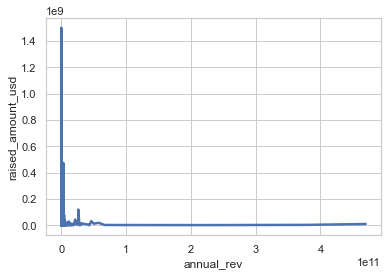

In [ ]:
ax = sns.lineplot(data=comps_invests,x="annual_rev", y="raised_amount_usd", palette="tab10", linewidth=2.5)



The barplot disproves the hypothesis that the annual revenue may attract investors to invest more money into those companies. As seen the relationship between the annual revenue and investing amount isn't directly proportional.

# Hypothsis using T Test

Using T test, we will test if the effect of the number of employees and the effect of the number of technologies used on the company's success are equal

H0: The effect of the number of employees and the effect of the number of technologies used on the company's success are equal i.e., μ1 = μ2

H1: The effect of the number of employees and the effect of the number of technologies used on the company's success are not equal i.e., μ1 ≠ μ2

creating series for each column in the original dataframe

first we will take a sample of 51 rows from the dataset

In [ ]:
import scipy
sample = companiesCS.head(51)
emp = sample['employee_count']
tech = sample['number_of_technologies']

Calculating the t score

In [ ]:
t_score = scipy.stats.ttest_ind(tech, emp).statistic
t_score

-1.747505269912122

A negative t-value indicates a reversal in the directionality of the effect, which has no bearing on the significance of the difference between groups, so we take its absolute value

Calculating the degree of freedom

In [ ]:
Degree_of_freedom = len(tech) + len(emp) - 2
Degree_of_freedom

100

In [ ]:
alpha = 0.05
scipy.stats.t.ppf(1-alpha, Degree_of_freedom)

1.66023432606575

As seen above the absolute value of the t-score is > the t-value from the table so the null hypothesis is rejected

therefore, The effect of the number of employees and the effect of the number of technologies used on the company's success are not equal